In [1]:
import platform
import psutil
import subprocess

def get_cpu_model():
    try:
        if platform.system() == "Windows":
            return platform.processor()
        elif platform.system() == "Darwin":  # macOS
            return subprocess.check_output(["sysctl", "-n", "machdep.cpu.brand_string"]).strip().decode()
        elif platform.system() == "Linux":
            with open("/proc/cpuinfo") as f:
                for line in f:
                    if "model name" in line:
                        return line.strip().split(":")[1].strip()
    except Exception:
        return "Unknown CPU"

def get_hardware_summary():
    cpu_model = get_cpu_model()
    physical_cores = psutil.cpu_count(logical=False)
    logical_cores = psutil.cpu_count(logical=True)
    cpu_freq = psutil.cpu_freq()
    base_freq_ghz = cpu_freq.min / 1000 if cpu_freq else 0

    ram = psutil.virtual_memory()
    ram_size_gb = round(ram.total / (1024 ** 3), 1)

    print("Hardware Summary:")
    print(f"  CPU Model: {cpu_model}")
    print(f"  Cores / Threads: {physical_cores} / {logical_cores}")
    print(f"  Base Clock Speed: {base_freq_ghz:.2f} GHz")
    print(f"  RAM: {ram_size_gb} GB")

get_hardware_summary()


Hardware Summary:
  CPU Model: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
  Cores / Threads: 4 / 8
  Base Clock Speed: 0.00 GHz
  RAM: 15.7 GB


## libraries

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
# Create data
import scipy.stats as stats

import os
import math
import shutil

import torch.nn.functional as F

from sklearn.metrics import mean_squared_error
from numpy import random
random.seed(0)
import numpy as np
import torch
torch.manual_seed(0)
from scipy import linalg as LA
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from scipy.special import softmax
from sklearn.decomposition import PCA

import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



import warnings
warnings.filterwarnings('ignore')

## auxiliar functions

In [2]:
#https://broadlearning.ai/bls/
def sigmoid_activation(data):
    return 1.0/(1+np.exp(-data))
def pinv(A, reg):
  """
  pseudo inverse matrix of A and regularized
  """
  return np.mat(reg*np.eye(A.shape[1])+A.T.dot(A)).I.dot(A.T)

def shrinkage(a, b):
    z = np.maximum(a - b, 0) - np.maximum( -a - b, 0)
    return z

def sparse_bls(A, b):
    #[n,M1] ; [n,D+1]
    #sparsity linear regression
    lam = 0.001  # lambda regularization
    itrs = 50 #iterations
    AA = A.T.dot(A) #A^tA= [M1,n]x[n,M1]=[M1,M1]
    m = A.shape[1]
    n = b.shape[1]
    x1 = np.zeros([m, n])
    wk = x1
    ok = x1
    uk = x1
    #plus indentity to prevent singularity
    # inversion
    L1 = np.mat(AA + np.eye(m)).I
    L2 = (L1.dot(A.T)).dot(b) # [M1,M1]x[M1,n]= [M1,n] x [n, D+1]= [M1,D+1]
    for i in range(itrs):
        ck = L2 + np.dot(L1, (ok - uk))
        ok = shrinkage(ck + uk, lam) #sparsity
        uk = uk + ck - ok
        wk = ok
    return wk

def show_accuracy(predictLabel, Label, task="classification"):
    Label,predictLabel= np.asarray(Label), np.asarray(predictLabel)
    if task == "regression":
        mse = mean_squared_error(Label, predictLabel, squared=False)
        mae = mean_absolute_error(Label, predictLabel)
        return {"RMSE": np.round(mse, 5), "MAE": np.round(mae, 5)}
    
    else:
        label_1 = Label.argmax(axis=1)
        predlabel = predictLabel.argmax(axis=1)
        accuracy = (label_1 == predlabel).sum() / len(Label)
        
        # Calculate F1 score (assuming it's a binary or multiclass classification)
        f1 = f1_score(label_1, predlabel, average="weighted")  # Use "weighted" for multiclass
        
        return {"Accuracy": np.round(accuracy, 5), "F1 Score": np.round(f1, 5)}

## basis

In [3]:
sigma= 28*28*0.01/28
centros = np.linspace(sigma*3, 28-sigma*3, int(n/2))
a= MinMaxScaler(feature_range=(0, 1)).fit_transform(gaussian(np.arange(28), centros[0], sigma).reshape(-1,1)).reshape(28).tolist()*28

NameError: name 'n' is not defined

In [3]:

# Definir la función gaussiana
def gaussian(x, mu, sigma):
    return (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)


    
def gaussianas_y_valores(D, n, sigma=None, mnist=False):
    
    gaussianas = []
    valores_gaussianas = []
    if mnist:
        sigma= sigma/28
        centros = np.linspace(sigma*3, 28-sigma*3, int(n/2))
        for centro in centros:
            #valores=  MinMaxScaler(feature_range=(0, 1)).fit_transform(gaussian(np.arange(28), centro, sigma).reshape(-1,1)).reshape(28).tolist()*28
            #valores_gaussianas.append(valores)
            valores = scipy.stats.norm(loc=centro, scale=sigma).pdf(np.arange(28)).tolist()*28
            for i in np.random.choice(range(28),14):
                valores[i*28:28*(i+1)]=[0]*28
            valores_gaussianas.append(valores)   
            
        centros_bimodal = np.linspace(sigma*3, (28-sigma*3)/2, int(n/2))
        for centro in centros_bimodal:
            #values= gaussian(np.arange(28), centro, sigma) + gaussian(np.arange(28), 28-centro, sigma)
            #valores_bimodal=  MinMaxScaler(feature_range=(0, 1)).fit_transform(values.reshape(-1,1)).reshape(28).tolist()*28
            #valores_gaussianas.append(valores_bimodal)
            valores = scipy.stats.norm(loc=centro, scale=sigma).pdf(np.arange(28)) +scipy.stats.norm(loc=28-centro, scale=sigma).pdf(np.arange(28))
            valores= valores.tolist()*28
            for i in np.random.choice(range(28),14):
                valores[i*28:28*(i+1)]=[0]*28
            valores_gaussianas.append(valores) 
    else:
        # Centros de las gaussianas
        centros = np.linspace(0, D, n)
        for centro in centros:
            gaussianas.append(scipy.stats.norm(loc=centro, scale=sigma))        
        # Evaluar las gaussianas en los puntos enteros
        for gaussiana in gaussianas:
            valores = gaussiana.pdf(np.arange(D))
            valores_gaussianas.append(valores.tolist())

    return valores_gaussianas


In [4]:
valores= gaussianas_y_valores(28*28, 10, sigma=28*28*0.1, mnist=True)
weightOfEachWindow= np.array(valores).T 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


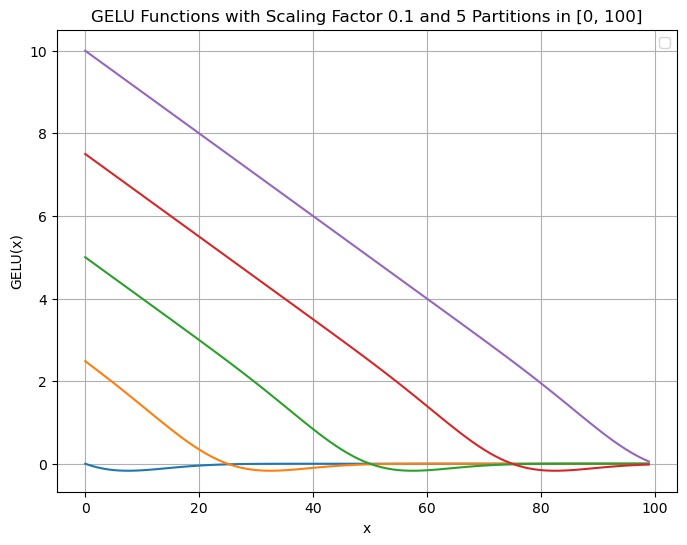

In [4]:
def gelu(x):
    # Implementación de la función GELU
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

def generate_gelu_functions(D, n, scale=1.0, flip=False, show=False):
    # Calcular los puntos de inflexión equiespaciados
    breakpoints = np.linspace(0, D, n)
    
    # Definir una lista para las funciones GELU generadas y sus evaluaciones
    evaluations = []
    x_values = np.arange(0, D)  # Números enteros de 0 a D

    
    # Crear las funciones GELU escaladas
    for i in range(n):
            if flip:
                evaluations.append([gelu(scale * -(x - breakpoints[i])) for x in x_values])

            else:
                evaluations.append([gelu(scale * (x - breakpoints[i])) for x in x_values])


    
    # Modo para mostrar los gráficos de las funciones GELU
    if show:
        plt.figure(figsize=(8, 6))
        for i, y_values in enumerate(evaluations):
            plt.plot(x_values, y_values) # label=f'GELU {i+1} (bp={breakpoints[i]:.2f})'
        
        plt.title(f'GELU Functions with Scaling Factor {scale} and {n} Partitions in [0, {D}]')
        plt.xlabel('x')
        plt.ylabel('GELU(x)')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Retornar las evaluaciones de las funciones GELU en los enteros de 0 a D
    return evaluations

# Ejemplo de uso
D = 100  # Valor máximo
n = 5   # Número de particiones
scale = 0.1  # Escala de crecimiento para las funciones
show = True  # Modo gráfico

gelu_evaluations = generate_gelu_functions(D, n, scale,True, show)

# Imprimir las evaluaciones de cada GELU en los enteros de 0 a D
#for i, evals in enumerate(gelu_evaluations):
#    print(f"Evaluaciones de GELU {i+1}: {evals}")


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sigmoid_functions(D, n, growth_rate, flip=False, show=False):
    # Calcular los puntos de inflexión equiespaciados
    breakpoints = np.linspace(0, D, n)
    
    # Definir una lista para las funciones sigmoide generadas y sus evaluaciones
    evaluations = []
    x_values = np.arange(0, D)  # Números enteros de 0 a D
    
    # Crear las funciones sigmoide
    for i in range(n):
        if flip:
            evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])

        else:
            evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
    
    # Modo para mostrar los gráficos de las funciones sigmoide
    if show:
        plt.figure(figsize=(8, 6))
        for i, y_values in enumerate(evaluations):
            plt.plot(x_values, y_values) #, label=f'Sigmoid {i+1} (bp={breakpoints[i]:.2f})'
        
        plt.title(f'Sigmoid Functions with Growth Rate {growth_rate} and {n} Partitions in [0, {D}]')
        plt.xlabel('x')
        plt.ylabel('Sigmoid(x)')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Retornar las evaluaciones de las funciones sigmoide en los enteros de 0 a D
    return evaluations

# Ejemplo de uso
D = 100  # Valor máximo
n = 10   # Número de particiones
growth_rate = 0.1  # Coeficiente de crecimiento
show = True  # Modo gráfico

sigmoid_evaluations = generate_sigmoid_functions(D, n, growth_rate, show)


### plots

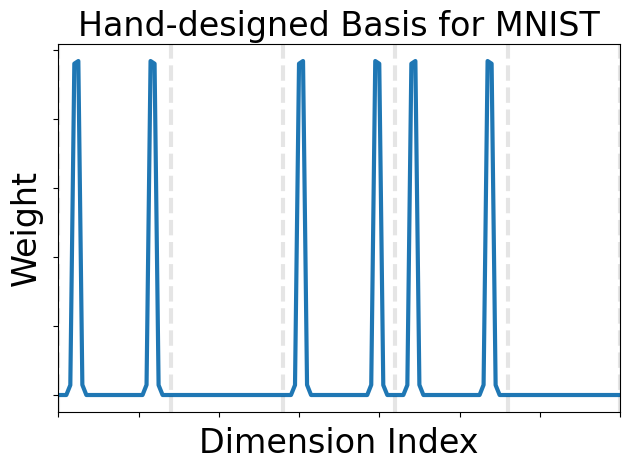

In [36]:
sigmas_amplificador= np.linspace(0.01,0.1, 100)

for i in range(10,100):
    sigma= 28*28*sigmas_amplificador[i]
    valores = gaussianas_y_valores(28*28, 10, sigma, mnist=True) 
    #plt.figure(figsize=(10, 6))
    fig, ax = plt.subplots()
    for j in range(6,10):
        plt.plot(np.arange(28*28), valores[j], linewidth=3) 
        break
    for i in range(0, 28*28, 28):
        plt.axvline(x=i, color='black', linestyle='--', alpha=0.1, linewidth=3)
    
    ax.set_xlim(0,28*5)
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('Weight',fontsize=24)
    ax.set_xlabel('Dimension Index',fontsize=24)
    ax.set_title('Hand-designed Basis for MNIST',fontsize=24)

    plt.tight_layout()
    plt.savefig('hand-design.png', dpi=400)
    plt.show()
    break
    

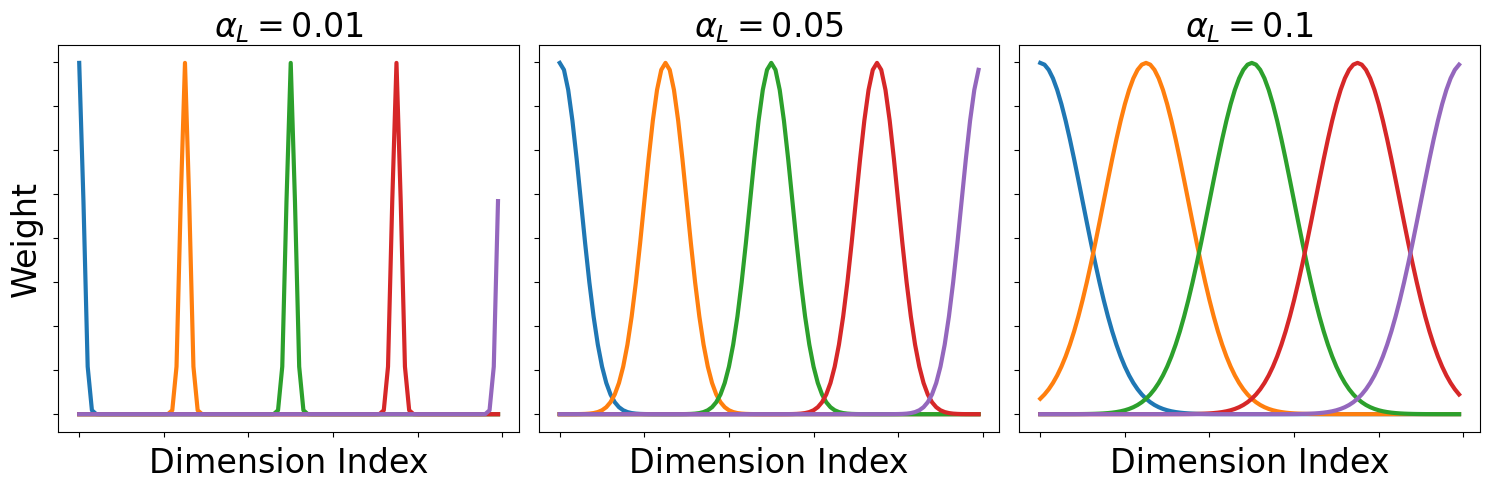

In [79]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

D = 100#15#100
d = 5#8 #5
sigmas = [0.01*D, 0.05*D, 0.1*D]  # Agregar un valor para sigma si no está definido
alpha_L=[0.01,0.05,0.1]
# Centros de las gaussianas
centros = np.linspace(0, D, d)

# Crear una figura con tres gráficos en una fila
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Lista para almacenar los valores de las gaussianas en los puntos enteros
valores_gaussianas = []

# Evaluar las gaussianas en los puntos enteros y graficarlas en cada eje
for i, ax in enumerate(axes):
    gaussianas = []
    for centro in centros:
        gaussianas.append(scipy.stats.norm(loc=centro, scale=sigmas[i]))
    for gaussiana in gaussianas:
        valores = gaussiana.pdf(np.arange(D))
        valores_gaussianas.append(valores.tolist())
        ax.plot(np.arange(D), valores,linewidth=3)
    
    ax.set_xlabel('Dimension Index',fontsize=24)
    #ax.set_ylabel('Value')
    ax.set_title('$ \\alpha_L= $' +f'{alpha_L[i]}',fontsize=24)
    if i==0:
        ax.set_ylabel('Weight',fontsize=24)    
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig('gaussian.png', dpi=400)
plt.show()





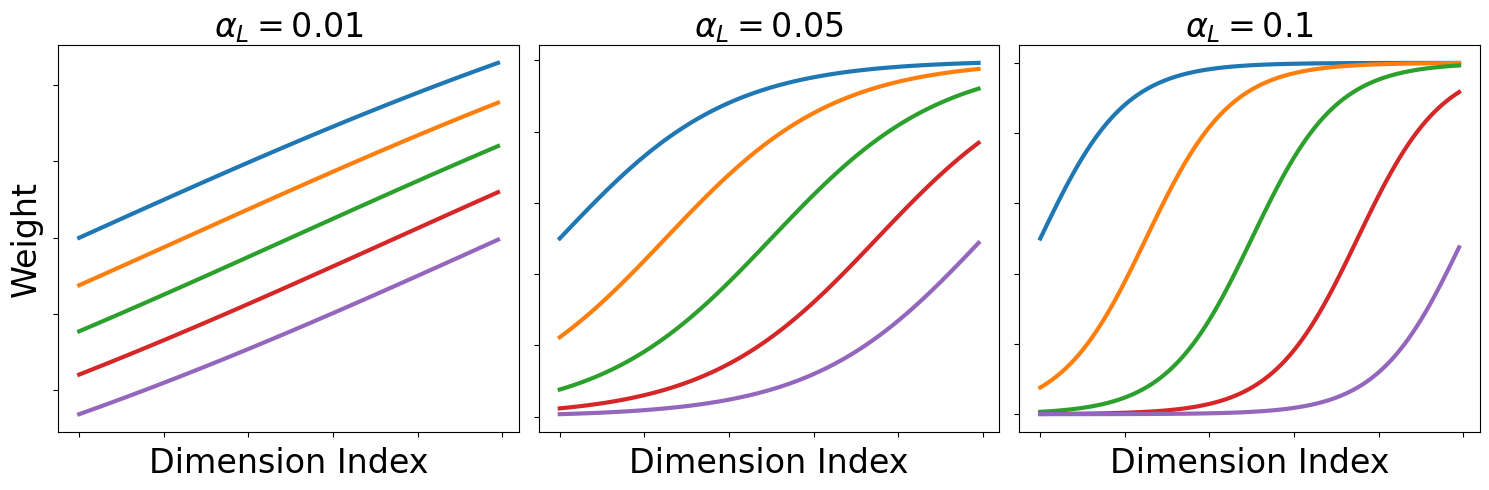

In [80]:
D = 100
d = 5
alpha_L=[0.01,0.05,0.1]#[0.1,0.5,0.9]

# Evaluar las funciones sigmoide en los enteros de 0 a D
x_values = np.arange(0, D)  # Números enteros de 0 a D
    
# Centros de las gaussianas
breakpoints = np.linspace(0, D, d)

# Crear una figura con tres gráficos en una fila
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Lista para almacenar los valores de las gaussianas en los puntos enteros
valores_gaussianas = []

# Evaluar las gaussianas en los puntos enteros y graficarlas en cada eje
for i, ax in enumerate(axes):
    sigmoid_functions = []
    evaluations=[]
    for j in range(d):
        def sigmoid(x, breakpoint=breakpoints[j], growth_rate=alpha_L[i]):
            return 1 / (1 + np.exp(-growth_rate * (x - breakpoint)))
        sigmoid_functions.append(sigmoid)
    
    for sigmoid_func in sigmoid_functions:
        evaluations.append([sigmoid_func(x) for x in x_values])
        
    for y_values in evaluations:
        ax.plot(x_values, y_values,linewidth=3)
    
    ax.set_xlabel('Dimension Index',fontsize=24)
    #ax.set_ylabel('Value')
    ax.set_title('$\\alpha_L= $' +f'{alpha_L[i]}',fontsize=24)
    if i==0:
        ax.set_ylabel('Weight',fontsize=24)    
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig('sigmoid.png', dpi=400)
plt.show()


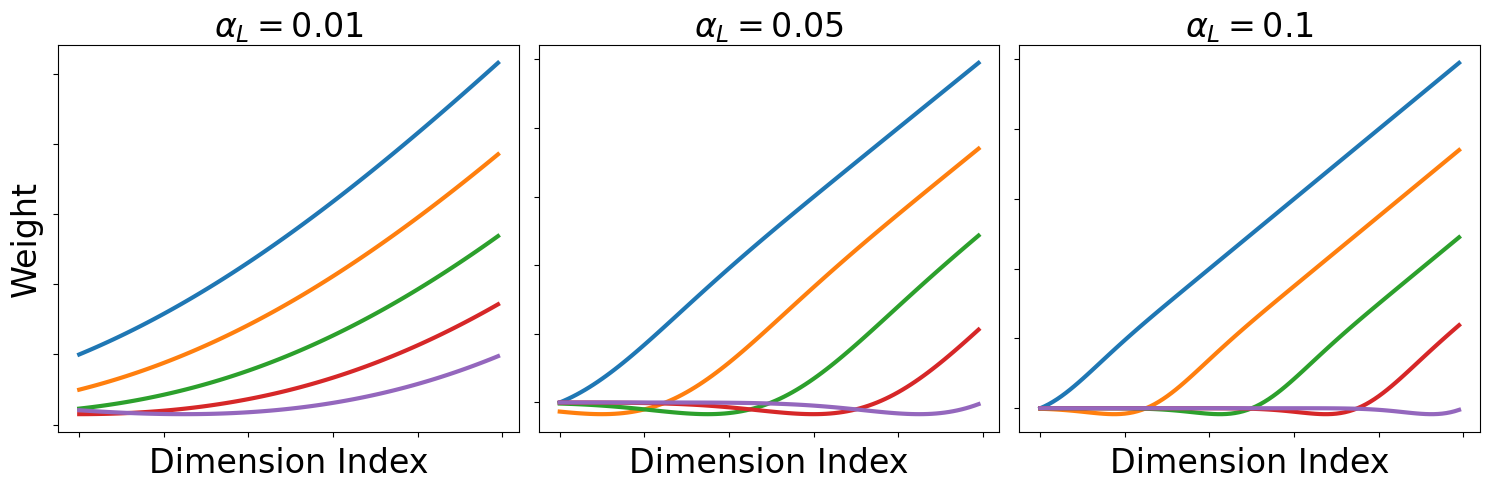

In [53]:
D = 100
d = 5
alpha_L=[0.01,0.05,0.1]

# Evaluar las funciones sigmoide en los enteros de 0 a D
x_values = np.arange(0, D)  # Números enteros de 0 a D
    
# Centros de las gaussianas
breakpoints = np.linspace(0, D, d)

# Crear una figura con tres gráficos en una fila
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Lista para almacenar los valores de las gaussianas en los puntos enteros
valores_gaussianas = []

# Evaluar las gaussianas en los puntos enteros y graficarlas en cada eje
for i, ax in enumerate(axes):
    sigmoid_functions = []
    evaluations=[]
    for j in range(d):
        def gelu_scaled(x, breakpoint=breakpoints[j], scale=alpha_L[i]):
            x_scaled = scale * (x - breakpoint)
            return gelu(x_scaled)
        sigmoid_functions.append(gelu_scaled)
    
    for sigmoid_func in sigmoid_functions:
        evaluations.append([sigmoid_func(x) for x in x_values])
        
    for y_values in evaluations:
        ax.plot(x_values, y_values,linewidth=3)
    
    ax.set_xlabel('Dimension Index',fontsize=24)
    if i==0:
        ax.set_ylabel('Weight',fontsize=24)
    ax.set_title('$ \\alpha_L= $' +f'{alpha_L[i]}',fontsize=24)
    
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig('Gelu.png', dpi=400)
plt.show()

In [22]:
valores = gaussianas_y_valores(8, 10, 8*0.1, show=True)

TypeError: gaussianas_y_valores() got an unexpected keyword argument 'show'

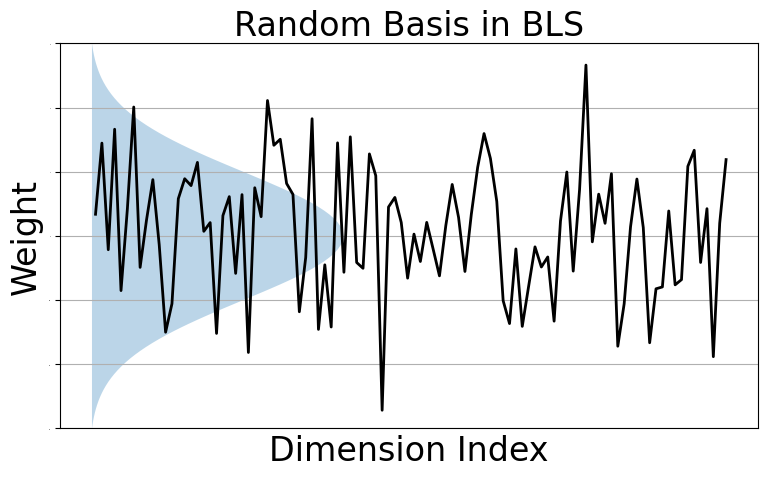

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Generar una muestra de una distribución normal estándar de tamaño n
n = 100
muestra = np.random.normal(0, 1, n)

# Crear los valores de x para la curva normal estándar
x = np.linspace(-3, 3, 100)

# Obtener los valores de la función de densidad de probabilidad (PDF) de la distribución normal estándar
pdf = stats.norm.pdf(x, 0, 1)

# Graficar la muestra generada
plt.figure(figsize=(9, 5))
plt.plot(range(1, n+1), muestra, color='black', linestyle='-', linewidth=2)

# Invertir la curva normal para que se vea a lo largo del eje X
inverted_x = pdf * np.max(range(1, n+1))
inverted_y = np.linspace(-3, 3, len(pdf))

# Graficar la curva invertida
plt.plot(inverted_x, inverted_y,  linewidth=0)

# Rellenar la curva con un color sólido semitransparente
plt.fill_between(inverted_x, inverted_y,  alpha=0.3)

plt.xticks([])

# Etiquetas y título
plt.xlabel('Dimension Index',fontsize=24)
plt.ylabel('Weight',fontsize=24)
plt.title('Random Basis in BLS',fontsize=24)
plt.ylim(-3, 3)
plt.grid(True)

#plt.xticks(fontsize=14)
plt.yticks(fontsize=0)

# Añadir leyenda
#plt.legend()
plt.savefig('random_BLS.png', dpi=400)
# Mostrar la gráfica
plt.show()


Matrix 1: 40 componentes principales capturan el 95% de la variabilidad.
Matrix 2: 10 componentes principales capturan el 95% de la variabilidad.


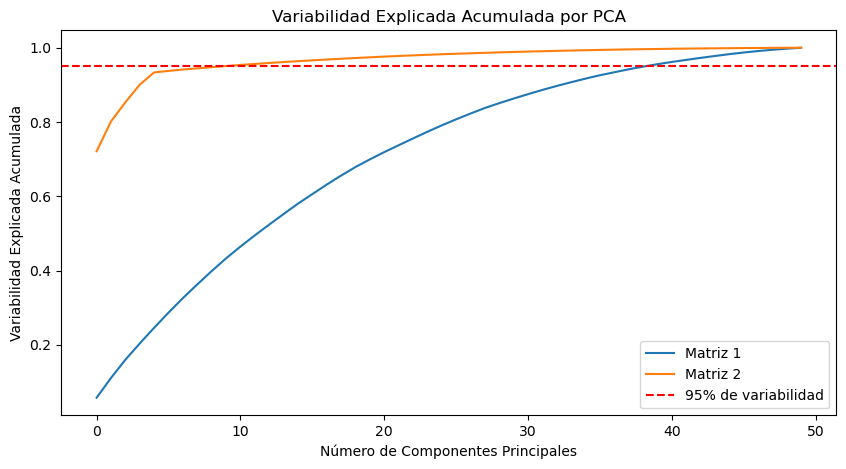

In [24]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Paso 1: Generar dos matrices aleatorias
np.random.seed(42)  # Fijar la semilla para reproducibilidad
matrix1 = np.random.normal(loc=0.0, scale=1.0, size=(100, 50))  # 100 muestras, 50 características
base_matrix = np.random.rand(100, 5)  # 5 componentes principales
matrix2 = base_matrix @ np.random.rand(5, 50)  # Proyectamos en un espacio de 50D
matrix2 += np.random.normal(scale=0.1, size=matrix2.shape)  # Añadimos un poco de ruido

# Paso 2: Aplicar PCA a cada matriz
pca1 = PCA()
pca1.fit(matrix1)

pca2 = PCA()
pca2.fit(matrix2)

# Paso 3: Determinar cuántas componentes capturan el 95% de la variabilidad

def components_for_variability(pca, variance_threshold=0.95):
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    return n_components, cumulative_variance

# Para la primera matriz
n_components1, cumulative_variance1 = components_for_variability(pca1)
print(f"Matrix 1: {n_components1} componentes principales capturan el 95% de la variabilidad.")

# Para la segunda matriz
n_components2, cumulative_variance2 = components_for_variability(pca2)
print(f"Matrix 2: {n_components2} componentes principales capturan el 95% de la variabilidad.")

# Visualización de la variabilidad explicada
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance1, label="Matriz 1")
plt.plot(cumulative_variance2, label="Matriz 2")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% de variabilidad")
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Variabilidad Explicada Acumulada')
plt.title('Variabilidad Explicada Acumulada por PCA')
plt.legend()
plt.show()

dim: Z: 100  and H:  100


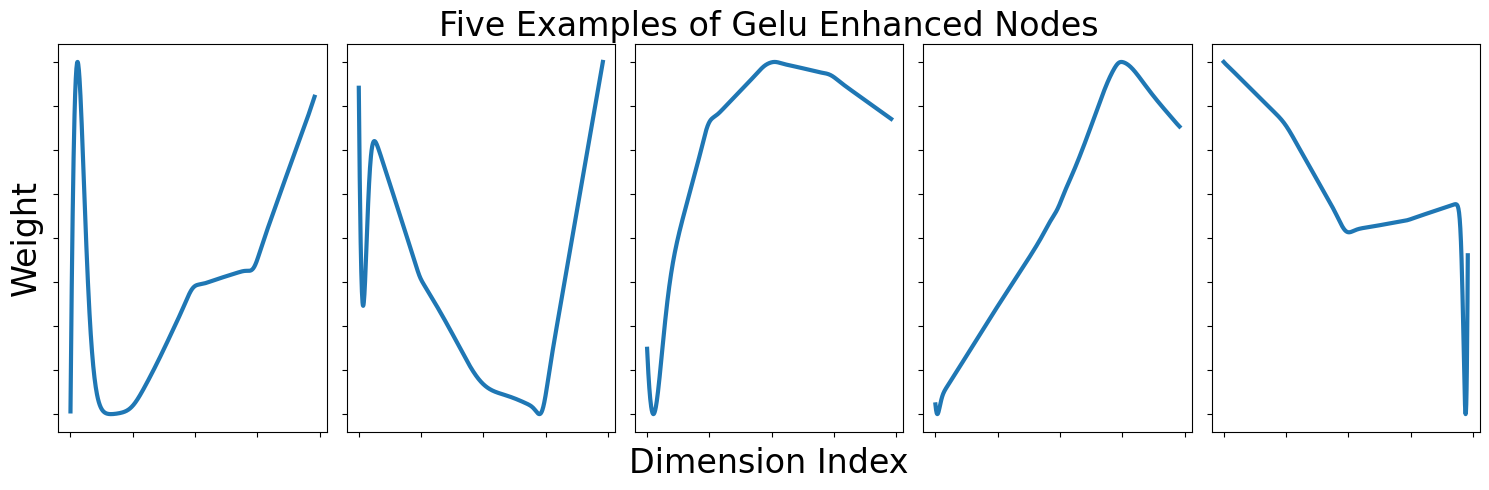

In [39]:
method="gelu"
model= BLS( 1E-8 , 10, 10, 10,sampling=[method,method],task= "classification")
(train_acc,train_time,W)=model.train(train_x,train_y)

D= 784
# Evaluar las funciones sigmoide en los enteros de 0 a D
x_values = np.arange(0, D)  # Números enteros de 0 a D


import matplotlib.pyplot as plt

# Crear una figura con cinco gráficos en una fila
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 1 fila, 5 columnas

# Lista para almacenar los valores de las gaussianas en los puntos enteros
valores_gaussianas = []

# Evaluar las gaussianas en los puntos enteros y graficarlas en cada eje
for i, ax in enumerate(axes):
    ax.plot(x_values, model.basisH[:, i],  linewidth=3)
    
    
    
    ax.yaxis.set_ticklabels([])
    ax.xaxis.set_ticklabels([])
    if i==0:
        ax.set_ylabel('Weight',fontsize=24)
    if i==2:
        ax.set_title(f'Five Examples of {method.capitalize()} Enhanced Nodes',fontsize=24)
        ax.set_xlabel('Dimension Index',fontsize=24)


plt.tight_layout()
plt.savefig('h_gelu.png', dpi=400)
plt.show()


## BLS

In [27]:
sigma= 100*0.05
noise_scale=1
valores = gaussianas_y_valores(100, 10, sigma)
weightOfEachWindow= np.array(valores).T  
              #scaler1 = MinMaxScaler(feature_range=(-1, 1)).fit(weightOfEachWindow)
              #weightOfEachWindow= scaler1.transform(weightOfEachWindow)
weightOfEachWindow_1= MinMaxScaler(feature_range=(-1, 1)).fit_transform(weightOfEachWindow)
random_bias= MinMaxScaler(feature_range=(-1, 1)).fit_transform(random.randn(10,1))/noise_scale
              #random_bias= scaler1.transform(random.randn(1,self.d))/self.noise_scale  
white_noise= MinMaxScaler(feature_range=(-1, 1)).fit_transform(random.randn(100,10))/noise_scale
              #weightOfEachWindow+= scaler1.transform(random.randn(train_x.shape[1],self.d))/self.noise_scale #relevant=ablation
weightOfEachWindow_2=weightOfEachWindow_1+ white_noise
weightOfEachWindow_3= np.concatenate((weightOfEachWindow_2,random_bias.T),axis=0)

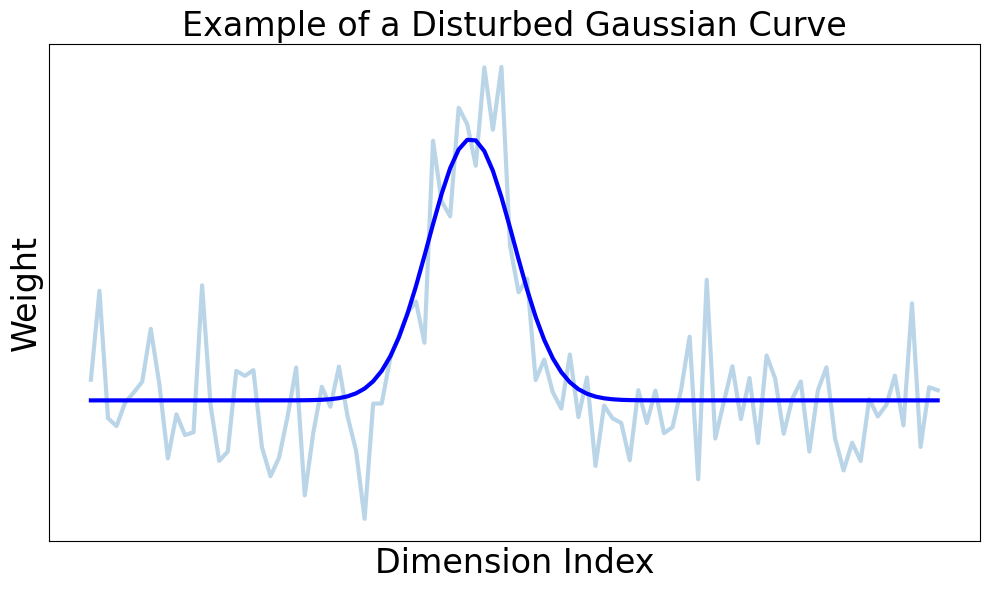

In [40]:
# Crear una figura
plt.figure(figsize=(10, 6))
plt.plot(range(1,101), weightOfEachWindow_2[:,4], alpha=0.3, linewidth= 3)
plt.plot(range(1,101), weightOfEachWindow_1[:,4], color="Blue", linewidth= 3)
plt.ylabel('Weight',fontsize=24)
plt.xlabel('Dimension Index',fontsize=24)
plt.title("Example of a Disturbed Gaussian Curve",fontsize=24)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.savefig('disturbed.png', dpi=400)
plt.show()

In [6]:
#XG and sum of xg's
class BLS:
  def __init__(self, c, d, n, m, sampling,task, autoencoder=False,epsilon=1, individual_experiment=False):
    self.c=c
    self.d,self.n,self.m = d , n, m
    self.autoencoder= autoencoder
    self.sampling= sampling #"gaussian" #"random"
    self.task= task #regression - classification
    self.noise_scale= epsilon
    self.a,self.b= 0.01,0.1
    if self.sampling[0]=="sigmoid": #esto puede ser un error
        self.a,self.b= 0.1,0.9
    self.individual_experiment=individual_experiment
    
    
  def train(self, train_x, train_y):
      time_start=time.time()
      train_acc,train_time = [],[]
      self.Beta1OfEachWindow,self.distOfMaxAndMin , self.minOfEachWindow= [],[],[]
      self.Beta1OfEachWindow_Enhanced,self.distOfMaxAndMin_Enhanced, self.minOfEachWindow_Enhanced= [],[],[]

      H_to_the_m_power = np.zeros([train_x.shape[0], self.m*self.d])  
      sigmas_amplificador= np.linspace(self.a,self.b, self.n)
      self.Z_to_the_n_power = np.zeros([train_x.shape[0], self.n*self.d])
      self.basis=  np.zeros([train_x.shape[1], self.n*self.d])
      self.basisH = np.zeros([train_x.shape[1], self.m*self.d])

      models_test_l,models_train_l=[],[]
      self.FeatureOfInputDataWithBias = np.hstack([train_x,  0.1* np.ones((train_x.shape[0],1))]) 
      for i in range(self.n):
        #print(i)

        if self.sampling[0] =="random":
              weightOfEachWindow =  random.randn(train_x.shape[1]+1,self.d) 
              self.basis[:, self.d*i:self.d*(i+1) ]= weightOfEachWindow[:-1,:]
        else:
              if self.sampling[0]=="gaussian":
                  sigma= train_x.shape[1]*sigmas_amplificador[i]
                  valores = gaussianas_y_valores(train_x.shape[1], self.d, sigma) #, mnist=True
              if self.sampling[0]=="gelu":
                  valores_1= generate_gelu_functions(train_x.shape[1], int(self.d/2), sigmas_amplificador[i],flip=False, show=False)
                  valores_2= generate_gelu_functions(train_x.shape[1], int(self.d/2), sigmas_amplificador[i],flip=True, show=False)
                  valores= valores_1+valores_2
              if self.sampling[0]=="sigmoid":
                  valores_1= generate_sigmoid_functions(train_x.shape[1], int(self.d/2), sigmas_amplificador[i],flip=False, show=False)
                  valores_2= generate_sigmoid_functions(train_x.shape[1], int(self.d/2), sigmas_amplificador[i],flip=True, show=False)
                  valores= valores_1+valores_2
              weightOfEachWindow= np.array(valores).T  
              #scaler1 = MinMaxScaler(feature_range=(-1, 1)).fit(weightOfEachWindow)
              #weightOfEachWindow= scaler1.transform(weightOfEachWindow)
              weightOfEachWindow= MinMaxScaler(feature_range=(-1, 1)).fit_transform(weightOfEachWindow)
              self.basis[:, self.d*i:self.d*(i+1) ]= weightOfEachWindow
              random_bias= MinMaxScaler(feature_range=(-1, 1)).fit_transform(random.randn(self.d,1))
              #random_bias= scaler1.transform(random.randn(1,self.d))/self.noise_scale  
              white_noise= MinMaxScaler(feature_range=(-1, 1)).fit_transform(random.randn(train_x.shape[1],self.d))/self.noise_scale
              #weightOfEachWindow+= scaler1.transform(random.randn(train_x.shape[1],self.d))/self.noise_scale #relevant=ablation
              weightOfEachWindow+=white_noise
              weightOfEachWindow= np.concatenate((weightOfEachWindow,random_bias.T),axis=0)
              
        #[N , D+1]x[D+1, d]= [N,d] = XW
        outputOfEachWindow = np.dot(self.FeatureOfInputDataWithBias, weightOfEachWindow)
        #scaler
        if self.autoencoder:
            scaler1 = MinMaxScaler(feature_range=(0, 1)).fit(outputOfEachWindow)
            #FeatureOfEachWindowAfterPreprocess
            FeatureOfEachWindowAfterPreprocess= scaler1.transform(outputOfEachWindow)
            #SAE =[D+1, d] <- ([N,d],[N , D+1])
            betaOfEachWindow  =   sparse_bls(FeatureOfEachWindowAfterPreprocess,self.FeatureOfInputDataWithBias).T
            outputOfEachWindow = np.dot(self.FeatureOfInputDataWithBias, betaOfEachWindow)
        else:
            betaOfEachWindow=weightOfEachWindow
        
        self.Beta1OfEachWindow.append(betaOfEachWindow)
            #[N , d]x[D+1, d]= [N,d] = X W* ; *=SAE
        #outputOfEachWindow =   np.dot(self.FeatureOfInputDataWithBias,betaOfEachWindow)
        self.distOfMaxAndMin.append(np.max(outputOfEachWindow,axis =0) - np.min(outputOfEachWindow,axis=0))
        self.minOfEachWindow.append(np.min(outputOfEachWindow,axis = 0))
            #normalization
        outputOfEachWindow = (outputOfEachWindow-self.minOfEachWindow[i])/self.distOfMaxAndMin[i]
            #saving in Z^n
        self.Z_to_the_n_power[:, self.d*i:self.d*(i+1)]= outputOfEachWindow
        del outputOfEachWindow
        del weightOfEachWindow
        
        #weak estimator                                         
        if self.individual_experiment:
            pinvOfInput = pinv(self.Z_to_the_n_power[:, self.d*i:self.d*(i+1)],self.c)
            OutputWeight_A = np.dot(pinvOfInput,train_y)
            OutputOfTrain_A = np.dot(self.Z_to_the_n_power[:, self.d*i:self.d*(i+1)],OutputWeight_A)
            trainAcc = show_accuracy(OutputOfTrain_A,train_y,self.task)
            models_train_l.append(trainAcc)
            print(str(i), trainAcc)
        
        
      #print(np.min(self.Z_to_the_n_power), np.max(self.Z_to_the_n_power) ) 
      #enhanced layer  
      combine= self.d  
      random_group= np.random.randint(0, self.n*self.d, self.m*self.d*combine).reshape(self.m, self.d,combine)
      weights= np.zeros((self.m,self.d, combine)) #np.random.randn(self.m*self.d*self.d)
      for i in range(self.m):
        if self.sampling[1] =="random":
            InputOfEnhanceLayerWithBias = np.hstack([self.Z_to_the_n_power, 0.1 * np.ones((self.Z_to_the_n_power.shape[0],1))])
            weightOfEachWindow =  random.randn(self.Z_to_the_n_power.shape[1]+1,self.d)
            outputOfEachWindow = np.dot(InputOfEnhanceLayerWithBias, weightOfEachWindow)
            self.basisH[:, self.d*i:self.d*(i+1)]= np.dot(self.basis, weightOfEachWindow[:-1,:]) 
        else:
            weightOfEachWindow= np.zeros((train_x.shape[1],self.d))
            for j in range(self.d):
                weights[i,j,:]=np.random.randn(combine)
                selected_gaussians= self.basis[:,random_group[i,j ,:]]
                weightOfEachWindow[:,j]= np.sum(np.multiply( weights[i,j,:], selected_gaussians ),axis=1)
                
            #scaler1 = MinMaxScaler(feature_range=(-1, 1)).fit(weightOfEachWindow)
            #weightOfEachWindow= scaler1.transform(weightOfEachWindow)
            weightOfEachWindow= MinMaxScaler(feature_range=(-1, 1)).fit_transform(weightOfEachWindow)
            self.basisH[:, self.d*i:self.d*(i+1)]= weightOfEachWindow
            
            #weightOfEachWindow+=scaler1.transform(random.randn(train_x.shape[1],self.d)) / self.noise_scale#relevant=ablation
            #random_bias= scaler1.transform(random.randn(1,self.d)) / self.noise_scale
            random_bias= MinMaxScaler(feature_range=(-1, 1)).fit_transform(random.randn(self.d,1))
            white_noise= MinMaxScaler(feature_range=(-1, 1)).fit_transform(random.randn(train_x.shape[1],self.d))/self.noise_scale
            weightOfEachWindow+=white_noise
            weightOfEachWindow= np.concatenate((weightOfEachWindow,random_bias.T),axis=0)
            outputOfEachWindow = np.dot(self.FeatureOfInputDataWithBias, weightOfEachWindow)
            
        self.Beta1OfEachWindow_Enhanced.append(weightOfEachWindow)    
        self.distOfMaxAndMin_Enhanced.append(np.max(outputOfEachWindow,axis =0) - np.min(outputOfEachWindow,axis=0))
        self.minOfEachWindow_Enhanced.append(np.min(outputOfEachWindow,axis = 0))
        outputOfEachWindow = (outputOfEachWindow-self.minOfEachWindow_Enhanced[i])/self.distOfMaxAndMin_Enhanced[i] #[0,1]
        outputOfEachWindow= outputOfEachWindow * (1 - (-1)) -1 #[-1,1]
              #saving in H^m
        H_to_the_m_power[:, self.d*i:self.d*(i+1)] =  sigmoid_activation(outputOfEachWindow ) #[:,0]
        del outputOfEachWindow
        del weightOfEachWindow
        
        #weak estimator                                         
        if self.individual_experiment:
            pinvOfInput = pinv(H_to_the_m_power[:, self.d*i:self.d*(i+1)],self.c)
            OutputWeight_A = np.dot(pinvOfInput,train_y)
            OutputOfTrain_A = np.dot(H_to_the_m_power[:, self.d*i:self.d*(i+1)],OutputWeight_A)
            trainAcc = show_accuracy(OutputOfTrain_A,train_y,self.task)
            models_train_l.append(trainAcc)
            print(str(i), trainAcc)
        

      #print(np.min(H_to_the_m_power), np.max(H_to_the_m_power) ) 
      #generate final output feature + enhanced nodes= A=[Z^n|H^m]=[N, n*d+m]
      self.InputOfOutputLayer = np.hstack([self.Z_to_the_n_power,H_to_the_m_power])
      print("dim: Z:",self.Z_to_the_n_power.shape[1], " and H: ", H_to_the_m_power.shape[1])  

      self.pinvOfInput = pinv(self.InputOfOutputLayer,self.c)
      #W^m= A^{+}y= [n*d+m,N]x[N,c]
      self.OutputWeight_A = np.dot(self.pinvOfInput,train_y)
      # prediction= A*W= [N, n*d+m]x[n*d+m,c]= [N,c]
      #print(self.InputOfOutputLayer.shape,self.OutputWeight_A.shape)
      OutputOfTrain_A = np.dot(self.InputOfOutputLayer,self.OutputWeight_A)
      trainAcc = show_accuracy(OutputOfTrain_A,train_y,self.task)
      train_acc.append((trainAcc, models_train_l))
      train_time.append(time.time() - time_start)
      #print('Training classic accurate is' ,trainAcc)
      return train_acc,train_time, self.OutputWeight_A

  def inference(self,test_x, test_y):
      time_start=time.time() 
      test_acc,test_time = [],[]
      self.Z_to_the_n_powerTest = np.zeros([test_x.shape[0],self.n*self.d])
      H_to_the_m_powerTest = np.zeros([test_x.shape[0],self.m*self.d])
      self.FeatureOfInputDataWithBiasTest = np.hstack([test_x, 0.1 * np.ones((test_x.shape[0],1))])
                  
      for i in range(self.n):                                      
            outputOfEachWindowTest = np.dot(self.FeatureOfInputDataWithBiasTest,self.Beta1OfEachWindow[i]) #XW                       
            outputOfEachWindow= (outputOfEachWindowTest-self.minOfEachWindow[i])/self.distOfMaxAndMin[i]
            #outputOfEachWindow= outputOfEachWindow * (1 - (-1)) -1 #[-1,1]
            self.Z_to_the_n_powerTest[:, self.d*i:self.d*(i+1)] =outputOfEachWindow

      for i in range(self.m):
            if self.sampling[1]=="random":
                InputOfEnhanceLayerWithBiasTest = np.hstack([self.Z_to_the_n_powerTest, 0.1 * np.ones((self.Z_to_the_n_powerTest.shape[0],1))])
                outputOfEachWindowTest = np.dot(InputOfEnhanceLayerWithBiasTest,self.Beta1OfEachWindow_Enhanced[i]) #XW
            else:
                outputOfEachWindowTest = np.dot(self.FeatureOfInputDataWithBiasTest, self.Beta1OfEachWindow_Enhanced[i])
                #outputOfEachWindowTest = np.sum( np.multiply(self.weights[self.d*i:self.d*(i+1)],Z_to_the_n_powerTest[:, self.random_group[self.d*i:self.d*(i+1)]]), axis=1)
                
            outputOfEachWindow= (outputOfEachWindowTest-self.minOfEachWindow_Enhanced[i])/self.distOfMaxAndMin_Enhanced[i]
            outputOfEachWindow=  outputOfEachWindow * (1 - (-1)) -1 #[-1,1]
            H_to_the_m_powerTest[:,self.d*i:self.d*(i+1)]=  sigmoid_activation(outputOfEachWindow) #[:,0]
            
      #print(np.min(H_to_the_m_powerTest), np.max(H_to_the_m_powerTest) )
      self.InputOfOutputLayerTest = np.hstack([self.Z_to_the_n_powerTest, H_to_the_m_powerTest])
        
      #OutputWeight trained; prediction A*W
      #print(self.InputOfOutputLayerTest.shape,self.OutputWeight_A.shape)
      OutputOfTest_A = np.dot(self.InputOfOutputLayerTest,self.OutputWeight_A)
      testAcc = show_accuracy(OutputOfTest_A,test_y, self.task)
      test_acc.append(testAcc)
      #self.test_acc.append((testAcc, models_test_l))
      test_time.append(time.time() - time_start)
      #print('Testing classic accurate is' ,testAcc)
      return test_acc,test_time, self.InputOfOutputLayerTest
    
  def retrieve(self,digit, index, x):
         peso=self.OutputWeight_A[index,digit]
         if index>= self.n*self.d:
            curve= self.basisH[:, index- self.n*self.d]
         else:
            curve= self.basis[:,index]
         
         learned_curve= curve* peso
         learned_curve_x=np.multiply( x, learned_curve)
         #search 10 examples that maximize each curve:
         representative_examples= np.argsort(np.asarray(self.InputOfOutputLayerTest[:,index]).reshape(1,-1)[0])[-10:]
         return curve,learned_curve_x, learned_curve,representative_examples
        

  def AddEnhanceNodes(self,steps, nodes_per_step, train_x,train_y, test_x,test_y):
      '''
      number of steps
      '''
      test_acc,test_time,train_acc,train_time= [],[],[],[]  
      for e in range(steps): #steps
          H_to_the_m_powerAdd = np.zeros([train_x.shape[0], nodes_per_step*self.d])
          Beta1OfEachWindow_Enhanced,distOfMaxAndMin_Enhanced,minOfEachWindow_Enhanced=[],[],[]
          time_start=time.time()
                #enhanced layer  
          random_group= np.random.randint(0, self.n*self.d, nodes_per_step*self.d*self.d ).reshape(nodes_per_step, self.d, self.d)
          weights= np.zeros((nodes_per_step,self.d, self.d)) #np.random.randn(self.m*self.d*self.d)
          for i in range(nodes_per_step):
            if self.sampling[1] =="random":
                InputOfEnhanceLayerWithBias = np.hstack([self.Z_to_the_n_power, 0.1 * np.ones((self.Z_to_the_n_power.shape[0],1))])
                weightOfEachWindow =  random.randn(self.Z_to_the_n_power.shape[1]+1,self.d)
                outputOfEachWindow = np.dot(InputOfEnhanceLayerWithBias, weightOfEachWindow)
                #self.basisH[:, self.d*i:self.d*(i+1)]= np.dot(self.basis, weightOfEachWindow[:-1,:]) 
            else:
                weightOfEachWindow= np.zeros((train_x.shape[1],self.d))
                for j in range(self.d):
                    weights[i,j,:]=np.random.randn(self.d)
                    selected_gaussians= self.basis[:,random_group[i,j ,:]]
                    weightOfEachWindow[:,j]= np.sum(np.multiply( weights[i,j,:], selected_gaussians ),axis=1)

                random_bias= MinMaxScaler(feature_range=(-1, 1)).fit_transform(random.randn(self.d,1))
                white_noise= MinMaxScaler(feature_range=(-1, 1)).fit_transform(random.randn(train_x.shape[1],self.d))/self.noise_scale
                weightOfEachWindow+=white_noise
                weightOfEachWindow= np.concatenate((weightOfEachWindow,random_bias.T),axis=0)
                outputOfEachWindow = np.dot(self.FeatureOfInputDataWithBias, weightOfEachWindow)
                
            Beta1OfEachWindow_Enhanced.append(weightOfEachWindow)    
            distOfMaxAndMin_Enhanced.append(np.max(outputOfEachWindow,axis =0) - np.min(outputOfEachWindow,axis=0))
            minOfEachWindow_Enhanced.append(np.min(outputOfEachWindow,axis = 0))
            outputOfEachWindow = (outputOfEachWindow-minOfEachWindow_Enhanced[i])/distOfMaxAndMin_Enhanced[i] #[0,1]
            outputOfEachWindow= outputOfEachWindow * (1 - (-1)) -1 #[-1,1]
                  #saving in H^m
            H_to_the_m_powerAdd[:, self.d*i:self.d*(i+1)] =  sigmoid_activation(outputOfEachWindow ) #[:,0]
            del outputOfEachWindow
            del weightOfEachWindow
            
          tempOfLastLayerInput = np.hstack([self.InputOfOutputLayer,H_to_the_m_powerAdd])
          
          print("last dim:",self.InputOfOutputLayer.shape, " and new dim: ", H_to_the_m_powerAdd.shape, "so: ", tempOfLastLayerInput.shape)  
          D = self.pinvOfInput.dot(H_to_the_m_powerAdd)
          C = H_to_the_m_powerAdd - self.InputOfOutputLayer.dot(D)
          if C.all() == 0:
                w = D.shape[1]
                B = np.mat(np.eye(w) - np.dot(D.T,D)).I.dot(np.dot(D.T,self.pinvOfInput))
          else:
                B = pinv(C,self.c)
          self.pinvOfInput = np.vstack([(self.pinvOfInput - D.dot(B)),B])
          OutputWeightEnd = self.pinvOfInput.dot(train_y)
          self.InputOfOutputLayer = tempOfLastLayerInput
          
          OutputOfTraid = self.InputOfOutputLayer.dot(OutputWeightEnd)
          TrainingAccuracy = show_accuracy(OutputOfTraid,train_y, self.task)
        
          train_acc.append(TrainingAccuracy)
          train_time.append(time.time() - time_start)
          print('Incremental Training Accuracy is :', TrainingAccuracy  )
          #print("Incremental Training Time is: ",self.train_time[-1], ' s' )
          
          #inference process
          time_start = time.time()
          H_to_the_m_powerAddTest = np.zeros([test_x.shape[0],nodes_per_step*self.d])
        
          for i in range(nodes_per_step):  
            if self.sampling[1]=="random":
                InputOfEnhanceLayerWithBiasTest = np.hstack([self.Z_to_the_n_powerTest, 0.1 * np.ones((self.Z_to_the_n_powerTest.shape[0],1))])
                outputOfEachWindowTest = np.dot(InputOfEnhanceLayerWithBiasTest,Beta1OfEachWindow_Enhanced[i]) #XW
            else:
                outputOfEachWindowTest = np.dot(self.FeatureOfInputDataWithBiasTest, Beta1OfEachWindow_Enhanced[i])
                
            outputOfEachWindow= (outputOfEachWindowTest-minOfEachWindow_Enhanced[i])/distOfMaxAndMin_Enhanced[i]
            outputOfEachWindow=  outputOfEachWindow * (1 - (-1)) -1 #[-1,1]
            H_to_the_m_powerAddTest[:,self.d*i:self.d*(i+1)]=  sigmoid_activation(outputOfEachWindow) #[:,0]
     
          self.InputOfOutputLayerTest=np.hstack([self.InputOfOutputLayerTest, H_to_the_m_powerAddTest])

          OutputOfTest1 = self.InputOfOutputLayerTest.dot(OutputWeightEnd)
          TestingAcc = show_accuracy(OutputOfTest1,test_y, self.task)
          test_time.append(time.time() - time_start)
          test_acc.append(TestingAcc)
          print('Incremental Testing Accuracy is : ', TestingAcc)
          #print("Incremental Testing Time is: ",self.test_time[-1], ' s' )
            
      return test_acc,test_time,train_acc,train_time
        

## dataset

#### GeneExp

In [18]:
df_train = pd.read_csv("gene_exp/data_set_ALL_AML_train.csv")
df_actual = pd.read_csv("gene_exp/actual.csv")
df_test = pd.read_csv("gene_exp/data_set_ALL_AML_independent.csv")

In [19]:
df_actual = df_actual.replace({'ALL':0,'AML':1})
train_cols = [col for col in df_train.columns if "call" not in col]
test_cols = [col for col in df_test.columns if "call" not in col]
train_x = df_train[train_cols]
test_x = df_test[test_cols]
train_x_t = train_x.T.reset_index()
test_x_t = test_x.T.reset_index()
# w_X_train=train_x_t
w_X_train = None
w_X_train = train_x_t
w_X_train.columns = train_x_t.iloc[1]
w_X_train = train_x_t.iloc[2:]

w_X_test = None
w_X_test = test_x_t
w_X_test.columns = test_x_t.iloc[1]
w_X_test = w_X_test.iloc[2:]

df_actual['patient'] = df_actual['patient'].astype(int)
w_X_train['Gene Accession Number'] = w_X_train['Gene Accession Number'].astype(int)
w_X_test['Gene Accession Number'] = w_X_test['Gene Accession Number'].astype(int)

merged_df_train = pd.merge(w_X_train, df_actual, left_on='Gene Accession Number', right_on='patient')

merged_df_test = pd.merge(w_X_test, df_actual, left_on='Gene Accession Number', right_on='patient')


train_cols_2 = merged_df_train.columns
test_cols_2 = merged_df_test.columns

print(len(train_cols_2),len(test_cols_2))
train_cols_2 = [col for col in train_cols_2 if col not in ["Gene Accession Number", "patient", "cancer"]]
test_cols_2 = [col for col in test_cols_2 if col not in ["Gene Accession Number", "patient", "cancer"]]



X_train,Y_train = merged_df_train[train_cols_2].apply(pd.to_numeric),merged_df_train["cancer"].apply(pd.to_numeric)
X_test,Y_test = merged_df_test[test_cols_2].apply(pd.to_numeric),merged_df_test["cancer"].apply(pd.to_numeric)



# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) 


7132 7132


In [174]:
38+34

72

In [20]:
print(X_train_scl.shape,Y_train.shape,X_test_scl.shape,Y_test.shape)

(38, 7129) (38,) (34, 7129) (34,)


In [21]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Reshape y_train and y_test to be 2D arrays (required for OneHotEncoder)
y_train_reshaped = Y_train.values.reshape(-1, 1)
y_test_reshaped = Y_test.values.reshape(-1, 1)

# Perform one-hot encoding
Y_train = onehot_encoder.fit_transform(y_train_reshaped)
Y_test = onehot_encoder.transform(y_test_reshaped)



In [31]:
from sklearn.ensemble import RandomForestClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    print(i)
    model = RandomForestClassifier()

    # Entrenar el modelo
    model.fit(X_train_scl, Y_train)
    # Predecir con el modelo entrenado
    y_pred = model.predict(X_test_scl)
    l_rf.append(show_accuracy(y_pred,Y_test, "classification")["F1 Score"])
    
    
    model = RidgeClassifier()

    # Entrenar el modelo
    model.fit(X_train_scl, Y_train)
    # Predecir con el modelo entrenado
    y_pred = model.predict(X_test_scl)
    l_lm.append(show_accuracy(y_pred,Y_test, "classification")["F1 Score"])
    
    model = MLPClassifier()
    model.fit(X_train_scl, Y_train)
    y_pred = model.predict(X_test_scl)

    l_mlp.append(show_accuracy(y_pred,Y_test, "classification")["F1 Score"])    
print("RandomForestClassifier: ", np.round(100* np.mean(l_rf),2), " +- ", np.round(100* np.std(l_rf),2))
print("RidgeClassifier: ", np.round(100* np.mean(l_lm),2), " +- ", np.round(100*np.std(l_lm),2))
print("MLPClassifier: ", np.round(100* np.mean(l_mlp),2), " +- ", np.round(100*np.std(l_mlp),2))

0
RandomForestClassifier:  73.72  +-  0.0
RidgeClassifier:  87.79  +-  0.0
MLPClassifier:  84.92  +-  0.0


In [49]:
(73.72+87.79+84.92)/3

82.14333333333333

#### PANCAN

In [12]:
df= pd.read_csv("gene+expression+cancer+rna+seq/TCGA-PANCAN-HiSeq-801x20531/TCGA-PANCAN-HiSeq-801x20531/data.csv")

In [13]:
import pandas as pd
import random
# Obtiene la lista de todas las columnas del DataFrame
todas_las_columnas = df.columns.tolist()

# Calcula la mitad del número de columnas usando la forma del DataFrame
numero_de_columnas_a_seleccionar = df.shape[1] // 2

# Selecciona aleatoriamente la mitad de las columnas
columnas_seleccionadas = random.sample(todas_las_columnas, numero_de_columnas_a_seleccionar)

# Crea un nuevo DataFrame solo con las columnas seleccionadas
df = df[columnas_seleccionadas]

In [14]:
df_y= pd.read_csv("gene+expression+cancer+rna+seq/TCGA-PANCAN-HiSeq-801x20531/TCGA-PANCAN-HiSeq-801x20531/labels.csv")

In [91]:
df_y["Class"].value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

In [77]:
df_y=df_y[df_y.Class.isin(["BRCA","KIRC","PRAD"])]

In [79]:
df=df.loc[df_y.index]

In [20]:
df.head()

Unnamed: 0  gene_0    gene_1    gene_2    gene_3     gene_4  gene_5  \
0   sample_0     0.0  2.017209  3.265527  5.478487  10.431999     0.0   
1   sample_1     0.0  0.592732  1.588421  7.586157   9.623011     0.0   
2   sample_2     0.0  3.511759  4.327199  6.881787   9.870730     0.0   
3   sample_3     0.0  3.663618  4.507649  6.659068  10.196184     0.0   
4   sample_4     0.0  2.655741  2.821547  6.539454   9.738265     0.0   

     gene_6    gene_7  gene_8  ...  gene_20521  gene_20522  gene_20523  \
0  7.175175  0.591871     0.0  ...    4.926711    8.210257    9.723516   
1  6.816049  0.000000     0.0  ...    4.593372    7.323865    9.740931   
2  6.972130  0.452595     0.0  ...    5.125213    8.127123   10.908640   
3  7.843375  0.434882     0.0  ...    6.076566    8.792959   10.141520   
4  6.566967  0.360982     0.0  ...    5.996032    8.891425   10.373790   

   gene_20524  gene_20525  gene_20526  gene_20527  gene_20528  gene_20529  \
0    7.220030    9.119813   12.003135    9.650743    8.921326    5.286759   
1    6.256586    8.381612   12.674552   10.517059    9.397854    2.094168   
2    5.401607    9.911597    9.045255    9.788359   10.090470    1.683023   
3    8.942805    9.601208   11.392682    9.694814    9.684365    3.292001   
4    7.181162    9.846910   11.922439    9.217749    9.461191    5.110372   

   gene_20530  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

[5 rows x 20532 columns]

In [15]:
train_x, test_x,y_train,y_test = train_test_split(df.iloc[:,1:],df_y["Class"] ,train_size=0.8, random_state=42)

In [16]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Reshape y_train and y_test to be 2D arrays (required for OneHotEncoder)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Perform one-hot encoding
train_y = onehot_encoder.fit_transform(y_train_reshaped)
test_y = onehot_encoder.transform(y_test_reshaped)
train_x=train_x.values
test_x=test_x.values
print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(640, 10265) (640, 5) (161, 10265) (161, 5)


C:\Users\mario\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


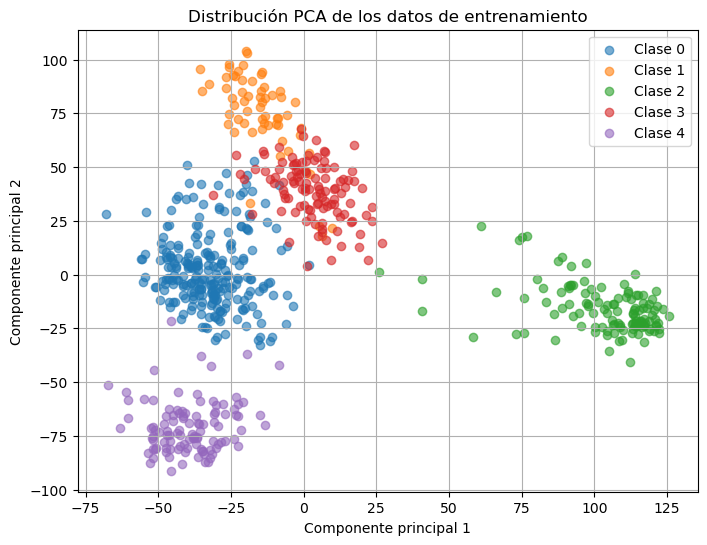

In [94]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Asegura que train_y sea 1D
if train_y.ndim == 2:
    if train_y.shape[1] == 1:
        train_y = train_y.ravel()
    else:
        train_y = train_y.argmax(axis=1)

# PCA a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_x)

# Graficar
plt.figure(figsize=(8, 6))
for label in np.unique(train_y):
    idx = train_y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Clase {label}', alpha=0.6)

plt.title("Distribución PCA de los datos de entrenamiento")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from sklearn.ensemble import RandomForestClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    print(i)
    model = RandomForestClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    
    model = RidgeClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    model = MLPClassifier()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)

    l_mlp.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    break
    
print("RandomForestClassifier: ", np.round(100* np.mean(l_rf),2), " +- ", np.round(100* np.std(l_rf),2))
print("RidgeClassifier: ", np.round(100* np.mean(l_lm),2), " +- ", np.round(100*np.std(l_lm),2))
print("MLPClassifier: ", np.round(100* np.mean(l_mlp),2), " +- ", np.round(100*np.std(l_mlp),2))


0
RandomForestClassifier:  98.76  +-  0.0
RidgeClassifier:  100.0  +-  0.0
MLPClassifier:  100.0  +-  0.0


In [63]:
import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score, matthews_corrcoef, confusion_matrix

def calcular_metricas_desbalanceadas(y_true_one_hot: np.ndarray, y_pred_one_hot: np.ndarray):
    """
    Calcula y muestra métricas de clasificación para datos desbalanceados
    a partir de matrices one-hot.

    Args:
        y_true_one_hot (np.ndarray): Matriz one-hot con las etiquetas verdaderas.
        y_pred_one_hot (np.ndarray): Matriz one-hot con las predicciones del modelo.
    """
    # 1. Convertir las matrices one-hot a formato de etiqueta (array 1D)
    #    np.argmax encuentra el índice del valor máximo en cada fila,
    #    que corresponde a la clase predicha.
    y_true_labels = np.argmax(y_true_one_hot, axis=1)
    y_pred_labels = np.argmax(y_pred_one_hot, axis=1)

    # Nombres de las clases (ej. 'Clase 0', 'Clase 1', ...)
    class_names = [f"Clase {i}" for i in range(y_true_one_hot.shape[1])]

    print("="*60)
    print("MÉTRICAS DE CLASIFICACIÓN PARA DATOS DESBALANCEADOS")
    print("="*60)

    # 2. Calcular y mostrar la Matriz de Confusión
    #    Esencial para ver qué clases se confunden entre sí.
    print("\n## Matriz de Confusión ##\n")
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
    print(conf_matrix)
    print("\n(Filas: Valores Reales, Columnas: Predicciones)")
    print("-" * 60)

    # 3. Calcular y mostrar el Reporte de Clasificación
    #    Incluye precisión, recall y f1-score por clase.
    #    'macro avg' y 'weighted avg' son claves en datos desbalanceados.
    print("\n## Reporte de Clasificación ##\n")
    report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)
    print(report)
    print("-" * 60)

    # 4. Calcular la Exactitud Balanceada (Balanced Accuracy)
    #    Es el promedio del recall de cada clase. Penaliza si el modelo
    #    ignora las clases minoritarias.
    balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
    print(f"\n## Exactitud Balanceada (Balanced Accuracy) ##\n")
    print(f"{balanced_acc:.4f}  (Ideal: 1.0, Aleatorio: 1/num_clases)")
    print("-" * 60)

    # 5. Calcular el Coeficiente de Correlación de Matthews (MCC)
    #    Considerada una de las métricas más completas para clasificación binaria y multiclase.
    #    Valores: +1 (perfecto), 0 (aleatorio), -1 (pésimo).
    mcc = matthews_corrcoef(y_true_labels, y_pred_labels)
    print(f"\n## Coeficiente de Correlación de Matthews (MCC) ##\n")
    print(f"{mcc:.4f}  (Rango: de -1 a +1)")
    print("="*60)



# Llamar a la función con los datos de ejemplo
calcular_metricas_desbalanceadas(test_y, y_pred)


MÉTRICAS DE CLASIFICACIÓN PARA DATOS DESBALANCEADOS

## Matriz de Confusión ##

[[61  0  0  0  0]
 [ 0 17  0  0  0]
 [ 0  0 25  0  0]
 [ 1  0  0 28  0]
 [ 0  0  0  0 29]]

(Filas: Valores Reales, Columnas: Predicciones)
------------------------------------------------------------

## Reporte de Clasificación ##

              precision    recall  f1-score   support

     Clase 0       0.98      1.00      0.99        61
     Clase 1       1.00      1.00      1.00        17
     Clase 2       1.00      1.00      1.00        25
     Clase 3       1.00      0.97      0.98        29
     Clase 4       1.00      1.00      1.00        29

    accuracy                           0.99       161
   macro avg       1.00      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161

------------------------------------------------------------

## Exactitud Balanceada (Balanced Accuracy) ##

0.9931  (Ideal: 1.0, Aleatorio: 1/num_clases)
-----------------------------------------

#### Arcene

In [12]:
# Abre el archivo .dat y ajusta el formato de los atributos
with open('arcene/ARCENE/arcene_train.data', 'r') as file:
    lines = file.readlines()
    
# Procesa cada línea, convirtiendo los elementos en números flotantes
data = [list(map(float, line.strip().split())) for line in lines]

# Convierte la lista de listas en un DataFrame
df = pd.DataFrame(data)

# Muestra las primeras filas del DataFrame para verificar
print(df.head())
with open('arcene/ARCENE/arcene_train.labels', 'r') as file:
    lines = file.readlines()
    
    
# Procesa cada línea, convirtiendo los elementos en números flotantes
data = [list(map(float, line.strip().split())) for line in lines]

# Convierte la lista de listas en un DataFrame
df_y = pd.DataFrame(data)

# Muestra las primeras filas del DataFrame para verificar
print(df_y.head())

    0     1      2      3     4      5      6     7     8     9     ...  \
0    0.0  71.0    0.0   95.0   0.0  538.0  404.0  20.0   0.0   0.0  ...   
1    0.0  41.0   82.0  165.0  60.0  554.0  379.0   0.0  71.0   0.0  ...   
2    0.0   0.0    1.0   40.0   0.0  451.0  402.0   0.0   0.0   0.0  ...   
3    0.0  56.0   44.0  275.0  14.0  511.0  470.0   0.0   0.0   0.0  ...   
4  105.0   0.0  141.0  348.0   0.0  268.0  329.0   0.0   0.0   1.0  ...   

    9990   9991  9992  9993   9994   9995   9996  9997   9998   9999  
0  255.0  570.0  86.0   0.0   36.0    0.0   80.0   0.0    0.0  524.0  
1  213.0  605.0  69.0   7.0  473.0    0.0   57.0   0.0  284.0  423.0  
2  235.0  593.0  28.0   0.0   24.0    0.0   90.0   0.0   34.0  508.0  
3   91.0  600.0   0.0  26.0   86.0    0.0  102.0   0.0    0.0  469.0  
4  813.0    0.0   0.0   0.0    0.0  190.0  301.0   0.0    0.0  354.0  

[5 rows x 10000 columns]
     0
0  1.0
1 -1.0
2  1.0
3  1.0
4 -1.0


In [13]:
train_x, test_x,y_train,y_test = train_test_split(df,df_y ,train_size=0.8, random_state=42)

In [14]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Reshape y_train and y_test to be 2D arrays (required for OneHotEncoder)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Perform one-hot encoding
train_y = onehot_encoder.fit_transform(y_train_reshaped)
test_y = onehot_encoder.transform(y_test_reshaped)
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) 

print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(80, 10000) (80, 2) (20, 10000) (20, 2)


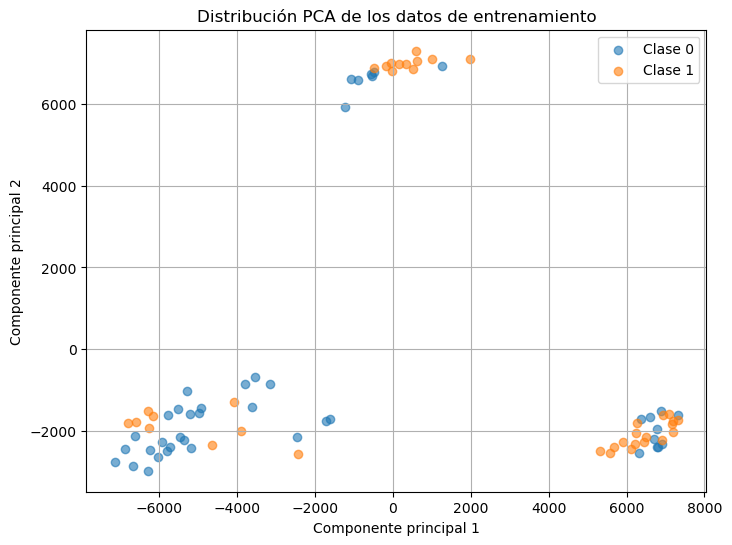

In [49]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Asegura que train_y sea 1D
if train_y.ndim == 2:
    if train_y.shape[1] == 1:
        train_y = train_y.ravel()
    else:
        train_y = train_y.argmax(axis=1)

# PCA a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_x)

# Graficar
plt.figure(figsize=(8, 6))
for label in np.unique(train_y):
    idx = train_y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Clase {label}', alpha=0.6)

plt.title("Distribución PCA de los datos de entrenamiento")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()


In [38]:
from sklearn.ensemble import RandomForestClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    print(i)
    model = RandomForestClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    
    model = RidgeClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    model = MLPClassifier()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)

    l_mlp.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    break
    
print("RandomForestClassifier: ", np.round(100* np.mean(l_rf),2), " +- ", np.round(100* np.std(l_rf),2))
print("RidgeClassifier: ", np.round(100* np.mean(l_lm),2), " +- ", np.round(100*np.std(l_lm),2))
print("MLPClassifier: ", np.round(100* np.mean(l_mlp),2), " +- ", np.round(100*np.std(l_mlp),2))

0
RandomForestClassifier:  65.44  +-  0.0
RidgeClassifier:  80.42  +-  0.0
MLPClassifier:  65.81  +-  0.0


In [51]:
(65.44+80.42+65.81)/3

70.55666666666667

#### p53

In [182]:
import pandas as pd
import numpy as np

# Abre el archivo y lee todas las líneas
file_path = "p53+mutants/p53_new_2012/Data Sets/K9.data"
try:
    with open(file_path, 'r') as file:
        lines = file.readlines()
except FileNotFoundError:
    print(f"Error: El archivo no se encuentra en la ruta especificada: {file_path}")
    # Puedes manejar el error como prefieras, por ejemplo, saliendo del programa
    exit()

# Creamos listas para los atributos (features) y las etiquetas (labels)
features = []
labels = []

# Procesamos cada línea una sola vez para evitar desajustes
for line in lines:
    line = line.strip()
    if not line:  # Ignora líneas vacías
        continue
    
    try:
        # Reemplaza las comas por espacios para facilitar el split
        parts = line.replace(",", " ").split()
        
        # El último elemento es la etiqueta (label)
        label = parts[-1]
        
        # El resto de los elementos son los atributos, convertidos a float
        feature_values = [float(x) for x in parts[:-1]]
        
        features.append(feature_values)
        labels.append(label)
    except (ValueError, IndexError) as e:
        # Manejo de errores para líneas con formato incorrecto
        print(f"Advertencia: Se omitió una línea con formato incorrecto: '{line}'. Error: {e}")
        continue

# Convertimos las listas a DataFrames de pandas
df = pd.DataFrame(features)
df_y = pd.DataFrame(labels, columns=['label'])

# Ahora ambos DataFrames tienen la misma longitud e índices
print("Dimensiones de df (atributos):", df.shape)
print("Dimensiones de df_y (etiquetas):", df_y.shape)
print("Índice máximo de df_y:", np.max(df_y.index))
print("Índice máximo de df:", np.max(df.index))
print("---")

# 1. Obtener los índices de las clases
inactive_indices = df_y[df_y['label'] == 'inactive'].index
active_indices = df_y[df_y['label'] == 'active'].index

# 2. Calcular la cantidad de muestras a seleccionar
num_active = len(active_indices)
num_inactive_to_sample = num_active * 2

# 3. Muestrear los índices de 'inactive' de forma segura
if len(inactive_indices) < num_inactive_to_sample:
    print("Error: No hay suficientes muestras 'inactive' para el muestreo.")
    exit()

np.random.seed(40)  # Para garantizar la reproducibilidad
inactive_sampled_indices = np.random.choice(
    inactive_indices,
    size=num_inactive_to_sample,
    replace=False
)

# 4. Combinar los índices seleccionados
selected_indices = np.concatenate([inactive_sampled_indices, active_indices])

# 5. Barajar los índices combinados para evitar sesgos
np.random.shuffle(selected_indices)

# 6. Filtrar el dataset completo (df) y las etiquetas (df_y)
df_simplified = df.loc[selected_indices]
df_y_simplified = df_y.loc[selected_indices]

# Verificar los resultados
print("Dimensiones del dataset simplificado:", df_simplified.shape)
print("Dimensiones de las etiquetas simplificadas:", df_y_simplified.shape)
print("Conteo de clases en el dataset simplificado:")
print(df_y_simplified['label'].value_counts())

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Advertencia: Se omitió una línea con formato incorrecto: '?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,

Dimensiones de df (atributos): (31159, 5408)
Dimensiones de df_y (etiquetas): (31159, 1)
Índice máximo de df_y: 31158
Índice máximo de df: 31158
---
Dimensiones del dataset simplificado: (453, 5408)
Dimensiones de las etiquetas simplificadas: (453, 1)
Conteo de clases en el dataset simplificado:
inactive    302
active      151
Name: label, dtype: int64


In [185]:
df_simplified.to_csv("p53.csv")

In [186]:
df_y_simplified.to_csv("p53_y.csv")

In [6]:
df= pd.read_csv("p53.csv").iloc[:,1:]
df_y= pd.read_csv("p53_y.csv").iloc[:,1:]
train_x, test_x,y_train,y_test = train_test_split(df,df_y ,train_size=0.8, random_state=42)

In [7]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Reshape y_train and y_test to be 2D arrays (required for OneHotEncoder)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Perform one-hot encoding
train_y = onehot_encoder.fit_transform(y_train_reshaped)
test_y = onehot_encoder.transform(y_test_reshaped)
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x) 
print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(362, 5408) (362, 2) (91, 5408) (91, 2)


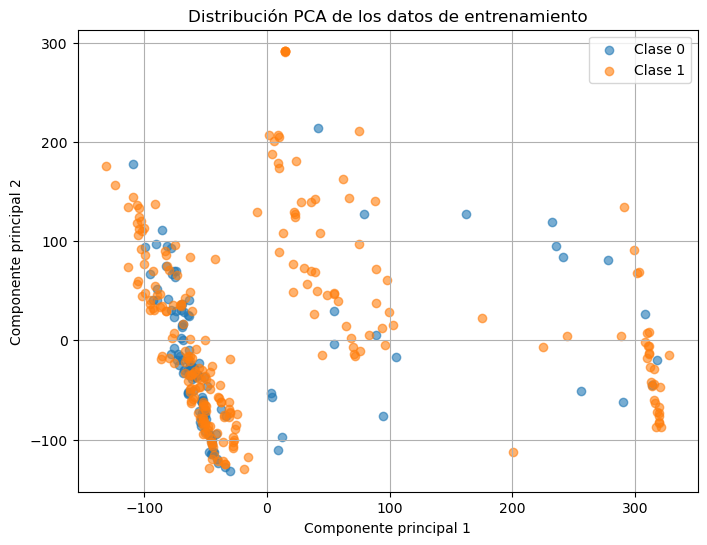

In [54]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Asegura que train_y sea 1D
if train_y.ndim == 2:
    if train_y.shape[1] == 1:
        train_y = train_y.ravel()
    else:
        train_y = train_y.argmax(axis=1)

# PCA a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_x)

# Graficar
plt.figure(figsize=(8, 6))
for label in np.unique(train_y):
    idx = train_y == label
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f'Clase {label}', alpha=0.6)

plt.title("Distribución PCA de los datos de entrenamiento")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
from sklearn.ensemble import RandomForestClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    print(i)
    model = RandomForestClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    
    model = RidgeClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    model = MLPClassifier()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)

    l_mlp.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    break
    
print("RandomForestClassifier: ", np.round(100* np.mean(l_rf),2), " +- ", np.round(100* np.std(l_rf),2))
print("RidgeClassifier: ", np.round(100* np.mean(l_lm),2), " +- ", np.round(100*np.std(l_lm),2))
print("MLPClassifier: ", np.round(100* np.mean(l_mlp),2), " +- ", np.round(100*np.std(l_mlp),2))

0
RandomForestClassifier:  97.82  +-  0.0
RidgeClassifier:  90.21  +-  0.0
MLPClassifier:  90.26  +-  0.0


In [80]:
(97.82+90.21+90.26)/3

92.76333333333332

#### mortgage

In [361]:
import re
import arff
import pandas as pd

# Abre el archivo .dat y ajusta el formato de los atributos
with open('mortgage.dat', 'r') as file:
    lines = file.readlines()

# Procesar las líneas para eliminar los rangos de los atributos
processed_lines = []
for line in lines:
    # Elimina rangos como "[36.7,105.0]"
    processed_line = re.sub(r'\[.*?\]', '', line)
    processed_lines.append(processed_line)

# Une las líneas procesadas en un solo texto
processed_data = ''.join(processed_lines)

# Guarda los datos procesados temporalmente en un nuevo archivo .arff
with open('archivo_procesado.arff', 'w') as file:
    file.write(processed_data)

# Cargar el archivo procesado usando el paquete arff
with open('archivo_procesado.arff', 'r') as file:
    data = arff.load(file)

# Convertir los datos a un DataFrame
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])



In [362]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import normalize
# Supongamos que ya tienes el DataFrame cargado en 'df'
# Definir tamaños específicos para train y test
train_size = 699
test_size = 350

# Dividir los datos
train_x, test_x,train_y,test_y = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], train_size=train_size, test_size=test_size, random_state=42)
train_x, test_x= train_x.values, test_x.values
train_y,test_y= train_y.values.reshape(-1,1),test_y.values.reshape(-1,1)

#scaler = RobustScaler() #MinMaxScaler(feature_range=(-1, 1)) #StandardScaler(feature_range=(0, 1)) #StandardScaler()
train_x = np.log1p(train_x) #scaler.fit_transform(train_x)
test_x = np.log1p(test_x) #scaler.transform(test_x)

scaler_y =MinMaxScaler(feature_range=(0, 1))
train_y= scaler_y.fit_transform(train_y)
test_y= scaler_y.transform(test_y)

print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(699, 15) (699, 1) (350, 15) (350, 1)


#### izmir

In [3]:
!pip show arff

In [2]:
import re
import arff
import pandas as pd

# Abre el archivo .dat y ajusta el formato de los atributos
with open('wizmir.dat', 'r') as file:
    lines = file.readlines()

# Procesar las líneas para eliminar los rangos de los atributos
processed_lines = []
for line in lines:
    # Elimina rangos como "[36.7,105.0]"
    processed_line = re.sub(r'\[.*?\]', '', line)
    processed_lines.append(processed_line)

# Une las líneas procesadas en un solo texto
processed_data = ''.join(processed_lines)

# Guarda los datos procesados temporalmente en un nuevo archivo .arff
with open('archivo_procesado.arff', 'w') as file:
    file.write(processed_data)

# Cargar el archivo procesado usando el paquete arff
with open('archivo_procesado.arff', 'r') as file:
    data = arff.load(file)

# Convertir los datos a un DataFrame
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])




In [5]:
df.to_csv("izmir_df.csv", index=False)

In [27]:
from sklearn.model_selection import train_test_split

# Supongamos que ya tienes el DataFrame cargado en 'df'
# Definir tamaños específicos para train y test
train_size = 974
test_size = 487

# Dividir los datos
train_x, test_x,train_y,test_y = train_test_split(df.iloc[:,:-1],df.iloc[:,-1], train_size=train_size, test_size=test_size, random_state=42)
train_x, test_x= train_x.values, test_x.values
train_y,test_y= train_y.values.reshape(-1,1),test_y.values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0, 1)) #StandardScaler() #StandardScaler(feature_range=(0, 1)) #StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

scaler_y = MinMaxScaler(feature_range=(0, 1)) #StandardScaler()
train_y= scaler_y.fit_transform(train_y)
test_y= scaler_y.transform(test_y)

print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(974, 9) (974, 1) (487, 9) (487, 1)


In [28]:
from sklearn.ensemble import RandomForestRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.htmlfrom sklearn.linear_model import RidgeClassifier

from sklearn.linear_model import Ridge
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.neural_network import MLPRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    print(i)
    model = RandomForestRegressor()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
    
    model = Ridge(solver="saga",random_state=i)
    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
    model = MLPRegressor()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    l_mlp.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
print("RandomForestRegressor: ", np.round(np.min(l_rf),5), np.round(np.mean(l_rf),4), " +- ", np.round(np.std(l_rf),4) )
print("Ridge: ", np.round(np.min(l_lm),5),np.round(np.mean(l_lm),4), " +- ", np.round(np.std(l_lm),4) )
print("MLPRegressor: ", np.round(np.min(l_mlp),5), np.round(np.mean(l_mlp),4), " +- ", np.round(np.std(l_mlp),4) )

0


C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


1


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


2


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


3


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


4


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


5


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


6


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


7


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


8


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


9
RandomForestRegressor:  0.02167 0.0219  +-  0.0001
Ridge:  0.02092 0.0209  +-  0.0
MLPRegressor:  0.0298 0.0354  +-  0.0044


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Isolet

https://jundongl.github.io/scikit-feature/datasets.html

In [27]:
import scipy.io

# Load the .mat file
mat = scipy.io.loadmat('Isolet.mat')


In [28]:
# Assuming 'gnd' contains the class labels and 'fea' contains the features
labels = mat['Y'].flatten()  # Flatten the labels array if it's 2D
features = mat['X']

In [32]:
np.save("isolet_features.npy",features)

In [33]:
np.save("isolet_labels.npy",labels)

In [23]:
train_x, test_x,y_train,y_test = train_test_split(features,labels ,train_size=1092, random_state=42)


In [24]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Reshape y_train and y_test to be 2D arrays (required for OneHotEncoder)
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Perform one-hot encoding
train_y = onehot_encoder.fit_transform(y_train_reshaped)
test_y = onehot_encoder.transform(y_test_reshaped)

print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(1092, 617) (1092, 26) (468, 617) (468, 26)


C:\Users\mario\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
from sklearn.ensemble import RandomForestClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    model = RandomForestClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    
    model = RidgeClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    model = MLPClassifier()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)

    l_mlp.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
print("RandomForestClassifier: ", np.round(100* np.mean(l_rf),2), " +- ", np.round(100* np.std(l_rf),2))
print("RidgeClassifier: ", np.round(100* np.mean(l_lm),2), " +- ", np.round(100*np.std(l_lm),2))
print("MLPClassifier: ", np.round(100* np.mean(l_mlp),2), " +- ", np.round(100*np.std(l_mlp),2))

C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multi

RandomForestClassifier:  80.72  +-  0.67
RidgeClassifier:  83.63  +-  0.0
MLPClassifier:  91.24  +-  0.68


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### mnist

In [7]:
''' For Keras dataset_load()'''
import tensorflow.keras as keras
(traindata_o, trainlabel), (testdata_o, testlabel) = keras.datasets.mnist.load_data()
traindata_o = traindata_o.reshape(traindata_o.shape[0], 28*28).astype('float64')/255
trainlabel = keras.utils.to_categorical(trainlabel, 10)
testdata_o = testdata_o.reshape(testdata_o.shape[0], 28*28).astype('float64')/255
testlabel = keras.utils.to_categorical(testlabel, 10)
print(traindata_o.shape, trainlabel.shape, testdata_o.shape, testlabel.shape )

#scaler = StandardScaler()
#traindata = scaler.fit_transform(traindata_o)
#if task== "regression":
#        scaler_y = StandardScaler()
#        self.train_y= scaler_y.fit_transform(self.train_y)
#        self.test_y= scaler_y.fit_transform(self.test_y)
#inference process
#testdata = scaler.transform(testdata_o)
        
test_x, test_y=np.asarray(testdata_o),np.asarray(testlabel)
train_x, train_y = np.asarray(traindata_o),np.asarray(trainlabel)

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [6]:
from sklearn.ensemble import RandomForestClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    model = RandomForestClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    
    model = RidgeClassifier()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
    model = MLPClassifier()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)

    l_mlp.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
print("RandomForestClassifier: ", np.round(100* np.mean(l_rf),2), " +- ", np.round(100* np.std(l_rf),2))
print("RidgeClassifier: ", np.round(100* np.mean(l_lm),2), " +- ", np.round(100*np.std(l_lm),2))
print("MLPClassifier: ", np.round(100* np.mean(l_mlp),2), " +- ", np.round(100*np.std(l_mlp),2))

C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")

KeyboardInterrupt



In [36]:
from sklearn.ensemble import RandomForestClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
l_rf,l_lm,l_mlp=[],[],[]


model = RandomForestClassifier()

# Entrenar el modelo
model.fit(train_x, train_y)
# Predecir con el modelo entrenado
y_pred = model.predict(test_x)
l_rf.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])

    
print("RandomForestClassifier: ", np.round(100* np.mean(l_rf),2), " +- ", np.round(100* np.std(l_rf),2))


RandomForestClassifier:  91.78  +-  0.0


1m 24.0s

In [45]:
((60+24)*10)/60

14.0

In [37]:
from sklearn.ensemble import RandomForestClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
from sklearn.neural_network import MLPClassifier
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
l_rf,l_lm,l_mlp=[],[],[]

model = MLPClassifier()
model.fit(train_x, train_y)
y_pred = model.predict(test_x)

l_mlp.append(show_accuracy(y_pred,test_y, "classification")["F1 Score"])
    
print("MLPClassifier: ", np.round(100* np.mean(l_mlp),2), " +- ", np.round(100*np.std(l_mlp),2))

MLPClassifier:  96.55  +-  0.0


1m 28.0s

In [44]:
((60+28)*10)/60

14.666666666666666

SBLS 4.0 min CPU
RF  14.0 min CPU
MLP 14.7 min CPU
TabM 24.0 min GPU 


CPU:  Hardware Summary:
  CPU Model: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
  Cores / Threads: 4 / 8
  Base Clock Speed: 0.00 GHz
  RAM: 15.7 GB
  
GPU: GPU 0:
  Model: Tesla T4
  Memory: 15360 MB
  Driver Version: 550.54.15
  Compute Capability: 7.5

#### norb

In [16]:
train_x=np.load("train_norb_data.npy", mmap_mode='r')[:,:,:,:2]
print(train_x.shape)
#train_x= np.mean(train_x, axis=3)
print(train_x.shape)
train_x= train_x.reshape(train_x.shape[0], 96*96*2).astype('float64')/255

(24300, 96, 96, 2)
(24300, 96, 96, 2)


In [17]:
test_x=np.load("test_norb_data.npy", mmap_mode='r')[:,:,:,:2]
#test_x= np.mean(test_x, axis=3)
test_x= test_x.reshape(test_x.shape[0], 96*96*2).astype('float64')/255

In [18]:
train_y=np.load("train_norb_data_y.npy", mmap_mode='r')
test_y=np.load("test_norb_data_y.npy", mmap_mode='r')


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
train_y= enc.fit_transform(train_y.reshape(-1,1)).toarray() 
test_y= enc.transform(test_y.reshape(-1,1)).toarray() 
print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(24300, 18432) (24300, 5) (24300, 18432) (24300, 5)


train_x, train_y=np.load("train_norb.npy", mmap_mode='r'),np.load("train_norb_data_y.npy", mmap_mode='r')
test_x, test_y=np.load("test_norb.npy", mmap_mode='r'),np.load("test_norb_data_y.npy", mmap_mode='r')
train_x = train_x.astype(np.float32)  # or another smaller dtype
train_y = train_y.astype(np.float32)  # or another smaller dtype
test_x = test_x.astype(np.float32)  # or another smaller dtype
test_y = test_y.astype(np.float32)  # or another smaller dtype

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
train_y= enc.fit_transform(train_y.reshape(-1,1)).toarray() 
test_y= enc.transform(test_y.reshape(-1,1)).toarray() 
print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

In [19]:
print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(24300, 18432) (24300, 5) (24300, 18432) (24300, 5)


#### c housing

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

# Load the dataset
california_housing = fetch_california_housing()
X, y = california_housing.data, california_housing.target

# Split the dataset into training and test sets
traindata_o, testdata_o, trainlabel_o, testlabel_o = train_test_split(X, y, test_size=0.5, random_state=42)

scaler = MinMaxScaler(feature_range=(0, 1))#StandardScaler()
traindata = scaler.fit_transform(traindata_o)

scaler_y = MinMaxScaler(feature_range=(0, 1)) #StandardScaler()
trainlabel= scaler_y.fit_transform(trainlabel_o.reshape(-1,1))
testlabel= scaler_y.transform(testlabel_o.reshape(-1,1))

testdata = scaler.transform(testdata_o)
test_x, test_y=np.asarray(testdata_o),np.asarray(trainlabel_o)
train_x, train_y = np.asarray(traindata_o),np.asarray(trainlabel_o)
test_y=test_y.reshape(-1,1)
train_y=train_y.reshape(-1,1)

In [162]:
test_y.shape

(10320,)

In [156]:
train_x.shape[0]+test_x.shape[0]

20640

In [153]:
test_x.shape

(4128, 8)

In [5]:
from keras.datasets import boston_housing
(traindata_o,trainlabel_o ), (testdata_o, testlabel_o)  =boston_housing.load_data()
testdata_o= np.concatenate([testdata_o,traindata_o[337:]],axis=0)
testlabel_o= np.concatenate([testlabel_o,trainlabel_o[337:]],axis=0)
traindata_o=traindata_o[:337]
trainlabel_o=trainlabel_o[:337]
scaler = MinMaxScaler(feature_range=(0, 1))
traindata = scaler.fit_transform(traindata_o)

scaler_y = MinMaxScaler(feature_range=(0, 1))
trainlabel= scaler_y.fit_transform(trainlabel_o.reshape(-1,1))
testlabel= scaler_y.transform(testlabel_o.reshape(-1,1))
testdata = scaler.transform(testdata_o)
test_x, test_y=np.asarray(testdata),np.asarray(testlabel)
train_x, train_y = np.asarray(traindata),np.asarray(trainlabel)

In [6]:
testdata_o.shape,testlabel_o.shape

((169, 13), (169,))

In [7]:
from sklearn.ensemble import RandomForestRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.htmlfrom sklearn.linear_model import RidgeClassifier

from sklearn.linear_model import Ridge
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.neural_network import MLPRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
l_rf,l_lm,l_mlp=[],[],[]

for i in range(1):
    print(i)
    model = RandomForestRegressor()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
    
    model = Ridge(solver="saga",random_state=i)
    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
    model = MLPRegressor()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    l_mlp.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
print("RandomForestRegressor: ", np.round(np.min(l_rf),5), np.round(np.mean(l_rf),4), " +- ", np.round(np.std(l_rf),4) )
print("Ridge: ", np.round(np.min(l_lm),5),np.round(np.mean(l_lm),4), " +- ", np.round(np.std(l_lm),4) )
print("MLPRegressor: ", np.round(np.min(l_mlp),5), np.round(np.mean(l_mlp),4), " +- ", np.round(np.std(l_mlp),4) )

0


C:\Users\mario\AppData\Local\Temp\ipykernel_10152\193899680.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


RandomForestRegressor:  0.07641 0.0764  +-  0.0
Ridge:  0.10701 0.107  +-  0.0
MLPRegressor:  0.10949 0.1095  +-  0.0


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
y_true=  [[0.04888889],
 [0.30666667],
 [0.31111112],
 [0.4888889 ],
 [0.38222224],
 [0.43333334],
 [0.5822222 ],
 [0.39777777],
 [0.34444445],
 [0.40444446]]
y_pred=[0.11056776, 0.26854086, 0.3232432,  0.57108676, 0.3691954,  0.29262733,
 0.52276415, 0.37215066, 0.25611845, 0.32309502]
print( mean_squared_error(y_true, y_pred, squared=False))

0.07123246303330588


In [24]:
 mean_squared_error(y_true, y_pred)#**0.5

0.00507406378979129

In [25]:
0.005**0.5

0.07071067811865475

In [13]:
test_y[:10]

array([[0.04888889],
       [0.30666667],
       [0.31111111],
       [0.48888889],
       [0.38222222],
       [0.43333333],
       [0.58222222],
       [0.39777778],
       [0.34444444],
       [0.40444444]])

In [14]:
y_pred[:10]

array([0.06974405, 0.33806874, 0.36979119, 0.51229632, 0.45405533,
       0.3328917 , 0.52353114, 0.43677101, 0.28081968, 0.37557269])

In [86]:
from sklearn.ensemble import RandomForestRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.htmlfrom sklearn.linear_model import RidgeClassifier

from sklearn.linear_model import Ridge
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.neural_network import MLPRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    print(i)
    model = RandomForestRegressor()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
    
    model = Ridge(solver="saga",random_state=i)
    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
    model = MLPRegressor()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    l_mlp.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
print("RandomForestRegressor: ", np.round(np.min(l_rf),5), np.round(np.mean(l_rf),4), " +- ", np.round(np.std(l_rf),4) )
print("Ridge: ", np.round(np.min(l_lm),5),np.round(np.mean(l_lm),4), " +- ", np.round(np.std(l_lm),4) )
print("MLPRegressor: ", np.round(np.min(l_mlp),5), np.round(np.mean(l_mlp),4), " +- ", np.round(np.std(l_mlp),4) )

0


C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


1


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


2


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


3


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


4


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


5


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


6


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


7


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


8


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_20632\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


9
RandomForestRegressor:  0.07576 0.0768  +-  0.0005
Ridge:  0.10701 0.107  +-  0.0
MLPRegressor:  0.10604 0.1137  +-  0.0062


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### abalone

In [29]:
abalone= pd.read_csv("abalone.csv")

# Data (as pandas DataFrames)
X = abalone.iloc[:,:-1]
y = abalone["Rings"]

# Because RMSLE score, we make a conversion like below:
y_log = y #np.log(1 + y)
y_train=y_log.iloc[:2784]
y_test=y_log.iloc[2784:]

# Add the end for getting the result back to original like below:
# y = np.exp(y_log) - 1

# Dummy data for train and test (for demonstration)
train = pd.DataFrame(X.iloc[:2784,:], columns=X.columns)
train['Sex'] = np.random.choice(['M', 'F', 'I'], size=len(train))

test = pd.DataFrame(X.iloc[2784:,:], columns=X.columns)
test['Sex'] = np.random.choice(['M', 'F', 'I'], size=len(test))

# OneHotEncoding the 'Sex' column for both train and test datasets
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_encoded = pd.concat([
                    train.iloc[:, 1:].reset_index(drop=True),  # Exclude the original 'Sex' column
                    pd.DataFrame(encoder.fit_transform(train[['Sex']]).astype('int'), 
                                 columns=encoder.categories_[0])
                    ], 
                    axis=1
                )

test_encoded = pd.concat([
                    test.iloc[:, 1:].reset_index(drop=True),  # Exclude the original 'Sex' column
                    pd.DataFrame(encoder.transform(test[['Sex']]).astype('int'), 
                                 columns=encoder.categories_[0]) ], 
                    axis=1
                )

# Now, 'train_encoded' and 'test_encoded' contain the encoded 'Sex' column.

def log_transformation(data, columns):
    for column in columns:
        positive_values = data[column] - data[column].min() + 1
        data[f'{column}_log'] = np.log(positive_values)
    return data


if False:
    train = log_transformation(train_encoded, ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight','Viscera_weight', 'Shell_weight'])
    test  = log_transformation(test_encoded, ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight','Viscera_weight', 'Shell_weight'])

In [30]:
test_x, test_y=np.asarray(test_encoded),np.asarray(y_test)
train_x, train_y = np.asarray(train_encoded),np.asarray(y_train)

scaler = MinMaxScaler(feature_range=(0, 1)) #StandardScaler()
traindata = scaler.fit_transform(train_x)

scaler_y = MinMaxScaler(feature_range=(0, 1)) #StandardScaler()
trainlabel= scaler_y.fit_transform(train_y.reshape(-1,1))
testlabel= scaler_y.transform(test_y.reshape(-1,1))

testdata = scaler.transform(test_x)
test_x, test_y=np.asarray(testdata),np.asarray(testlabel)
train_x, train_y = np.asarray(traindata),np.asarray(trainlabel)

In [31]:
print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(2784, 10) (2784, 1) (1393, 10) (1393, 1)


In [32]:
from sklearn.ensemble import RandomForestRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.htmlfrom sklearn.linear_model import RidgeClassifier

from sklearn.linear_model import Ridge
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.neural_network import MLPRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
l_rf,l_lm,l_mlp=[],[],[]

for i in range(10):
    print(i)
    model = RandomForestRegressor()

    # Entrenar el modelo
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    l_rf.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
    
    model = Ridge(solver="saga",random_state=i)
    # Entrenar el modelo
    model.fit(train_x, train_y)
    # Predecir con el modelo entrenado
    y_pred = model.predict(test_x)
    l_lm.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
    model = MLPRegressor()
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    l_mlp.append(show_accuracy(y_pred,test_y, "regression")["RMSE"])
    
print("RandomForestRegressor: ", np.round(np.min(l_rf),5), np.round(np.mean(l_rf),4), " +- ", np.round(np.std(l_rf),4) )
print("Ridge: ", np.round(np.min(l_lm),5),np.round(np.mean(l_lm),4), " +- ", np.round(np.std(l_lm),4) )
print("MLPRegressor: ", np.round(np.min(l_mlp),5), np.round(np.mean(l_mlp),4), " +- ", np.round(np.std(l_mlp),4) )

0


C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)
C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


1


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


2


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


3


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


4


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


5


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


6


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


7


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


8


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


9


C:\Users\mario\AppData\Local\Temp\ipykernel_15564\4148565275.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


RandomForestRegressor:  0.07296 0.0735  +-  0.0003
Ridge:  0.07385 0.0738  +-  0.0
MLPRegressor:  0.07305 0.0748  +-  0.0013


C:\Users\mario\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### yale

https://github.com/mahdiabavisani/Deep-multimodal-subspace-clustering-networks

In [21]:
import scipy.io

# Load the .mat file
mat = scipy.io.loadmat('YaleB_32x32.mat')

# Display the contents of the file
print(mat)


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Wed Jun 13 16:18:43 2007', '__version__': '1.0', '__globals__': [], 'fea': array([[ 82,  81,  72, ...,  35,  33,  22],
       [ 86,  86,  74, ...,  20,  14,   9],
       [ 76,  88,  80, ...,   9,   6,   6],
       ...,
       [  3,   3,   3, ..., 200, 202, 192],
       [  3,   3,   3, ..., 253, 255, 250],
       [  5,   3,   4, ..., 174, 175, 179]], dtype=uint8), 'gnd': array([[ 1],
       [ 1],
       [ 1],
       ...,
       [38],
       [38],
       [38]], dtype=uint8)}


In [26]:
mat["gnd"].shape

(2414, 1)

In [23]:
mat["fea"].shape

(2414, 1024)

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'gnd' contains the class labels and 'fea' contains the features
labels = mat['gnd'].flatten()  # Flatten the labels array if it's 2D
features = mat['fea']

# Number of classes and desired number of features per class for training
n_classes = 38
n_train_per_class = 30

# Prepare lists to store train and test indices
train_indices = []
test_indices = []

# Loop through each class and split the features
for class_label in np.unique(labels):
    # Get the indices of all examples belonging to the current class
    class_indices = np.where(labels == class_label)[0]

    # Select 30 examples for training and the rest for testing
    class_train_idx, class_test_idx = train_test_split(class_indices, train_size=n_train_per_class, random_state=42)
    
    # Append the indices to the respective lists
    train_indices.extend(class_train_idx)
    test_indices.extend(class_test_idx)

# Convert lists to numpy arrays for indexing
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

# Split the features and labels into train and test sets
train_x, test_x = features[train_indices]/255, features[test_indices]/255
y_train, y_test = labels[train_indices], labels[test_indices]


In [54]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Reshape y_train and y_test to be 2D arrays (required for OneHotEncoder)
y_train_reshaped = y_train.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Perform one-hot encoding
train_y = onehot_encoder.fit_transform(y_train_reshaped)
test_y = onehot_encoder.transform(y_test_reshaped)

print(train_x.shape, train_y.shape,test_x.shape, test_y.shape)

(1140, 1024) (1140, 38) (1274, 1024) (1274, 38)


C:\Users\mario\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### FULL ejecution

#### mortgage

In [363]:
times=10 #as classic paper
dataset= "mortgage"
dict_results={}
min_=10
for reg in [1E-3,1E-4,1E-5]:#,
 for d in [8]:
    for method in ["gaussian", "sigmoid","gelu","random"]: 
        print(method)
        testing,training=[],[]
        testing_t,training_t=[],[]
        for i in range(times):
            model= BLS( reg , d, 4, 17,sampling=[method,method],task= "regression", epsilon=1)
            (train_acc,train_time,w)=model.train(train_x,train_y)
            (test_acc,test_time,w)=model.inference(test_x,test_y)

            testing.append(test_acc)
            training.append(train_acc)
            testing_t.append(test_time)
            training_t.append(train_time)
            del model
        print("Tranining after "+str(times)+": ", np.mean([i[0][0]["RMSE"] for i in training]), " +- ", np.std([i[0][0]["RMSE"] for i in training]))
        print("testing after "+str(times)+": ", np.mean([i[0]["RMSE"] for i in testing]), " +- ", np.std([i[0]["RMSE"] for i in testing]))
        dict_results[method]= [training,testing,training_t,testing_t]    
        np.save(f'experiments/{method}/{dataset}/full_ejecution_4_17_{reg}_{d}.npy', dict_results)

    dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_4_17_{reg}_{d}.npy', allow_pickle=True).item()
    for method in ["gaussian", "sigmoid","gelu"]:
            print(method)
            dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_4_17_{reg}_{d}.npy', allow_pickle=True).item()
            # conduct the Wilcoxon-Signed Rank Test
            p_value= stats.wilcoxon([i[0]["RMSE"] for i in dict_results_r["random"][1]] , [i[0]["RMSE"] for i in dict_results[method][1]] ).pvalue
            if p_value<0.05:
                print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
            else:
                print("equal")

gaussian
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
Tranining after 10:  0.009713999999999999  +-  0.0005270901251209321
testing after 10:  0.012300000000000002  +-  0.0006193867935305044
sigmoid
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
Tranining after 10:  0.014094  +-  0.000572349543548346
testing after 10:  0.016806  +-  0.000560681727899171
gelu
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
dim: Z: 32  and H:  136
Tranining af

In [277]:
0.0277  +-  0.0012 #1E-8
0.0276  +-  0.001 #1E-7
0.0284  +-  0.0012 #1E-6

0.027200000000000002

In [366]:
dataset= "mortgage"#"mnist"
reg, d= 1E-4,8
times=10 #as classic paper
for method in ["gaussian", "sigmoid","gelu","random"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_4_17_{reg}_{d}.npy', allow_pickle=True).item()
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.round(np.mean([i[0]["RMSE"] for i in testing]),4), " +- ", np.round(np.std([i[0]["RMSE"] for i in testing]),4) )


gaussian
testing after 10:  0.0085  +-  0.0004
sigmoid
testing after 10:  0.0123  +-  0.0005
gelu
testing after 10:  0.0109  +-  0.0008
random
testing after 10:  0.0084  +-  0.0005


In [354]:
# Create data
import scipy.stats as stats
dataset= "mortgage"
reg, d= 1E-4,8
dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_5_17_{reg}_{d}.npy', allow_pickle=True).item()

for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_5_17_{reg}_{d}.npy', allow_pickle=True).item()
    # conduct the Wilcoxon-Signed Rank Test
    p_value= stats.wilcoxon([i[0]["RMSE"] for i in dict_results_r["random"][1]] , [i[0]["RMSE"] for i in dict_results[method][1]] ).pvalue
    if p_value<0.05:
        print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
    else:
        print("equal")

gaussian
equal
sigmoid
the true mean mpg is not equal between the two groups 0.002
gelu
the true mean mpg is not equal between the two groups 0.004


#### izmir

In [123]:
times=10 #as classic paper
dataset= "izmir"
dict_results={}
min_=10
for reg in [1E-5,1E-4,1E-3]:
 for d in [4]:
    for method in ["gaussian", "sigmoid","gelu","random"]: 
        print(method)
        testing,training=[],[]
        testing_t,training_t=[],[]
        for i in range(times):
            model= BLS( reg , d, 3, 22,sampling=[method,method],task= "regression", epsilon=1)
            (train_acc,train_time,w)=model.train(train_x,train_y)
            (test_acc,test_time,w)=model.inference(test_x,test_y)

            testing.append(test_acc)
            training.append(train_acc)
            testing_t.append(test_time)
            training_t.append(train_time)
            del model
        print("Tranining after "+str(times)+": ", np.mean([i[0][0]["RMSE"] for i in training]), " +- ", np.std([i[0][0]["RMSE"] for i in training]))
        print("testing after "+str(times)+": ", np.mean([i[0]["RMSE"] for i in testing]), " +- ", np.std([i[0]["RMSE"] for i in testing]))
        candidate= np.mean([i[0]["RMSE"] for i in testing]) - np.std([i[0]["RMSE"] for i in testing])
        if  candidate<min_:
            min_= candidate
            print(reg,d)
            
        dict_results[method]= [training,testing,training_t,testing_t]    
        np.save(f'experiments/{method}/{dataset}/full_ejecution_3_22_{reg}_{d}.npy', dict_results)
    dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_3_22_{reg}_{d}.npy', allow_pickle=True).item()

    for method in ["gaussian", "sigmoid","gelu"]:
            print(method)
            dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_3_22_{reg}_{d}.npy', allow_pickle=True).item()
            # conduct the Wilcoxon-Signed Rank Test
            p_value= stats.wilcoxon([i[0]["RMSE"] for i in dict_results_r["random"][1]] , [i[0]["RMSE"] for i in dict_results[method][1]] ).pvalue
            if p_value<0.05:
                print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
            else:
                print("equal")

gaussian
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
Tranining after 10:  0.017137999999999997  +-  0.00016023732399163463
testing after 10:  0.023126  +-  0.004661096866618415
sigmoid
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
Tranining after 10:  0.0177  +-  0.00010276186062932093
testing after 10:  0.019708  +-  0.001328629368936273
gelu
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
dim: Z: 12  and H:  88
Tranining after 10:  0.017573000000000002  +-  8.90000

In [219]:
0.0196  -  0.0013 #1E-5
0.0188  -  0.0004 #1E-4 min mean = the best
0.0193  -  0.0004 #1E-3

0.0189

In [14]:
dataset= "izmir"
reg, d= 1E-4,4
times=10 #as classic paper
for method in ["gaussian", "sigmoid","gelu","random"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_3_22_{reg}_{d}.npy', allow_pickle=True).item()
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.round(np.mean([i[0]["RMSE"] for i in testing]),4), " +- ", np.round(np.std([i[0]["RMSE"] for i in testing]),4) )
    print("testing after: ", np.round(np.min([i[0]["RMSE"] for i in testing]),4) )


gaussian
testing after 10:  0.0216  +-  0.0043
testing after:  0.018
sigmoid
testing after 10:  0.0188  +-  0.0004
testing after:  0.0184
gelu
testing after 10:  0.0202  +-  0.0022
testing after:  0.0181
random
testing after 10:  0.0203  +-  0.0022
testing after:  0.0185


In [192]:
# Create data
import scipy.stats as stats
dataset= "izmir"
reg, d= 1E-4,4
dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_3_22_{reg}_{d}.npy', allow_pickle=True).item()

for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_3_22_{reg}_{d}.npy', allow_pickle=True).item()
    # conduct the Wilcoxon-Signed Rank Test
    p_value= stats.wilcoxon([i[0]["RMSE"] for i in dict_results_r["random"][1]] , [i[0]["RMSE"] for i in dict_results[method][1]] ).pvalue
    if p_value<0.05:
        print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
    else:
        print("equal")

gaussian
equal
sigmoid
the true mean mpg is not equal between the two groups 0.014
gelu
equal


#### abalone

In [20]:
times=10 #as classic paper
dataset= "abalone"#"mnist"
dict_results={}
for reg in [1E-5,1E-4,1E-3]:
 for d in [6]:
    for method in ["gaussian", "sigmoid","gelu","random"]: 
        print(method)
        testing,training=[],[]
        testing_t,training_t=[],[]
        for i in range(times):
            model= BLS( reg , d, 5, 7,sampling=[method,method],task= "regression", epsilon=1)
            (train_acc,train_time,w)=model.train(train_x,train_y)
            (test_acc,test_time,w)=model.inference(test_x,test_y)

            testing.append(test_acc)
            training.append(train_acc)
            testing_t.append(test_time)
            training_t.append(train_time)
            del model
        print("Tranining after "+str(times)+": ", np.mean([i[0][0]["RMSE"] for i in training]), " +- ", np.std([i[0][0]["RMSE"] for i in training]))
        result_d=np.mean([i[0]["MAE"] for i in testing])
        print("testing after "+str(times)+": ", np.mean([i[0]["RMSE"] for i in testing]), " +- ", np.std([i[0]["RMSE"] for i in testing]))
        dict_results[method]= [training,testing,training_t,testing_t]
        print(d,result_d)
    
        np.save(f'experiments/{method}/{dataset}/full_ejecution_5_7_{reg}_{d}.npy', dict_results)
        
    dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_5_7_{reg}_{d}.npy', allow_pickle=True).item()

    for method in ["gaussian", "sigmoid","gelu"]:
            print(method)
            dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_5_7_{reg}_{d}.npy', allow_pickle=True).item()
            # conduct the Wilcoxon-Signed Rank Test
            p_value= stats.wilcoxon([i[0]["RMSE"] for i in dict_results_r["random"][1]] , [i[0]["RMSE"] for i in dict_results[method][1]] ).pvalue
            if p_value<0.05:
                print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
            else:
                print("equal")

gaussian
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
Tranining after 10:  0.072814  +-  0.001562384075699696
testing after 10:  0.116259  +-  0.016099009565808703
6 0.073579
sigmoid
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
Tranining after 10:  0.07494300000000001  +-  0.003255125343208768
testing after 10:  0.11317999999999999  +-  0.014822916717029747
6 0.07244500000000001
gelu
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
dim: Z: 30  and H:  42
Tranining aft

In [142]:
0.071  +-  0.001#1E-5
0.0708  +-  0.0002 #1E-4 min mean = the best
0.0718  +-  0.0002 #1E-3

0.07058490219470842

In [19]:
dataset= "abalone"#"mnist"
reg, d= 1E-4,6
times=10 #as classic paper
for method in ["gaussian", "sigmoid","gelu","random"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_5_7_{reg}_{d}.npy', allow_pickle=True).item()
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.round(np.mean([i[0]["RMSE"] for i in testing]),4), " +- ", np.round(np.std([i[0]["RMSE"] for i in testing]),4) )
    print("testing after: ", np.round(np.min([i[0]["RMSE"] for i in testing]),4) )



gaussian
testing after 10:  0.1095  +-  0.0095
testing after:  0.0973
sigmoid
testing after 10:  0.1087  +-  0.0177
testing after:  0.0963
gelu
testing after 10:  0.106  +-  0.0094
testing after:  0.097
random
testing after 10:  0.1055  +-  0.0096
testing after:  0.0938


In [190]:
# Create data
import scipy.stats as stats
dataset= "abalone"#"mnist"
reg, d= 1E-4,6
dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_5_7_{reg}_{d}.npy', allow_pickle=True).item()

for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_5_7_{reg}_{d}.npy', allow_pickle=True).item()
    # conduct the Wilcoxon-Signed Rank Test
    p_value= stats.wilcoxon([i[0]["RMSE"] for i in dict_results_r["random"][1]] , [i[0]["RMSE"] for i in dict_results[method][1]] ).pvalue
    if p_value<0.05:
        print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
    else:
        print("equal")

gaussian
equal
sigmoid
the true mean mpg is not equal between the two groups 0.014
gelu
equal


#### yale

In [228]:
times=1 #as classic paper
dataset= "yale"
reg, d= 1E-4,60 #con reg 1,d 60,n 30,m 100; da 0.94
dict_results={}

for method in ["gaussian","sigmoid","gelu", "random"]: #
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 30, 100,sampling=[method,method],task= "classification", epsilon=10)
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    break
np.save(f'experiments/random/{dataset}/full_ejecution_30_100_{reg}_{d}.npy', dict_results)

gaussian
dim: Z: 1800  and H:  6000
Tranining after 1:  0.99334  +-  0.0
testing after 1:  0.92887  +-  0.0


#### Housing

In [87]:
times=10 #as classic paper
dataset= "housing_b"#"housing"
dict_results={}
best=10
for reg in [1E-3,1E-4,1E-5]:#,
 print(reg)
 print("--"*100)
 for d in [6]:
    for method in ["gaussian", "sigmoid","gelu","random"]: 
        print(method)
        testing,training=[],[]
        testing_t,training_t=[],[]
        for i in range(times): #10,10
            model= BLS( reg , d, 5, 9,sampling=[method,method],task= "regression", epsilon=100)
            (train_acc,train_time,w)=model.train(train_x,train_y)
            (test_acc,test_time,w)=model.inference(test_x,test_y)

            testing.append(test_acc)
            training.append(train_acc)
            testing_t.append(test_time)
            training_t.append(train_time)
            del model
        print("Tranining after "+str(times)+": ", np.mean([i[0][0]["RMSE"] for i in training]), " +- ", np.std([i[0][0]["RMSE"] for i in training]))
        if rmse<best:
            best=rmse
            best_reg=reg
        print("testing after "+str(times)+": ", np.mean([i[0]["RMSE"] for i in testing]), " +- ", np.std([i[0]["RMSE"] for i in testing]))
        dict_results[method]= [training,testing,training_t,testing_t]    
        np.save(f'experiments/{method}/{dataset}/full_ejecution_10_10_{reg}_{d}.npy', dict_results)

    dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_10_10_{best_reg}_{d}.npy', allow_pickle=True).item()
    for method in ["gaussian", "sigmoid","gelu"]:
            print(method)
            dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_10_10_{best_reg}_{d}.npy', allow_pickle=True).item()
            # conduct the Wilcoxon-Signed Rank Test
            p_value= stats.wilcoxon([i[0]["RMSE"] for i in dict_results_r["random"][1]] , [i[0]["RMSE"] for i in dict_results[method][1]] ).pvalue
            if p_value<0.05:
                print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
            else:
                print("equal")

0.001
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
gaussian
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
Tranining after 10:  0.08521599999999999  +-  0.002235912341752244
testing after 10:  0.10016499999999999  +-  0.003505002853065887
sigmoid
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
Tranining after 10:  0.104523  +-  0.0021373397015916774
testing after 10:  0.11255200000000001  +-  0.0024485783630506905
gelu
dim: Z: 30  and H:  54
dim: Z: 30  and H:  54
dim: Z: 30

In [27]:
30+54

84

In [71]:
print(best_reg, best)#100

0.001 0.0909


In [ ]:
0.6551  +-  0.0404 #1E-3
 0.7104  +-  0.0781 #1E-4
0.7839  +-  0.1781  #1E-3

In [96]:
dataset= "housing_b"#"mnist"
reg, d= 1E-5,6
times=10 #as classic paper
for method in ["gaussian", "sigmoid","gelu","random"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_10_10_{reg}_{d}.npy', allow_pickle=True).item()
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.round(np.mean([i[0]["RMSE"] for i in testing]),4), " +- ", np.round(np.std([i[0]["RMSE"] for i in testing]),4) )
    print("testing after: ", np.round(np.min([i[0]["RMSE"] for i in testing]),4) )


gaussian
testing after 10:  0.1069  +-  0.0096
testing after:  0.0975
sigmoid
testing after 10:  0.1018  +-  0.0028
testing after:  0.0978
gelu
testing after 10:  0.1054  +-  0.0018
testing after:  0.1022
random
testing after 10:  0.1173  +-  0.0121
testing after:  0.0999


In [97]:
# Create data
import scipy.stats as stats
dataset= "housing_b"
dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_10_10_{reg}_{d}.npy', allow_pickle=True).item()

for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_10_10_{reg}_{d}.npy', allow_pickle=True).item()
    # conduct the Wilcoxon-Signed Rank Test
    p_value= stats.wilcoxon([i[0]["RMSE"] for i in dict_results_r["random"][1]] , [i[0]["RMSE"] for i in dict_results[method][1]] ).pvalue
    if p_value<0.05:
        print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
    else:
        print("equal")

gaussian
the true mean mpg is not equal between the two groups 0.049
sigmoid
the true mean mpg is not equal between the two groups 0.004
gelu
the true mean mpg is not equal between the two groups 0.02


In [21]:
import numpy as np

times = 10  # as classic paper
dataset = "housing"  # "mnist"
dict_results = {}
best_diff = -np.inf  # Para almacenar la mejor diferencia encontrada
best_reg_d = None  # Para almacenar la mejor combinación de reg y d

for reg in [1E-10, 1E-8, 1E-6, 1E-4, 1E-2]:
    for d in [4, 6, 8]:
        maes = {"gaussian": [], "sigmoid": [], "gelu": [], "random": []}
        for method in ["gaussian", "sigmoid", "gelu", "random"]:
            print(f"Evaluating method: {method}, reg: {reg}, d: {d}")
            testing, training = [], []
            for i in range(times):
                model = BLS(reg, d, 10, 100, sampling=[method, method], task="regression")
                (train_acc, train_time, w) = model.train(train_x, train_y)
                (test_acc, test_time, w) = model.inference(test_x, test_y)

                # Almacenar el MAE de entrenamiento
                training.append(train_acc)
                del model

            # Guardar los MAE del entrenamiento para el método actual
            mean_mae = np.mean([i[0][0]["MAE"] for i in training])
            maes[method] = mean_mae

        # Calcular la diferencia entre la suma de MAEs de Gaussian, Sigmoid, Gelu y Random
        combined_mae = maes["gaussian"] + maes["sigmoid"] + maes["gelu"]
        mae_random = maes["random"]
        diff = combined_mae - mae_random

        print(f"Difference between (Gaussian+Sigmoid+Gelu) and Random MAE: {diff}")

        # Si la diferencia actual es la mejor, actualizar los valores óptimos
        if diff > best_diff:
            best_diff = diff
            best_reg_d = (reg, d)

        dict_results[(reg, d)] = maes  # Almacenar resultados

# Guardar los resultados completos en un archivo npy
np.save(f'experiments/random/{dataset}/full_execution_10_100_{reg}_{d}.npy', dict_results)

# Imprimir la mejor combinación de reg y d
print(f"The best reg and d combination is: {best_reg_d} with a difference of {best_diff}")


Evaluating method: gaussian, reg: 1e-10, d: 4
Evaluating method: sigmoid, reg: 1e-10, d: 4
Evaluating method: gelu, reg: 1e-10, d: 4
Evaluating method: random, reg: 1e-10, d: 4
Difference between (Gaussian+Sigmoid+Gelu) and Random MAE: 0.7260739999999999
Evaluating method: gaussian, reg: 1e-10, d: 6
Evaluating method: sigmoid, reg: 1e-10, d: 6
Evaluating method: gelu, reg: 1e-10, d: 6
Evaluating method: random, reg: 1e-10, d: 6
Difference between (Gaussian+Sigmoid+Gelu) and Random MAE: 0.7150509999999999
Evaluating method: gaussian, reg: 1e-10, d: 8
Evaluating method: sigmoid, reg: 1e-10, d: 8
Evaluating method: gelu, reg: 1e-10, d: 8
Evaluating method: random, reg: 1e-10, d: 8
Difference between (Gaussian+Sigmoid+Gelu) and Random MAE: 0.7112589999999999
Evaluating method: gaussian, reg: 1e-08, d: 4
Evaluating method: sigmoid, reg: 1e-08, d: 4
Evaluating method: gelu, reg: 1e-08, d: 4
Evaluating method: random, reg: 1e-08, d: 4
Difference between (Gaussian+Sigmoid+Gelu) and Random MAE:

In [32]:
dataset= "housing"
reg, d= 1E-5,6
times=10 #as classic paper

dict_results= np.load(f'experiments/random/{dataset}/full_ejecution_10_100_{reg}_{d}.npy', allow_pickle=True).item()

for method in ["gaussian", "sigmoid","gelu","random"]:
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["MAE"] for i in testing]), " +- ", np.std([i[0]["MAE"] for i in testing]))
    

gaussian
testing after 10:  0.463657  +-  0.050860593793230525
sigmoid
testing after 10:  0.41971400000000003  +-  0.005187678093328466
gelu
testing after 10:  0.421012  +-  0.004522164968242535
random
testing after 10:  0.517986  +-  0.06962883371132966


In [33]:
# Create data
import scipy.stats as stats

dict_results= np.load(f'experiments/random/{dataset}/full_ejecution_10_100_{reg}_{d}.npy', allow_pickle=True).item()
# conduct the Wilcoxon-Signed Rank Test
p_value= stats.wilcoxon([i[0]["MAE"] for i in dict_results["random"][1]] , [i[0]["MAE"] for i in dict_results["gaussian"][1]] ).pvalue
if p_value<0.05:
    print("the true mean mpg is not equal between the two groups", p_value)
else:
    print("equal")
 

the true mean mpg is not equal between the two groups 0.037109375


In [211]:
from sklearn.ensemble import RandomForestRegressor

# Inicializar el RandomForestRegressor
model = RandomForestRegressor(n_estimators=10)

# Entrenar el modelo
model.fit(train_x, train_y)

# Predecir con el modelo entrenado
y_pred = model.predict(test_x)
show_accuracy(y_pred,test_y, "regression")

C:\Users\mario\AppData\Local\Temp\ipykernel_7428\1952656885.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


{'RMSE': 0.08023, 'MAE': 0.05774}

In [215]:
from sklearn.ensemble import GradientBoostingRegressor

# Inicializar el RandomForestRegressor
model = GradientBoostingRegressor()

# Entrenar el modelo
model.fit(train_x, train_y)
# Predecir con el modelo entrenado
y_pred = model.predict(test_x)
show_accuracy(y_pred,test_y, "regression")

C:\Users\mario\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'RMSE': 0.07518, 'MAE': 0.04932}

#### p53

In [4]:
D= 10000
n,d=10,10
for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    reduction_= D *per_red 
    m = int(( reduction_ - n*d) / d)
    print(per_red, " - ", m, " - ", m*d+n*d)

0.1  -  90  -  1000
0.2  -  190  -  2000
0.3  -  290  -  3000
0.4  -  390  -  4000
0.5  -  490  -  5000
0.6  -  590  -  6000
0.7  -  690  -  7000
0.8  -  790  -  8000
0.9  -  890  -  9000
1  -  990  -  10000


In [63]:
import numpy as np
from sklearn.model_selection import KFold

# --- Configuración Inicial ---
dataset = "p53"
times = 5  # Veces que se entrena el modelo final para robustez
d,n = 10,10      # Parámetro 'd' del modelo BLS
dict_results = {}
reg_grid = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    reduction_= train_x.shape[1] *per_red 
    m = int(( reduction_ - n*d) / d)
    
    for method in ["gaussian","sigmoid","gelu","random"]: 
        
        print(f"--- PROCESANDO MÉTODO: {method.upper()} ---")

        # ==================================================================
        # 1. CROSS-VALIDATION PARA SELECCIONAR EL MEJOR 'reg'
        # ==================================================================
        print(f"\n[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...")

        kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-Fold CV
        cv_scores = {} # Diccionario para guardar el F1-Score promedio por cada 'reg'

        for reg_candidate in reg_grid:
            fold_scores = []
            print(f"  Probando reg = {reg_candidate:.5f}...")

            # Iterar sobre los 'folds' (divisiones) del dataset de entrenamiento
            for train_idx, val_idx in kf.split(train_x):
                # Dividir los datos de entrenamiento en entrenamiento/validación para este fold
                X_cv_train, X_cv_val = train_x[train_idx], train_x[val_idx]
                Y_cv_train, Y_cv_val = train_y[train_idx], train_y[val_idx]

                # Crear y entrenar el modelo con el 'reg' candidato
                model_cv = BLS(reg_candidate, d, n, m, sampling=[method, method],epsilon=1e-2, task="classification")
                model_cv.train(X_cv_train, Y_cv_train)

                # Evaluar en el conjunto de validación de este fold
                (val_acc, _) = model_cv.inference(X_cv_val, Y_cv_val)
                fold_scores.append(val_acc[0]["F1 Score"]) # Extraer F1-Score
                del model_cv

            # Calcular el F1-Score promedio de todos los folds para el 'reg' actual
            cv_scores[reg_candidate] = np.mean(fold_scores)
            print(f"  > F1-Score promedio en validación: {cv_scores[reg_candidate]:.4f}")

        # Seleccionar el mejor 'reg' basado en el F1-Score más alto en la validación cruzada
        best_reg = max(cv_scores, key=cv_scores.get)
        print(f"\n[Paso 1 Completo] Mejor 'reg' encontrado: {best_reg} (F1-Score: {cv_scores[best_reg]:.4f})")

        # ==================================================================
        # 2. ENTRENAMIENTO FINAL CON EL MEJOR 'reg'
        # ==================================================================
        print(f"\n[Paso 2] Entrenando el modelo final {times} veces con reg = {best_reg}...\n")

        testing, training = [], []
        testing_t, training_t = [], []

        for i in range(times):
            # Crear el modelo con el MEJOR hiperparámetro encontrado
            model = BLS(best_reg, d, n, m, sampling=[method, method],epsilon=1e-2, task="classification")

            # Entrenar con TODOS los datos de entrenamiento
            (train_acc, train_time) = model.train(train_x, train_y)

            # Evaluar en el conjunto de test (que no se usó en CV)
            (test_acc, test_time) = model.inference(test_x, test_y)

            # Guardar resultados de esta iteración
            testing.append(test_acc)
            training.append(train_acc)
            testing_t.append(test_time)
            training_t.append(train_time)
            del model

        # Imprimir resultados finales promediados de las 'times' ejecuciones
        print(f"\n--- RESULTADOS FINALES PARA MÉTODO '{method.upper()}' (reg={best_reg}) ---")
        train_f1_scores = [res[0][0]["F1 Score"] for res in training]
        test_f1_scores = [res[0]["F1 Score"] for res in testing]

        print(f"Training F1-Score después de {times} ejecuciones: {np.mean(train_f1_scores):.4f} ± {np.std(train_f1_scores):.4f}")
        print(f"Testing F1-Score después de {times} ejecuciones:  {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")

        # Guardar resultados en el diccionario y en el archivo
        dict_results[method+"-"+str(reduction_)] = [training, testing, training_t, testing_t]
        # Se recomienda añadir el método y 'best' al nombre del archivo para claridad
        np.save(f'experiments/{method}/{dataset}/full_ejecution_best_reg_{best_reg:.5f}.npy', dict_results)
        print("---------------------------------------------------\n")


--- PROCESANDO MÉTODO: GAUSSIAN ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
  > F1-Score promedio en validación: 0.7361
  Probando reg = 0.00001...
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
  > F1-Score promedio en validación: 0.7898
  Probando reg = 0.00010...
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
  > F1-Score promedio en validación: 0.7383
  Probando reg = 0.00100...
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
  > F1-Score promedio en validación: 0.7639
  Probando reg = 0.01000...
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim

dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
  > F1-Score promedio en validación: 0.7926
  Probando reg = 0.00010...
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
  > F1-Score promedio en validación: 0.8019
  Probando reg = 0.00100...
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
  > F1-Score promedio en validación: 0.8046
  Probando reg = 0.01000...
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
  > F1-Score promedio en validación: 0.8001
  Probando reg = 0.10000...
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
dim: Z: 100  and H:  980
  > F1-Score promedio en validación: 0.8898
  Probando reg = 1.00000...
dim: Z: 100  and H:  980
dim: Z: 100  an

dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
  > F1-Score promedio en validación: 0.8154
  Probando reg = 0.01000...
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
  > F1-Score promedio en validación: 0.8325
  Probando reg = 0.10000...
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
  > F1-Score promedio en validación: 0.8758
  Probando reg = 1.00000...
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
  > F1-Score promedio en validación: 0.8877

[Paso 1 Completo] Mejor 'reg' encontrado: 1 (F1-Score: 0.8877)

[Paso 2] Entrenando el modelo final 5 veces con reg = 1...

dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and H:  1520
dim: Z: 100  and 

dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
  > F1-Score promedio en validación: 0.8583
  Probando reg = 0.10000...
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
  > F1-Score promedio en validación: 0.8756
  Probando reg = 1.00000...
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
  > F1-Score promedio en validación: 0.8990

[Paso 1 Completo] Mejor 'reg' encontrado: 1 (F1-Score: 0.8990)

[Paso 2] Entrenando el modelo final 5 veces con reg = 1...

dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060
dim: Z: 100  and H:  2060

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=1) ---
Training F1-Score después de 5 ejecuciones: 0.9722 ± 0.0030
Testing F1-Score después de 5 ejecuciones:  0.91

dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
  > F1-Score promedio en validación: 0.8875
  Probando reg = 1.00000...
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
  > F1-Score promedio en validación: 0.8820

[Paso 1 Completo] Mejor 'reg' encontrado: 0.1 (F1-Score: 0.8875)

[Paso 2] Entrenando el modelo final 5 veces con reg = 0.1...

dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600
dim: Z: 100  and H:  2600

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=0.1) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 ejecuciones:  0.8896 ± 0.0157
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000..

dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
  > F1-Score promedio en validación: 0.8965

[Paso 1 Completo] Mejor 'reg' encontrado: 1 (F1-Score: 0.8965)

[Paso 2] Entrenando el modelo final 5 veces con reg = 1...

dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=1) ---
Training F1-Score después de 5 ejecuciones: 0.9839 ± 0.0011
Testing F1-Score después de 5 ejecuciones:  0.9300 ± 0.0057
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
dim: Z: 100  and H:  3140
  > F1-Score promedio en validación: 0.8496
  Probando reg = 0.00001...
dim:

dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=1) ---
Training F1-Score después de 5 ejecuciones: 0.9856 ± 0.0021
Testing F1-Score después de 5 ejecuciones:  0.9217 ± 0.0104
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
  > F1-Score promedio en validación: 0.8515
  Probando reg = 0.00001...
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
  > F1-Score promedio en validación: 0.8439
  Probando reg = 0.00010...
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  3680
dim: Z: 100  and H:  36

dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
  > F1-Score promedio en validación: 0.8568
  Probando reg = 0.00001...
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
  > F1-Score promedio en validación: 0.8381
  Probando reg = 0.00010...
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
  > F1-Score promedio en validación: 0.8577
  Probando reg = 0.00100...
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
  > F1-Score promedio en validación: 0.8768
  Probando reg = 0.01000...
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
dim: Z: 100  and H:  4220
  > F1-Score promedio en validación: 0.8687
  Probando reg = 0

dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
  > F1-Score promedio en validación: 0.8585
  Probando reg = 0.00010...
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
  > F1-Score promedio en validación: 0.8380
  Probando reg = 0.00100...
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
  > F1-Score promedio en validación: 0.8391
  Probando reg = 0.01000...
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
  > F1-Score promedio en validación: 0.8598
  Probando reg = 0.10000...
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
dim: Z: 100  and H:  4760
  > F1-Score promedio en validación: 0.8731
  Probando reg = 1

dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
  > F1-Score promedio en validación: 0.8529
  Probando reg = 0.00100...
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
  > F1-Score promedio en validación: 0.8687
  Probando reg = 0.01000...
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
  > F1-Score promedio en validación: 0.8686
  Probando reg = 0.10000...
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
  > F1-Score promedio en validación: 0.8675
  Probando reg = 1.00000...
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
dim: Z: 100  and H:  5300
  > F1-Score promedio en validación: 0.9105

[Paso 1 Completo]

In [8]:
dict_results= np.load(f'experiments/random/p53/full_ejecution_best_reg_{0.01:.5f}.npy',allow_pickle=True).item()


In [27]:
dict_results.keys()

dict_keys(['gaussian-540.8000000000001', 'sigmoid-540.8000000000001', 'gelu-540.8000000000001', 'random-540.8000000000001', 'gaussian-1081.6000000000001', 'sigmoid-1081.6000000000001', 'gelu-1081.6000000000001', 'random-1081.6000000000001', 'gaussian-1622.3999999999999', 'sigmoid-1622.3999999999999', 'gelu-1622.3999999999999', 'random-1622.3999999999999', 'gaussian-2163.2000000000003', 'sigmoid-2163.2000000000003', 'gelu-2163.2000000000003', 'random-2163.2000000000003', 'gaussian-2704.0', 'sigmoid-2704.0', 'gelu-2704.0', 'random-2704.0', 'gaussian-3244.7999999999997', 'sigmoid-3244.7999999999997', 'gelu-3244.7999999999997', 'random-3244.7999999999997', 'gaussian-3785.6', 'sigmoid-3785.6', 'gelu-3785.6', 'random-3785.6', 'gaussian-4326.400000000001', 'sigmoid-4326.400000000001', 'gelu-4326.400000000001', 'random-4326.400000000001', 'gaussian-4867.2', 'sigmoid-4867.2', 'gelu-4867.2', 'random-4867.2', 'gaussian-5408', 'sigmoid-5408', 'gelu-5408', 'random-5408'])

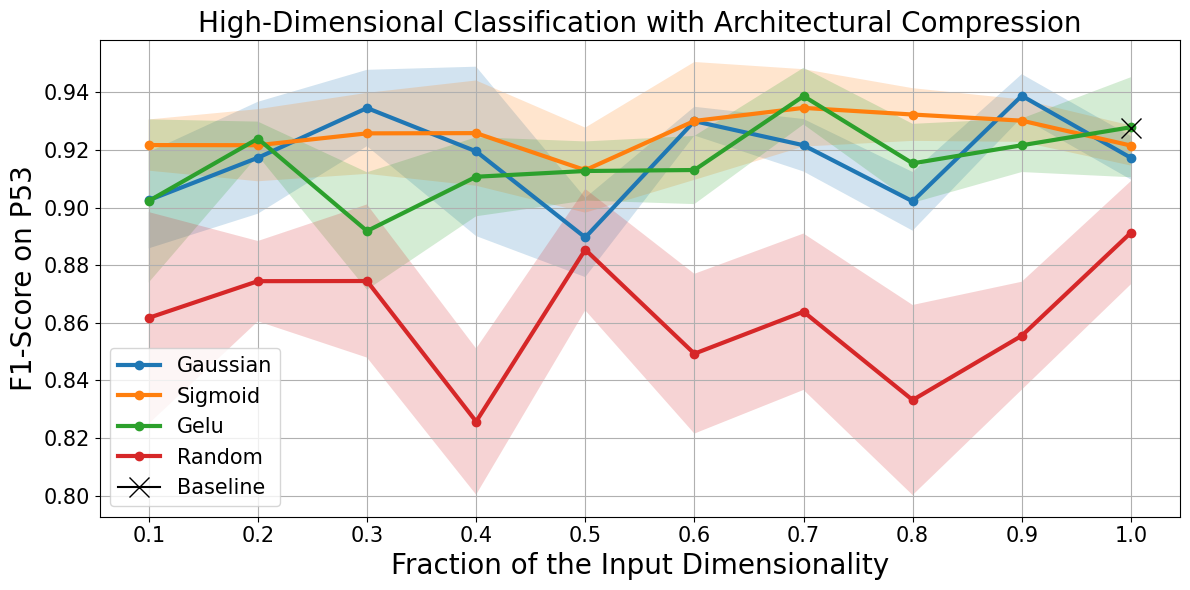

In [11]:
def mean_(method):
    l=[]
    for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        reduction_= train_x.shape[1] *per_red
        l.append(np.mean([i[0]["F1 Score"] for i in  dict_results[method+"-"+str(reduction_)][1] ]))
    return l
def std_(method):
    l=[]
    for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        reduction_= train_x.shape[1] *per_red
        l.append(np.std([i[0]["F1 Score"] for i in  dict_results[method+"-"+str(reduction_)][1] ]))
    return l


import numpy as np
import matplotlib.pyplot as plt


# 2. Generar la gráfica
plt.figure(figsize=(12, 6))
sorted_per_red = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for method in ["gaussian","sigmoid","gelu","random"]:
    
    sorted_mean_f1 = np.array(mean_(method))
    sorted_std_f1 = np.array(std_(method))

    # Graficar la curva principal con la media
    plt.plot(sorted_per_red, sorted_mean_f1, marker='o', label=method.capitalize(), linewidth= 3)
    
    # Graficar el intervalo de confianza (usando la desviación estándar como sombra)
    plt.fill_between(
        sorted_per_red,
        sorted_mean_f1 - 1.96*sorted_std_f1/np.sqrt(5),
        sorted_mean_f1 +1.96* sorted_std_f1/np.sqrt(5),
        alpha=0.2
    )


plt.plot(sorted_per_red[-1], [0.9276], marker='x',label="Baseline", color="black", markersize= 14)
plt.title('High-Dimensional Classification with Architectural Compression', fontsize=20)
plt.xlabel('Fraction of the Input Dimensionality', fontsize=20)
plt.ylabel('F1-Score on P53', fontsize=20)
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.legend(loc="lower left",fontsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig('p53.png', dpi=400)
plt.show()

In [70]:
times=10 #as classic paper
dataset= "p53"
reg, d= 1e-1,10 #as classic paper
dict_results={}
m= int( (train_x.shape[1]/10 -100)/10)

for method in ["gaussian"]: #:,"sigmoid","gelu","random"]: #
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 10, m,sampling=[method,method],epsilon= 0.5,task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    np.save(f'experiments/{method}/{dataset}/full_ejecution_14_25_{reg}_{d}.npy', dict_results) 
    

gaussian
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
dim: Z: 100  and H:  440
Tranining after 10:  0.940986  +-  0.004779345561894421
testing after 10:  0.955012  +-  0.01027290494456169


#### Arcene

In [39]:
import numpy as np
from sklearn.model_selection import KFold

# --- Configuración Inicial ---
dataset = "arcene"
times = 5  # Veces que se entrena el modelo final para robustez
d,n = 10,10      # Parámetro 'd' del modelo BLS
dict_results = {}
reg_grid = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    reduction_= train_x.shape[1] *per_red 
    m = int(( reduction_ - n*d) / d)
    
    for method in ["gaussian","sigmoid","gelu","random"]: 
        
        print(f"--- PROCESANDO MÉTODO: {method.upper()} ---")

        # ==================================================================
        # 1. CROSS-VALIDATION PARA SELECCIONAR EL MEJOR 'reg'
        # ==================================================================
        print(f"\n[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...")

        kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-Fold CV
        cv_scores = {} # Diccionario para guardar el F1-Score promedio por cada 'reg'

        for reg_candidate in reg_grid:
            fold_scores = []
            print(f"  Probando reg = {reg_candidate:.5f}...")

            # Iterar sobre los 'folds' (divisiones) del dataset de entrenamiento
            for train_idx, val_idx in kf.split(train_x):
                # Dividir los datos de entrenamiento en entrenamiento/validación para este fold
                X_cv_train, X_cv_val = train_x[train_idx], train_x[val_idx]
                Y_cv_train, Y_cv_val = train_y[train_idx], train_y[val_idx]

                # Crear y entrenar el modelo con el 'reg' candidato
                model_cv = BLS(reg_candidate, d, n, m, sampling=[method, method],epsilon=1e-2, task="classification")
                model_cv.train(X_cv_train, Y_cv_train)

                # Evaluar en el conjunto de validación de este fold
                (val_acc, _) = model_cv.inference(X_cv_val, Y_cv_val)
                fold_scores.append(val_acc[0]["F1 Score"]) # Extraer F1-Score
                del model_cv

            # Calcular el F1-Score promedio de todos los folds para el 'reg' actual
            cv_scores[reg_candidate] = np.mean(fold_scores)
            print(f"  > F1-Score promedio en validación: {cv_scores[reg_candidate]:.4f}")

        # Seleccionar el mejor 'reg' basado en el F1-Score más alto en la validación cruzada
        best_reg = max(cv_scores, key=cv_scores.get)
        print(f"\n[Paso 1 Completo] Mejor 'reg' encontrado: {best_reg} (F1-Score: {cv_scores[best_reg]:.4f})")

        # ==================================================================
        # 2. ENTRENAMIENTO FINAL CON EL MEJOR 'reg'
        # ==================================================================
        print(f"\n[Paso 2] Entrenando el modelo final {times} veces con reg = {best_reg}...\n")

        testing, training = [], []
        testing_t, training_t = [], []

        for i in range(times):
            # Crear el modelo con el MEJOR hiperparámetro encontrado
            model = BLS(best_reg, d, n, m, sampling=[method, method],epsilon=1e-2, task="classification")

            # Entrenar con TODOS los datos de entrenamiento
            (train_acc, train_time) = model.train(train_x, train_y)

            # Evaluar en el conjunto de test (que no se usó en CV)
            (test_acc, test_time) = model.inference(test_x, test_y)

            # Guardar resultados de esta iteración
            testing.append(test_acc)
            training.append(train_acc)
            testing_t.append(test_time)
            training_t.append(train_time)
            del model

        # Imprimir resultados finales promediados de las 'times' ejecuciones
        print(f"\n--- RESULTADOS FINALES PARA MÉTODO '{method.upper()}' (reg={best_reg}) ---")
        train_f1_scores = [res[0][0]["F1 Score"] for res in training]
        test_f1_scores = [res[0]["F1 Score"] for res in testing]

        print(f"Training F1-Score después de {times} ejecuciones: {np.mean(train_f1_scores):.4f} ± {np.std(train_f1_scores):.4f}")
        print(f"Testing F1-Score después de {times} ejecuciones:  {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")

        # Guardar resultados en el diccionario y en el archivo
        dict_results[method+"-"+str(reduction_)] = [training, testing, training_t, testing_t]
        # Se recomienda añadir el método y 'best' al nombre del archivo para claridad
        np.save(f'experiments/{method}/{dataset}/full_ejecution_best_reg_{best_reg:.5f}.npy', dict_results)
        print("---------------------------------------------------\n")


--- PROCESANDO MÉTODO: GAUSSIAN ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
  > F1-Score promedio en validación: 0.6728
  Probando reg = 0.00001...
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
  > F1-Score promedio en validación: 0.7337
  Probando reg = 0.00010...
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
  > F1-Score promedio en validación: 0.7724
  Probando reg = 0.00100...
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
  > F1-Score promedio en validación: 0.8248
  Probando reg = 0.01000...
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim: Z: 100  and H:  900
dim

dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
  > F1-Score promedio en validación: 0.8370
  Probando reg = 0.00010...
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
  > F1-Score promedio en validación: 0.7840
  Probando reg = 0.00100...
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
  > F1-Score promedio en validación: 0.8369
  Probando reg = 0.01000...
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
  > F1-Score promedio en validación: 0.7464
  Probando reg = 0.10000...
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
dim: Z: 100  and H:  1900
  > F1-Score promedio en validación: 0.8235
  Probando reg = 1

dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
  > F1-Score promedio en validación: 0.7736
  Probando reg = 0.00100...
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
  > F1-Score promedio en validación: 0.8456
  Probando reg = 0.01000...
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
  > F1-Score promedio en validación: 0.7832
  Probando reg = 0.10000...
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
  > F1-Score promedio en validación: 0.7963
  Probando reg = 1.00000...
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
dim: Z: 100  and H:  2900
  > F1-Score promedio en validación: 0.8233

[Paso 1 Completo]

dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
  > F1-Score promedio en validación: 0.7863
  Probando reg = 0.01000...
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
  > F1-Score promedio en validación: 0.8359
  Probando reg = 0.10000...
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
  > F1-Score promedio en validación: 0.7551
  Probando reg = 1.00000...
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
  > F1-Score promedio en validación: 0.8620

[Paso 1 Completo] Mejor 'reg' encontrado: 1 (F1-Score: 0.8620)

[Paso 2] Entrenando el modelo final 5 veces con reg = 1...

dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and H:  3900
dim: Z: 100  and 

dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
  > F1-Score promedio en validación: 0.7969
  Probando reg = 0.10000...
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
  > F1-Score promedio en validación: 0.7728
  Probando reg = 1.00000...
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
  > F1-Score promedio en validación: 0.7723

[Paso 1 Completo] Mejor 'reg' encontrado: 0.0001 (F1-Score: 0.8248)

[Paso 2] Entrenando el modelo final 5 veces con reg = 0.0001...

dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900
dim: Z: 100  and H:  4900

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=0.0001) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 eje

dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
  > F1-Score promedio en validación: 0.7855
  Probando reg = 1.00000...
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
  > F1-Score promedio en validación: 0.8113

[Paso 1 Completo] Mejor 'reg' encontrado: 1e-05 (F1-Score: 0.8488)

[Paso 2] Entrenando el modelo final 5 veces con reg = 1e-05...

dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900
dim: Z: 100  and H:  5900

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=1e-05) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 ejecuciones:  0.7256 ± 0.0793
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.0

dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
  > F1-Score promedio en validación: 0.7743

[Paso 1 Completo] Mejor 'reg' encontrado: 0.1 (F1-Score: 0.8353)

[Paso 2] Entrenando el modelo final 5 veces con reg = 0.1...

dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=0.1) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 ejecuciones:  0.7921 ± 0.0348
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
dim: Z: 100  and H:  6900
  > F1-Score promedio en validación: 0.7957
  Probando reg = 0.00001..

dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=0.0001) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 ejecuciones:  0.8009 ± 0.0514
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
  > F1-Score promedio en validación: 0.7797
  Probando reg = 0.00001...
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
  > F1-Score promedio en validación: 0.8243
  Probando reg = 0.00010...
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H:  7900
dim: Z: 100  and H

dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
  > F1-Score promedio en validación: 0.8482
  Probando reg = 0.00001...
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
  > F1-Score promedio en validación: 0.7970
  Probando reg = 0.00010...
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
  > F1-Score promedio en validación: 0.8241
  Probando reg = 0.00100...
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
  > F1-Score promedio en validación: 0.8125
  Probando reg = 0.01000...
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
dim: Z: 100  and H:  8900
  > F1-Score promedio en validación: 0.8485
  Probando reg = 0

dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
  > F1-Score promedio en validación: 0.8352
  Probando reg = 0.00010...
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
  > F1-Score promedio en validación: 0.8113
  Probando reg = 0.00100...
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
  > F1-Score promedio en validación: 0.8217
  Probando reg = 0.01000...
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
  > F1-Score promedio en validación: 0.8369
  Probando reg = 0.10000...
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
dim: Z: 100  and H:  9900
  > F1-Score promedio en validación: 0.8098
  Probando reg = 1

In [26]:
times=10 #as classic paper
dataset= "arcene"
reg, d= 1e-1,10 #as classic paper
dict_results={}

for method in ["gaussian"]: #:,"sigmoid","gelu","random"]: #
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 10, 100,sampling=[method,method],task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    np.save(f'experiments/{method}/{dataset}/full_ejecution_14_25_{reg}_{d}.npy', dict_results) 
    

gaussian
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
Tranining after 10:  0.998751  +-  0.0037470000000000008
testing after 10:  0.725924  +-  0.044642540743107376


In [16]:
dict_results= np.load(f'experiments/random/arcene/full_ejecution_best_reg_{1e-05:.5f}.npy',allow_pickle=True).item()


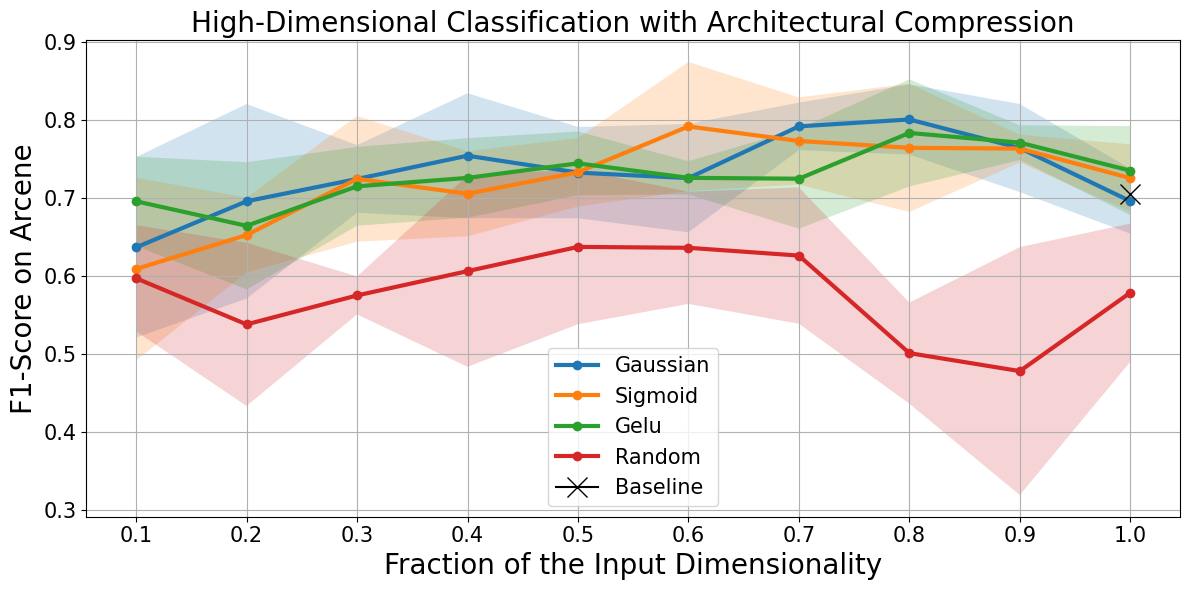

In [17]:
def mean_(method):
    l=[]
    for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        reduction_= train_x.shape[1] *per_red
        l.append(np.mean([i[0]["F1 Score"] for i in  dict_results[method+"-"+str(reduction_)][1] ]))
    return l
def std_(method):
    l=[]
    for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        reduction_= train_x.shape[1] *per_red
        l.append(np.std([i[0]["F1 Score"] for i in  dict_results[method+"-"+str(reduction_)][1] ]))
    return l


import numpy as np
import matplotlib.pyplot as plt


# 2. Generar la gráfica
plt.figure(figsize=(12, 6))
sorted_per_red = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for method in ["gaussian","sigmoid","gelu","random"]:
    
    sorted_mean_f1 = np.array(mean_(method))
    sorted_std_f1 = np.array(std_(method))

    # Graficar la curva principal con la media
    plt.plot(sorted_per_red, sorted_mean_f1, marker='o', label=method.capitalize(), linewidth=3)
    
    # Graficar el intervalo de confianza (usando la desviación estándar como sombra)
    plt.fill_between(
        sorted_per_red,
        sorted_mean_f1 - 1.96*sorted_std_f1/np.sqrt(5),
        sorted_mean_f1 +1.96* sorted_std_f1/np.sqrt(5),
        alpha=0.2
    )

plt.plot(sorted_per_red[-1], [0.7055], marker='x',label="Baseline", color="black", markersize= 14)
plt.title('High-Dimensional Classification with Architectural Compression', fontsize=20)
plt.xlabel('Fraction of the Input Dimensionality', fontsize=20)
plt.ylabel('F1-Score on Arcene', fontsize=20)
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.legend(loc="lower center",fontsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig('arcene.png', dpi=400)
plt.show()

#### GeneExp

In [22]:
train_x,train_y,test_x, test_y=X_train_scl,Y_train,X_test_scl,Y_test

In [143]:
import numpy as np
from sklearn.model_selection import KFold

# --- Configuración Inicial ---
dataset = "geneexp"
times = 5  # Veces que se entrena el modelo final para robustez
d,n = 10,10      # Parámetro 'd' del modelo BLS
dict_results = {}
reg_grid = [1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]


In [47]:

for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    reduction_= train_x.shape[1] *per_red 
    m = int(( reduction_ - n*d) / d)
    
    for method in ["gaussian","sigmoid","gelu","random"]: 
        
        print(f"--- PROCESANDO MÉTODO: {method.upper()} ---")

        # ==================================================================
        # 1. CROSS-VALIDATION PARA SELECCIONAR EL MEJOR 'reg'
        # ==================================================================
        print(f"\n[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...")

        kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5-Fold CV
        cv_scores = {} # Diccionario para guardar el F1-Score promedio por cada 'reg'

        for reg_candidate in reg_grid:
            fold_scores = []
            print(f"  Probando reg = {reg_candidate:.5f}...")

            # Iterar sobre los 'folds' (divisiones) del dataset de entrenamiento
            for train_idx, val_idx in kf.split(train_x):
                # Dividir los datos de entrenamiento en entrenamiento/validación para este fold
                X_cv_train, X_cv_val = train_x[train_idx], train_x[val_idx]
                Y_cv_train, Y_cv_val = train_y[train_idx], train_y[val_idx]

                # Crear y entrenar el modelo con el 'reg' candidato
                model_cv = BLS(reg_candidate, d, n, m, sampling=[method, method],epsilon=1e-2, task="classification")
                model_cv.train(X_cv_train, Y_cv_train)

                # Evaluar en el conjunto de validación de este fold
                (val_acc, _) = model_cv.inference(X_cv_val, Y_cv_val)
                fold_scores.append(val_acc[0]["F1 Score"]) # Extraer F1-Score
                del model_cv

            # Calcular el F1-Score promedio de todos los folds para el 'reg' actual
            cv_scores[reg_candidate] = np.mean(fold_scores)
            print(f"  > F1-Score promedio en validación: {cv_scores[reg_candidate]:.4f}")

        # Seleccionar el mejor 'reg' basado en el F1-Score más alto en la validación cruzada
        best_reg = max(cv_scores, key=cv_scores.get)
        print(f"\n[Paso 1 Completo] Mejor 'reg' encontrado: {best_reg} (F1-Score: {cv_scores[best_reg]:.4f})")

        # ==================================================================
        # 2. ENTRENAMIENTO FINAL CON EL MEJOR 'reg'
        # ==================================================================
        print(f"\n[Paso 2] Entrenando el modelo final {times} veces con reg = {best_reg}...\n")

        testing, training = [], []
        testing_t, training_t = [], []

        for i in range(times):
            # Crear el modelo con el MEJOR hiperparámetro encontrado
            model = BLS(best_reg, d, n, m, sampling=[method, method],epsilon=1e-2, task="classification")

            # Entrenar con TODOS los datos de entrenamiento
            (train_acc, train_time) = model.train(train_x, train_y)

            # Evaluar en el conjunto de test (que no se usó en CV)
            (test_acc, test_time) = model.inference(test_x, test_y)

            # Guardar resultados de esta iteración
            testing.append(test_acc)
            training.append(train_acc)
            testing_t.append(test_time)
            training_t.append(train_time)
            del model

        # Imprimir resultados finales promediados de las 'times' ejecuciones
        print(f"\n--- RESULTADOS FINALES PARA MÉTODO '{method.upper()}' (reg={best_reg}) ---")
        train_f1_scores = [res[0][0]["F1 Score"] for res in training]
        test_f1_scores = [res[0]["F1 Score"] for res in testing]

        print(f"Training F1-Score después de {times} ejecuciones: {np.mean(train_f1_scores):.4f} ± {np.std(train_f1_scores):.4f}")
        print(f"Testing F1-Score después de {times} ejecuciones:  {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")

        # Guardar resultados en el diccionario y en el archivo
        dict_results[method+"-"+str(reduction_)] = [training, testing, training_t, testing_t]
        # Se recomienda añadir el método y 'best' al nombre del archivo para claridad
        np.save(f'experiments/{method}/{dataset}/full_ejecution_best_reg_{best_reg:.5f}.npy', dict_results)
        print("---------------------------------------------------\n")


--- PROCESANDO MÉTODO: GAUSSIAN ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
  > F1-Score promedio en validación: 0.9049
  Probando reg = 0.00001...
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
  > F1-Score promedio en validación: 0.8142
  Probando reg = 0.00010...
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
  > F1-Score promedio en validación: 0.9178
  Probando reg = 0.00100...
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
  > F1-Score promedio en validación: 0.9049
  Probando reg = 0.01000...
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim: Z: 100  and H:  610
dim

dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
  > F1-Score promedio en validación: 0.9151
  Probando reg = 0.00010...
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
  > F1-Score promedio en validación: 0.9043
  Probando reg = 0.00100...
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
  > F1-Score promedio en validación: 0.9460
  Probando reg = 0.01000...
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
  > F1-Score promedio en validación: 0.9746
  Probando reg = 0.10000...
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
dim: Z: 100  and H:  1320
  > F1-Score promedio en validación: 0.9328
  Probando reg = 1

dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.00100...
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
  > F1-Score promedio en validación: 0.9460
  Probando reg = 0.01000...
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
  > F1-Score promedio en validación: 0.8733
  Probando reg = 0.10000...
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
  > F1-Score promedio en validación: 0.8761
  Probando reg = 1.00000...
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
dim: Z: 100  and H:  2030
  > F1-Score promedio en validación: 0.9049

[Paso 1 Completo]

dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.01000...
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.10000...
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
  > F1-Score promedio en validación: 0.9049
  Probando reg = 1.00000...
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
  > F1-Score promedio en validación: 0.9046

[Paso 1 Completo] Mejor 'reg' encontrado: 0.001 (F1-Score: 0.9328)

[Paso 2] Entrenando el modelo final 5 veces con reg = 0.001...

dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 100  and H:  2750
dim: Z: 1

  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.01000...
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.10000...
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
  > F1-Score promedio en validación: 0.9043
  Probando reg = 1.00000...
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
  > F1-Score promedio en validación: 0.8763

[Paso 1 Completo] Mejor 'reg' encontrado: 0.0001 (F1-Score: 0.9328)

[Paso 2] Entrenando el modelo final 5 veces con reg = 0.0001...

dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460
dim: Z: 100  and H:  3460

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=0.0001) ---
Training F1-Score des

dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.10000...
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
  > F1-Score promedio en validación: 0.8763
  Probando reg = 1.00000...
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
  > F1-Score promedio en validación: 0.9328

[Paso 1 Completo] Mejor 'reg' encontrado: 1e-06 (F1-Score: 0.9460)

[Paso 2] Entrenando el modelo final 5 veces con reg = 1e-06...

dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170
dim: Z: 100  and H:  4170

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=1e-06) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 ejecuciones:  0.8473 ± 0.0437
---------------------------------------------------

-

dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
  > F1-Score promedio en validación: 0.9328
  Probando reg = 1.00000...
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
  > F1-Score promedio en validación: 0.9328

[Paso 1 Completo] Mejor 'reg' encontrado: 0.0001 (F1-Score: 0.9460)

[Paso 2] Entrenando el modelo final 5 veces con reg = 0.0001...

dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890
dim: Z: 100  and H:  4890

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=0.0001) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 ejecuciones:  0.8253 ± 0.0745
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  an

dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
  > F1-Score promedio en validación: 0.9328

[Paso 1 Completo] Mejor 'reg' encontrado: 0.0001 (F1-Score: 0.9328)

[Paso 2] Entrenando el modelo final 5 veces con reg = 0.0001...

dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=0.0001) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 ejecuciones:  0.8587 ± 0.0429
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
dim: Z: 100  and H:  5600
  > F1-Score promedio en validación: 0.9328
  Probando reg = 

dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310

--- RESULTADOS FINALES PARA MÉTODO 'GAUSSIAN' (reg=1e-06) ---
Training F1-Score después de 5 ejecuciones: 1.0000 ± 0.0000
Testing F1-Score después de 5 ejecuciones:  0.8323 ± 0.0440
---------------------------------------------------

--- PROCESANDO MÉTODO: SIGMOID ---

[Paso 1] Iniciando Cross-Validation para encontrar el mejor 'reg'...
  Probando reg = 0.00000...
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
  > F1-Score promedio en validación: 0.9043
  Probando reg = 0.00001...
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
  > F1-Score promedio en validación: 0.9046
  Probando reg = 0.00010...
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:  6310
dim: Z: 100  and H:

dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.00001...
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.00010...
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
  > F1-Score promedio en validación: 0.9043
  Probando reg = 0.00100...
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
  > F1-Score promedio en validación: 0.9328
  Probando reg = 0.01000...
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
dim: Z: 100  and H:  7020
  > F1-Score promedio en validación: 0.9043
  Probando reg = 0

In [23]:
dict_results= np.load(f'experiments/random/geneexp/full_ejecution_best_reg_{1:.5f}.npy',allow_pickle=True).item()


In [137]:
dict_results.keys()

dict_keys(['gaussian-712.9000000000001', 'sigmoid-712.9000000000001', 'gelu-712.9000000000001', 'random-712.9000000000001', 'gaussian-1425.8000000000002', 'sigmoid-1425.8000000000002', 'gelu-1425.8000000000002', 'random-1425.8000000000002', 'gaussian-2138.7', 'sigmoid-2138.7', 'gelu-2138.7', 'random-2138.7', 'gaussian-2851.6000000000004', 'sigmoid-2851.6000000000004', 'gelu-2851.6000000000004', 'random-2851.6000000000004', 'gaussian-3564.5', 'sigmoid-3564.5', 'gelu-3564.5', 'random-3564.5', 'gaussian-4277.4', 'sigmoid-4277.4', 'gelu-4277.4', 'random-4277.4', 'gaussian-4990.299999999999', 'sigmoid-4990.299999999999', 'gelu-4990.299999999999', 'random-4990.299999999999', 'gaussian-5703.200000000001', 'sigmoid-5703.200000000001', 'gelu-5703.200000000001', 'random-5703.200000000001', 'gaussian-6416.1', 'sigmoid-6416.1', 'gelu-6416.1', 'random-6416.1', 'gaussian-7129', 'sigmoid-7129', 'gelu-7129', 'random-7129'])

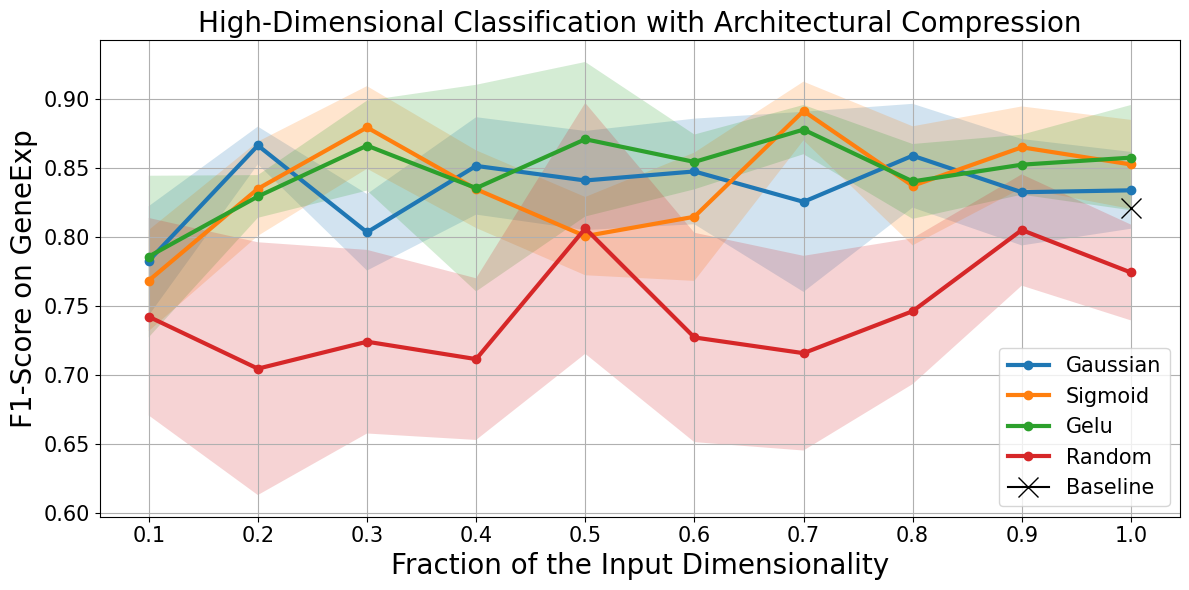

In [24]:
def mean_(method):
    l=[]
    for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        reduction_= train_x.shape[1] *per_red
        l.append(np.mean([i[0]["F1 Score"] for i in  dict_results[method+"-"+str(reduction_)][1] ]))
    return l
def std_(method):
    l=[]
    for per_red in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        reduction_= train_x.shape[1] *per_red
        l.append(np.std([i[0]["F1 Score"] for i in  dict_results[method+"-"+str(reduction_)][1] ]))
    return l


import numpy as np
import matplotlib.pyplot as plt


# 2. Generar la gráfica
plt.figure(figsize=(12, 6))
sorted_per_red = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for method in ["gaussian","sigmoid","gelu","random"]:
    
    sorted_mean_f1 = np.array(mean_(method))
    sorted_std_f1 = np.array(std_(method))

    # Graficar la curva principal con la media
    plt.plot(sorted_per_red, sorted_mean_f1, marker='o', label=method.capitalize(), linewidth= 3)
    
    # Graficar el intervalo de confianza (usando la desviación estándar como sombra)
    plt.fill_between(
        sorted_per_red,
        sorted_mean_f1 - 1.96*sorted_std_f1/np.sqrt(5),
        sorted_mean_f1 +1.96* sorted_std_f1/np.sqrt(5),
        alpha=0.2
    )

plt.plot(sorted_per_red[-1], [0.821], marker='x',label="Baseline", color="black", markersize= 14)
plt.title('High-Dimensional Classification with Architectural Compression', fontsize=20)
plt.xlabel('Fraction of the Input Dimensionality', fontsize=20)
plt.ylabel('F1-Score on GeneExp', fontsize=20)
plt.xticks(np.arange(0.1, 1.1, 0.1))
plt.legend(fontsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.grid(True)
plt.tight_layout()
plt.savefig('geneExp.png', dpi=400)
plt.show()

#### PANCAN

In [71]:
times=10 #as classic paper
dataset= "pancan"
reg, d= 1E-2,16 #as classic paper
dict_results={}

for method in ["gaussian","sigmoid","gelu","random"]: #
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 14, 26,sampling=[method,method],task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    np.save(f'experiments/{method}/{dataset}/full_ejecution_14_25_{reg}_{d}.npy', dict_results) 
    


gaussian
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
Tranining after 10:  1.0  +-  0.0
testing after 10:  1.0  +-  0.0
sigmoid


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416


C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:15: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * -(x - breakpoints[i])))  for x in x_values])
C:\Users\mario\AppData\Local\Temp\ipykernel_21824\1849136944.py:18: RuntimeWarning: overflow encountered in exp
  evaluations.append([1/(1 + np.exp(-growth_rate * (x - br

dim: Z: 224  and H:  416
Tranining after 10:  1.0  +-  0.0
testing after 10:  1.0  +-  0.0
gelu
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
Tranining after 10:  1.0  +-  0.0
testing after 10:  1.0  +-  0.0
random
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
dim: Z: 224  and H:  416
Tranining after 10:  1.0  +-  0.0
testing after 10:  0.998146  +-  0.0028320317794826924


#### isolet

In [87]:
times=10 #as classic paper
dataset= "isolet"
reg, d= 1E-2,16 #as classic paper
dict_results={}

for method in ["gaussian","sigmoid","gelu","random"]: #
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 14, 25,sampling=[method,method],task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    np.save(f'experiments/{method}/{dataset}/full_ejecution_14_25_{reg}_{d}.npy', dict_results) 
    


gaussian
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
Tranining after 10:  0.9970679999999998  +-  0.00036399999999998657
testing after 10:  0.9418590000000002  +-  0.0034722628068739082
sigmoid
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
Tranining after 10:  0.9971599999999998  +-  0.0002700000000000036
testing after 10:  0.9407460000000001  +-  0.002315172563762792
gelu
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  and H:  400
dim: Z: 224  a

In [267]:
dataset= "isolet"
reg, d= 1E-2,16 #as classic paper
times=10 #as classic paper


for method in ["gaussian", "sigmoid","gelu","random"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_14_25_{reg}_{d}.npy', allow_pickle=True).item()
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.round(np.mean([i[0]["F1 Score"]*100 for i in testing]),2), " +- ", np.round(np.std([i[0]["F1 Score"]*100 for i in testing]),2) )
print("testing max: ", np.round(np.max([i[0]["F1 Score"]*100 for i in testing]),2) )


gaussian
testing after 10:  94.19  +-  0.35
sigmoid
testing after 10:  94.07  +-  0.23
gelu
testing after 10:  93.99  +-  0.33
random
testing after 10:  93.12  +-  0.63
testing max:  94.18


In [96]:
# Create data
import scipy.stats as stats

#aqui me equivoque al guardar pero 10-100 es 100-1000
dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_14_25_{reg}_{d}.npy', allow_pickle=True).item()
for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_14_25_{reg}_{d}.npy', allow_pickle=True).item()
    # conduct the Wilcoxon-Signed Rank Test
    p_value= stats.wilcoxon([i[0]["F1 Score"] for i in dict_results_r["random"][1]] , [i[0]["F1 Score"] for i in dict_results[method][1]] ).pvalue
    if p_value<0.05:
        print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
    else:
        print("equal")

gaussian
the true mean mpg is not equal between the two groups 0.002
sigmoid
the true mean mpg is not equal between the two groups 0.002
gelu
the true mean mpg is not equal between the two groups 0.01


#### MNIST

In [11]:
times=10 #as classic paper
dataset= "mnist"
reg, d= 1E-8,10 #as classic paper
dict_results={}

for method in ["gaussian","sigmoid","gelu"]: #
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 100, 1000,sampling=[method,method],task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    np.save(f'experiments/{method}/{dataset}/full_ejecution_100_1000_{reg}_{d}.npy', dict_results) 
    

for method in ["gaussian","sigmoid","gelu"]: #
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 1000, 100,sampling=[method,method],task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    np.save(f'experiments/{method}/{dataset}/full_ejecution_1000_100_{reg}_{d}.npy', dict_results) 

gaussian
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
Tranining after 10:  0.992267  +-  0.00016377118183612447
testing after 10:  0.973884  +-  0.0006500953776177734
sigmoid
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
Tranining after 10:  0.9926210000000001  +-  0.0001713154984232342
testing after 10:  0.9724129999999999  +-  0.0007245557259452202
gelu
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: 

In [77]:
times=10 #as classic paper
dataset= "mnist"
reg, d= 1E-8,10 #as classic paper
dict_results={}

for method in ["gaussian","sigmoid","gelu","random"]: #
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 10, 100,sampling=method,task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    
np.save(f'experiments/random/{dataset}/full_ejecution_10_100_{reg}_{d}.npy', dict_results)


dict_results={}

for method in ["gaussian", "sigmoid","gelu","random"]: 
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 100, 10,sampling=method,task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    
np.save(f'experiments/random/{dataset}/full_ejecution_100_10_{reg}_{d}.npy', dict_results)


dict_results={}

for method in ["gaussian", "sigmoid","gelu","random"]: 
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 56, 56,sampling=method,task= "classification")
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    
np.save(f'experiments/random/{dataset}/full_ejecution_55_55_{reg}_{d}.npy', dict_results)

gaussian
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.93448, 'F1 Score': 0.93441}
Testing classic accurate is {'Accuracy': 0.9375, 'F1 Score': 0.93742}
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.93628, 'F1 Score': 0.93624}
Testing classic accurate is {'Accuracy': 0.9337, 'F1 Score': 0.93362}
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.93527, 'F1 Score': 0.93521}
Testing classic accurate is {'Accuracy': 0.9349, 'F1 Score': 0.93479}
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.93475, 'F1 Score': 0.9347}
Testing classic accurate is {'Accuracy': 0.9332, 'F1 Score': 0.93315}
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.93617, 'F1 Score': 0.93612}
Testing classic accurate is {'Accuracy': 0.9336, 'F1 Score': 0.93352}
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.9361, 'F1 Score': 0.93603}
Testing classic accurate is {'Accuracy': 0.9377, 'F1 Sc

dim: Z: 1000  and H:  100
Training classic accurate is {'Accuracy': 0.90392, 'F1 Score': 0.90358}
Testing classic accurate is {'Accuracy': 0.9062, 'F1 Score': 0.90582}
dim: Z: 1000  and H:  100
Training classic accurate is {'Accuracy': 0.90238, 'F1 Score': 0.90205}
Testing classic accurate is {'Accuracy': 0.9051, 'F1 Score': 0.90472}
dim: Z: 1000  and H:  100
Training classic accurate is {'Accuracy': 0.90562, 'F1 Score': 0.90541}
Testing classic accurate is {'Accuracy': 0.9066, 'F1 Score': 0.90627}
dim: Z: 1000  and H:  100
Training classic accurate is {'Accuracy': 0.90457, 'F1 Score': 0.90433}
Testing classic accurate is {'Accuracy': 0.9078, 'F1 Score': 0.90744}
Tranining after 10:  0.903611  +-  0.0011818498212548079
testing after 10:  0.9053889999999999  +-  0.0015515311791904208
sigmoid
dim: Z: 1000  and H:  100
Training classic accurate is {'Accuracy': 0.89805, 'F1 Score': 0.89771}
Testing classic accurate is {'Accuracy': 0.8983, 'F1 Score': 0.89788}
dim: Z: 1000  and H:  100
Trai

Testing classic accurate is {'Accuracy': 0.9251, 'F1 Score': 0.92489}
dim: Z: 560  and H:  560
Training classic accurate is {'Accuracy': 0.92678, 'F1 Score': 0.92668}
Testing classic accurate is {'Accuracy': 0.926, 'F1 Score': 0.92587}
dim: Z: 560  and H:  560
Training classic accurate is {'Accuracy': 0.92523, 'F1 Score': 0.92515}
Testing classic accurate is {'Accuracy': 0.9245, 'F1 Score': 0.92435}
dim: Z: 560  and H:  560
Training classic accurate is {'Accuracy': 0.92508, 'F1 Score': 0.925}
Testing classic accurate is {'Accuracy': 0.9231, 'F1 Score': 0.92294}
dim: Z: 560  and H:  560
Training classic accurate is {'Accuracy': 0.9251, 'F1 Score': 0.925}
Testing classic accurate is {'Accuracy': 0.9234, 'F1 Score': 0.92324}
dim: Z: 560  and H:  560
Training classic accurate is {'Accuracy': 0.92468, 'F1 Score': 0.9246}
Testing classic accurate is {'Accuracy': 0.9252, 'F1 Score': 0.92506}
dim: Z: 560  and H:  560
Training classic accurate is {'Accuracy': 0.92628, 'F1 Score': 0.9262}
Testin

In [23]:
dataset= "mnist"
reg, d= 1E-8,10
times=10 #as classic paper

for method in ["gaussian", "sigmoid","gelu"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_100_1000_{reg}_{d}.npy', allow_pickle=True).item()
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    print(np.mean(training_t))

gaussian
242.8412338256836
sigmoid
255.49199025630952
gelu
255.7055488348007


In [41]:
242.8412338256836/60  #[min]

4.047353897094727

In [6]:
dataset= "mnist"
reg, d= 1E-8,10
times=10 #as classic paper

for method in ["gaussian", "sigmoid","gelu"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_100_1000_{reg}_{d}.npy', allow_pickle=True).item()
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.round(np.mean([i[0]["F1 Score"]*100 for i in testing]),2), " +- ", np.round(np.std([i[0]["F1 Score"]*100 for i in testing]),2) )

method="random"
dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_10_1000_{reg}_{d}.npy', allow_pickle=True).item()
print(method)
[training,testing,training_t,testing_t] = dict_results[method]
print("testing after "+str(times)+": ", np.round(np.mean([i[0]["F1 Score"]*100 for i in testing]),2), " +- ", np.round(np.std([i[0]["F1 Score"]*100 for i in testing]),2) )
    
for method in ["gaussian", "sigmoid","gelu"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_1000_100_{reg}_{d}.npy', allow_pickle=True).item()
    print(method)
    [training,testing,training_t,testing_t] = dict_results[method]
    #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.round(np.mean([i[0]["F1 Score"]*100 for i in testing]),2), " +- ", np.round(np.std([i[0]["F1 Score"]*100 for i in testing]),2) )
method="random"
dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_1000_10_{reg}_{d}.npy', allow_pickle=True).item()
print(method)
[training,testing,training_t,testing_t] = dict_results[method]
print("testing after "+str(times)+": ", np.round(np.mean([i[0]["F1 Score"]*100 for i in testing]),2), " +- ", np.round(np.std([i[0]["F1 Score"]*100 for i in testing]),2) )
        

gaussian
testing after 10:  97.39  +-  0.07
sigmoid
testing after 10:  97.24  +-  0.07
gelu
testing after 10:  97.17  +-  0.08
random
testing after 10:  96.93  +-  0.09
gaussian
testing after 10:  94.55  +-  0.08
sigmoid
testing after 10:  93.92  +-  0.08
gelu
testing after 10:  93.94  +-  0.15
random
testing after 10:  87.75  +-  0.19


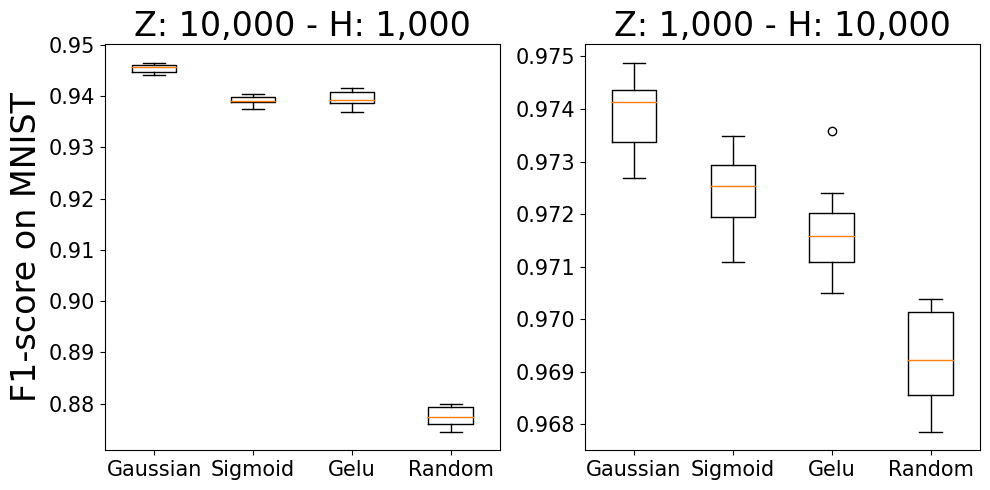

In [32]:
import matplotlib.pyplot as plt
import numpy as np

dataset= "mnist"
reg, d= 1E-8,10
times=10 #as classic paper

# Create a figure with three subplots in one row
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

result=[]
for method in ["gaussian", "sigmoid","gelu"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_1000_100_{reg}_{d}.npy', allow_pickle=True).item()
    result.append([i[0]["F1 Score"] for i in dict_results[method][1]])
method="random"
dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_1000_10_{reg}_{d}.npy', allow_pickle=True).item()
result.append([i[0]["F1 Score"] for i in dict_results[method][1]])
    
size_=15
# Plotting boxplots on the first subplot
axs[0].boxplot(result)
axs[0].set_ylabel('F1-score on MNIST',fontsize=24)
axs[0].tick_params(axis='y', labelsize=size_)
axs[0].set_title('Z: 10,000 - H: 1,000',fontsize=24)
axs[0].set_xticklabels(["Gaussian", "Sigmoid","Gelu","Random"],fontsize=size_)

result=[]
for method in ["gaussian", "sigmoid","gelu"]:
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_100_1000_{reg}_{d}.npy', allow_pickle=True).item()
    result.append([i[0]["F1 Score"] for i in dict_results[method][1]])
method="random"
dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_10_1000_{reg}_{d}.npy', allow_pickle=True).item()
result.append([i[0]["F1 Score"] for i in dict_results[method][1]])
# Plotting boxplots on the third subplot
axs[1].boxplot(result)
axs[1].set_title('Z: 1,000 - H: 10,000',fontsize=24)
axs[1].tick_params(axis='y', labelsize=size_)
axs[1].set_xticklabels(["Gaussian", "Sigmoid","Gelu","Random"],fontsize=size_)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('mnist_results.png', dpi=400)
# Show the plot
plt.show()

In [97]:
# Create data
import scipy.stats as stats

dataset= "mnist"
reg, d= 1E-8,10
#aqui me equivoque al guardar pero 10-100 es 100-1000
dict_results_r= np.load(f'experiments/random/{dataset}/full_ejecution_10_1000_{reg}_{d}.npy', allow_pickle=True).item()
# Create data
import scipy.stats as stats

for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results= np.load(f'experiments/{method}/{dataset}/full_ejecution_100_1000_{reg}_{d}.npy', allow_pickle=True).item()
    # conduct the Wilcoxon-Signed Rank Test
    p_value= stats.wilcoxon([i[0]["F1 Score"] for i in dict_results_r["random"][1]] , [i[0]["F1 Score"] for i in dict_results[method][1]] ).pvalue
    if p_value<0.05:
        print("the true mean mpg is not equal between the two groups", np.round(p_value,3))
    else:
        print("equal")

gaussian
the true mean mpg is not equal between the two groups 0.002
sigmoid
the true mean mpg is not equal between the two groups 0.002
gelu
the true mean mpg is not equal between the two groups 0.002


In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
model.fit(train_x, train_y)

# Predecir con el modelo entrenado
y_pred = model.predict(test_x)
show_accuracy(y_pred,test_y, "classification")

{'Accuracy': 0.9062, 'F1 Score': 0.91705}

In [36]:
dataset= "mnist"
reg, d= 1E-8,10
dict_results= np.load(f'experiments/random/{dataset}/full_ejecution_10_100_{reg}_{d}.npy', allow_pickle=True).item()
for method in ["gaussian", "sigmoid","gelu","random"]:
    print(method)
    print(np.round(np.mean([i[0][0]["F1 Score"] for i in dict_results[method][0]])*100,2), "+-", np.round(np.std([i[0][0]["F1 Score"] for i in dict_results[method][0]])*100,2))
    print(np.round(np.std([i[0] for i in dict_results[method][2]]),2), "seconds" )

gaussian
93.54 +- 0.06
0.26 seconds
sigmoid
92.71 +- 0.05
0.08 seconds
gelu
93.05 +- 0.05
0.08 seconds
random
92.7 +- 0.12
0.13 seconds


### epsilon

In [188]:
dataset= "housing_b"
reg, d,n,m= 1E-5,6,10,10
task="regression"

In [388]:
dataset= "housing"
reg, d,n,m= 1E-3,6,10,10
task="regression"

In [87]:
dataset= "izmir"
reg, d,n,m= 1E-4,4,3,22
task="regression"

In [146]:
dataset= "isolet"
task="clasification"
reg, d,n,m= 1E-2,16,14,25 #as classic paper


In [166]:
dataset= "abalone"
task="regression"
reg,d,n,m= 1E-4, 6, 5, 7

In [3]:
dataset= "mnist"
task="clasification"
reg,d,n,m= 1E-8, 10, 10, 100

In [189]:
times=10 #as classic paper
for c,method in enumerate(["gaussian", "sigmoid","gelu"]):
    dict_results={}
    print(method)
    for epsilon in [0.01,1, 100,10000,1e6]:#:
        print(epsilon)
        testing,training=[],[]
        testing_t,training_t=[],[]
        for i in range(times):
            model= BLS(reg,d,n,m,sampling=[method,method],task= task, epsilon=epsilon)
            (train_acc,train_time,w)=model.train(train_x,train_y)
            (test_acc,test_time,w)=model.inference(test_x,test_y)

            testing.append(test_acc)
            training.append(train_acc)
            testing_t.append(test_time)
            training_t.append(train_time)
            del model
        if task=="clasification":
            print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
            print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
        else:
            print("Tranining after "+str(times)+": ", np.mean([i[0][0]["RMSE"] for i in training]), " +- ", np.std([i[0][0]["RMSE"] for i in training]))
            print("testing after "+str(times)+": ", np.mean([i[0]["RMSE"] for i in testing]), " +- ", np.std([i[0]["RMSE"] for i in testing]))
        dict_results[method+str(epsilon)]= [training,testing,training_t,testing_t]

    np.save(f'experiments/{method}/{dataset}/epsilon.npy', dict_results)

gaussian
0.01
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
Tranining after 10:  0.06631899999999999  +-  0.002540615870217297
testing after 10:  0.121279  +-  0.021123643364722864
1
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
Tranining after 10:  0.06626699999999999  +-  0.001479513771480346
testing after 10:  0.106528  +-  0.009521910312537081
100
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
dim: Z: 60  and H:  60
Tranining after 10:  0.067246  +-  0.00274437315

#### izmir

https://sci2s.ugr.es/keel/category.php?cat=reg

In [129]:
dataset= "izmir"
reg, d,n,m= 1E-4,4,3,22
task="regression"

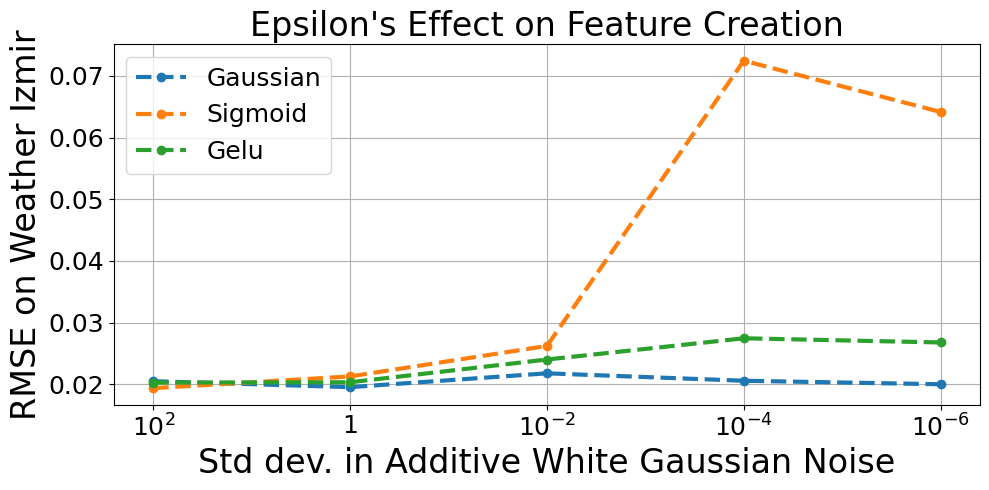

In [130]:


# Definir los valores de epsilon
epsilons =[0.01,1, 100,10000,1e6]

# Crear una figura
plt.figure(figsize=(10, 5))

n_methods=["Gaussian", "Sigmoid", "Gelu", "Random"]
for c,method in enumerate(["gaussian", "sigmoid","gelu"]): 
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()
    means = []
    stds = []

    # Recopilar los valores de media y desviación estándar para cada epsilon
    for epsilon in epsilons:
        [training, testing, training_t, testing_t] = dict_results_2[method+str(epsilon)]
        
        # Calcular la media y la desviación estándar del "F1 Score" en testing
        mean_f1 = np.mean([i[0]["RMSE"] for i in testing])
        std_f1 = np.std([i[0]["RMSE"] for i in testing])
        
        # Guardar los valores para graficar
        means.append(mean_f1)
        stds.append(std_f1)

    # Graficar la media con una línea sólida
    plt.plot(epsilons, means, linestyle='--', marker='o',label=f'{n_methods[c]}', linewidth= 3)

    # Graficar la desviación estándar como un área sombreada con transparencia
    #plt.fill_between(epsilons, np.array(means) - np.array(stds), np.array(means) + np.array(stds), 
     #                alpha=0.3)



# Configurar las etiquetas y el título del gráfico
plt.xscale('log')  # Escala logarítmica en el eje x
plt.xticks(epsilons, labels=["$10^{2}$", "$1$","$10^{-2}$","$10^{-4}$","$10^{-6}$"],fontsize=18)  # Asegurar que solo se muestren los valores de epsilon en la lista
plt.xlabel('Std dev. in Additive White Gaussian Noise',fontsize=24)
plt.ylabel('RMSE on Weather Izmir',fontsize=24)
plt.title("Epsilon's Effect on Feature Creation",fontsize=24)
plt.tick_params(axis='y', labelsize=18)
plt.legend(loc= "upper left",fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig('izmir_epsilon.png.png', dpi=400)
plt.show()

#### abalone

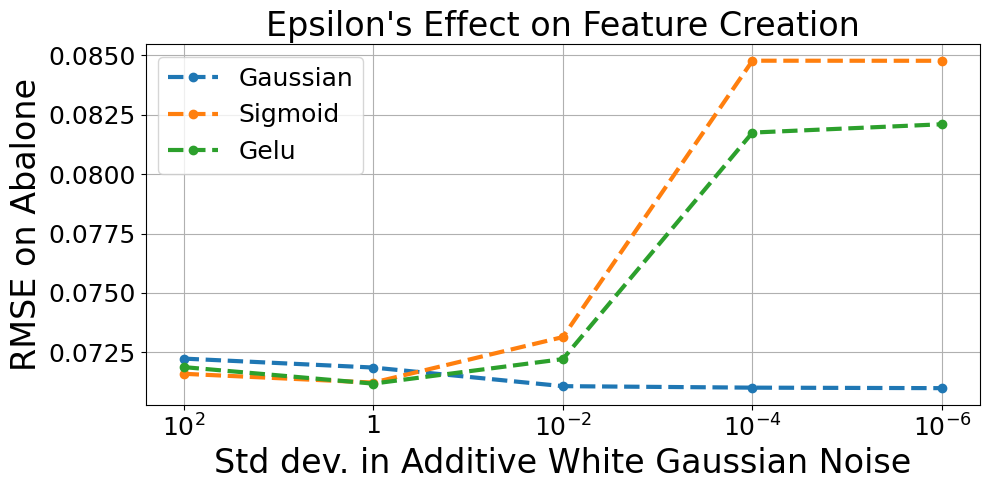

In [131]:
dataset= "abalone"

# Definir los valores de epsilon
epsilons =[0.01,1, 100,10000,1e6]

# Crear una figura
plt.figure(figsize=(10, 5))

n_methods=["Gaussian", "Sigmoid", "Gelu", "Random"]
for c,method in enumerate(["gaussian", "sigmoid","gelu"]): 
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()
    means = []
    stds = []

    # Recopilar los valores de media y desviación estándar para cada epsilon
    for epsilon in epsilons:
        [training, testing, training_t, testing_t] = dict_results_2[method+str(epsilon)]
        
        # Calcular la media y la desviación estándar del "F1 Score" en testing
        mean_f1 = np.mean([i[0]["RMSE"] for i in testing])
        std_f1 = np.std([i[0]["RMSE"] for i in testing])
        
        # Guardar los valores para graficar
        means.append(mean_f1)
        stds.append(std_f1)

    # Graficar la media con una línea sólida
    plt.plot(epsilons, means, linestyle='--', marker='o',label=f'{n_methods[c]}', linewidth=3)

    # Graficar la desviación estándar como un área sombreada con transparencia
    #plt.fill_between(epsilons, np.array(means) - np.array(stds), np.array(means) + np.array(stds), 
     #                alpha=0.3)


# Configurar las etiquetas y el título del gráfico
plt.xscale('log')  # Escala logarítmica en el eje x
plt.xticks(epsilons, labels=["$10^{2}$", "$1$","$10^{-2}$","$10^{-4}$","$10^{-6}$"],fontsize=18)  # Asegurar que solo se muestren los valores de epsilon en la lista
plt.xlabel('Std dev. in Additive White Gaussian Noise',fontsize=24)
plt.ylabel('RMSE on Abalone',fontsize=24)
plt.title("Epsilon's Effect on Feature Creation",fontsize=24)
plt.tick_params(axis='y', labelsize=18)
plt.legend(loc= "upper left",fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig('abalone_epsilon.png', dpi=400)
plt.show()

#### housing

In [132]:
dataset= "housing_b"
reg, d,n,m= 1E-5,6,5,9
task="regression"

In [63]:
dataset= "housing"
reg, d,n,m= 1E-3,6,10,10
task="regression"

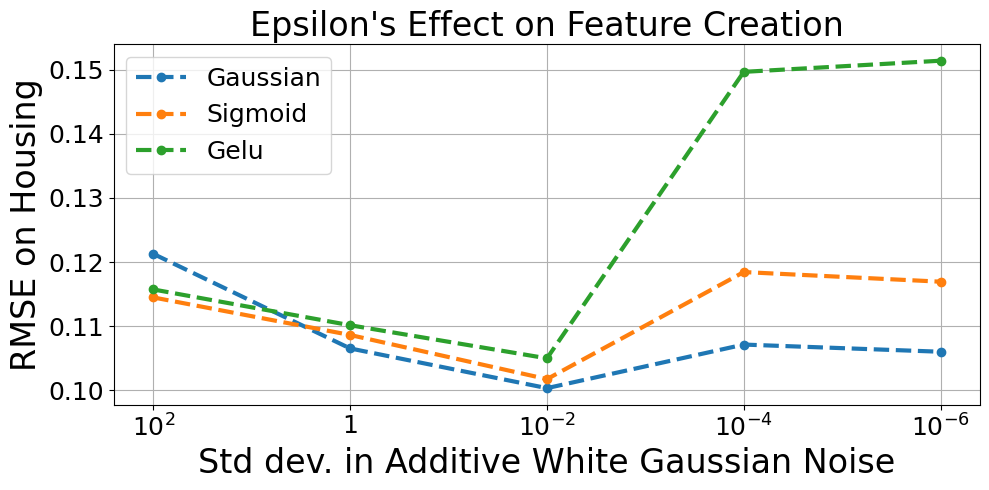

In [133]:

# Definir los valores de epsilon
epsilons =[0.01,1, 100,10000,1e6]

# Crear una figura
plt.figure(figsize=(10, 5))

n_methods=["Gaussian", "Sigmoid", "Gelu", "Random"]
for c,method in enumerate(["gaussian", "sigmoid","gelu"]): 
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()
    means = []
    stds = []

    # Recopilar los valores de media y desviación estándar para cada epsilon
    for epsilon in epsilons:
        [training, testing, training_t, testing_t] = dict_results_2[method+str(epsilon)]
        
        # Calcular la media y la desviación estándar del "F1 Score" en testing
        mean_f1 = np.mean([i[0]["RMSE"] for i in testing])
        std_f1 = np.std([i[0]["RMSE"] for i in testing])
        
        # Guardar los valores para graficar
        means.append(mean_f1)
        stds.append(std_f1)
    # Graficar la media con una línea sólida
    plt.plot(epsilons, means, linestyle='--', marker='o',label=f'{n_methods[c]}', linewidth=3)

    # Graficar la desviación estándar como un área sombreada con transparencia
    #plt.fill_between(epsilons, np.array(means) - np.array(stds), np.array(means) + np.array(stds), 
     #                alpha=0.3)


# Configurar las etiquetas y el título del gráfico
plt.xscale('log')  # Escala logarítmica en el eje x
plt.xticks(epsilons, labels=["$10^{2}$", "$1$","$10^{-2}$","$10^{-4}$","$10^{-6}$"],fontsize=18)  # Asegurar que solo se muestren los valores de epsilon en la lista
plt.xlabel('Std dev. in Additive White Gaussian Noise',fontsize=24)
plt.ylabel('RMSE on Housing',fontsize=24)
plt.title("Epsilon's Effect on Feature Creation",fontsize=24)
plt.tick_params(axis='y', labelsize=18)
plt.legend(loc= "upper left",fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig('housing_epsilon.png', dpi=400)
plt.show()


#### MNIST

In [125]:
dataset="mnist"

In [57]:
for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()

    for epsilon in [0.01,1, 100,10000,1e6]:
        [training,testing,training_t,testing_t] = dict_results_2[method+str(epsilon)]
        #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
        print(epsilon)
        print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    

gaussian
0.01


KeyError: 'F1 Score'

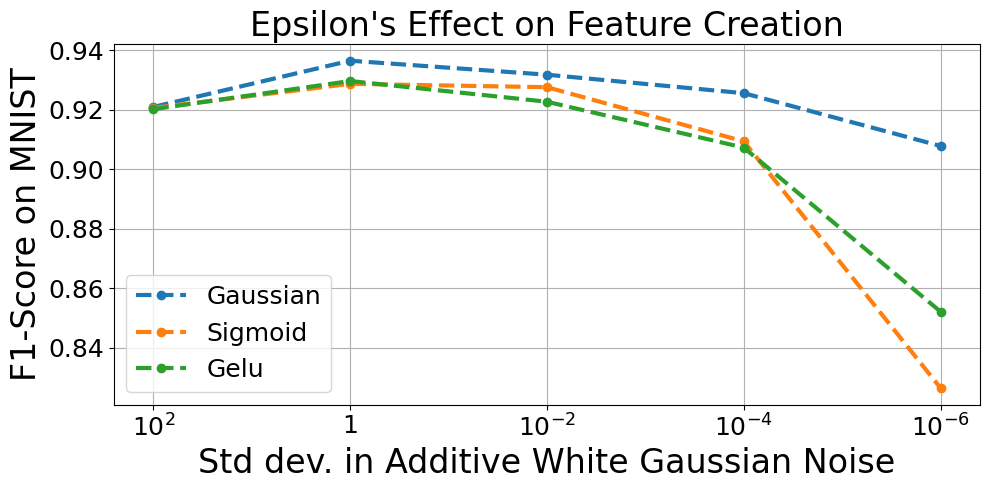

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Definir los valores de epsilon
epsilons =[0.01,1, 100,10000,1e6]

# Crear una figura
plt.figure(figsize=(10, 5))

n_methods=["Gaussian", "Sigmoid", "Gelu", "Random"]
for c,method in enumerate(["gaussian", "sigmoid","gelu"]): 
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()

    means = []
    stds = []

    # Recopilar los valores de media y desviación estándar para cada epsilon
    for epsilon in epsilons:
        [training, testing, training_t, testing_t] = dict_results_2[method+str(epsilon)]
        
        # Calcular la media y la desviación estándar del "F1 Score" en testing
        mean_f1 = np.mean([i[0]["F1 Score"] for i in testing])
        std_f1 = np.std([i[0]["F1 Score"] for i in testing])
        
        # Guardar los valores para graficar
        means.append(mean_f1)
        stds.append(std_f1)

    # Graficar la media con una línea sólida
    plt.plot(epsilons, means, linestyle='--', marker='o',label=f'{n_methods[c]}', linewidth= 3)

    # Graficar la desviación estándar como un área sombreada con transparencia
    #plt.fill_between(epsilons, np.array(means) - np.array(stds), np.array(means) + np.array(stds), 
     #                alpha=0.3)

# Configurar las etiquetas y el título del gráfico
plt.xscale('log')  # Escala logarítmica en el eje x
plt.xticks(epsilons, labels=["$10^{2}$", "$1$","$10^{-2}$","$10^{-4}$","$10^{-6}$"],fontsize=18)  # Asegurar que solo se muestren los valores de epsilon en la lista
plt.xlabel('Std dev. in Additive White Gaussian Noise',fontsize=24)
plt.ylabel('F1-Score on MNIST',fontsize=24)
plt.title("Epsilon's Effect on Feature Creation",fontsize=24)
plt.tick_params(axis='y', labelsize=18)
plt.legend(loc= "lower left",fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig('epsilon_impact.png', dpi=400)
plt.show()

#### isolet

In [147]:
for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()

    for epsilon in [0.01,1, 100,10000,1e6]:
        [training,testing,training_t,testing_t] = dict_results_2[method+str(epsilon)]
        #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
        print(epsilon)
        print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    

gaussian
0.01
testing after 10:  0.9213160000000002  +-  0.007343532120172125
1
testing after 10:  0.9422350000000002  +-  0.005254606074673916
100
testing after 10:  0.8770100000000001  +-  0.00578054149712637
10000
testing after 10:  0.8790049999999999  +-  0.006261350094029235
1000000.0
testing after 10:  0.876501  +-  0.00518466286271345
sigmoid
0.01
testing after 10:  0.922282  +-  0.006782238273608503
1
testing after 10:  0.943916  +-  0.004957451361334793
100
testing after 10:  0.656814  +-  0.00859503949961836
10000
testing after 10:  0.63132  +-  0.010456106349879958
1000000.0
testing after 10:  0.632594  +-  0.008030155913803934
gelu
0.01
testing after 10:  0.9189419999999998  +-  0.004749793258658749
1
testing after 10:  0.9422369999999999  +-  0.005282550614996531
100
testing after 10:  0.677829  +-  0.0040262872475768504
10000
testing after 10:  0.658915  +-  0.005653777940457161
1000000.0
testing after 10:  0.660257  +-  0.006869607048441703


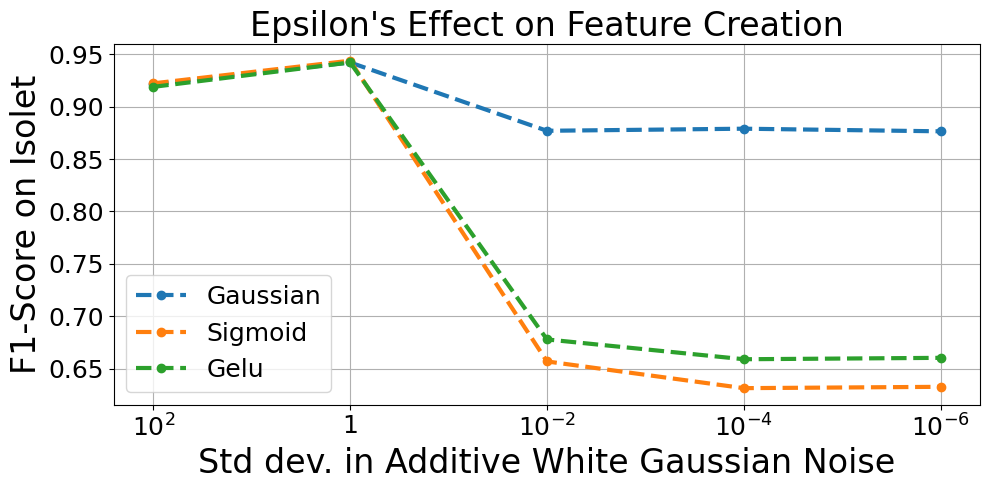

In [127]:
import numpy as np
import matplotlib.pyplot as plt
dataset="isolet"
# Definir los valores de epsilon
epsilons =[0.01,1, 100,10000,1e6]

# Crear una figura
plt.figure(figsize=(10, 5))

n_methods=["Gaussian", "Sigmoid", "Gelu", "Random"]
for c,method in enumerate(["gaussian", "sigmoid","gelu"]): 
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()

    means = []
    stds = []

    # Recopilar los valores de media y desviación estándar para cada epsilon
    for epsilon in epsilons:
        [training, testing, training_t, testing_t] = dict_results_2[method+str(epsilon)]
        
        # Calcular la media y la desviación estándar del "F1 Score" en testing
        mean_f1 = np.mean([i[0]["F1 Score"] for i in testing])
        std_f1 = np.std([i[0]["F1 Score"] for i in testing])
        
        # Guardar los valores para graficar
        means.append(mean_f1)
        stds.append(std_f1)
    # Graficar la media con una línea sólida
    plt.plot(epsilons, means, linestyle='--', marker='o',label=f'{n_methods[c]}', linewidth= 3)

    # Graficar la desviación estándar como un área sombreada con transparencia
    #plt.fill_between(epsilons, np.array(means) - np.array(stds), np.array(means) + np.array(stds), 
     #                alpha=0.3)

# Configurar las etiquetas y el título del gráfico
plt.xscale('log')  # Escala logarítmica en el eje x
plt.xticks(epsilons, labels=["$10^{2}$", "$1$","$10^{-2}$","$10^{-4}$","$10^{-6}$"],fontsize=18)  # Asegurar que solo se muestren los valores de epsilon en la lista
plt.xlabel('Std dev. in Additive White Gaussian Noise',fontsize=24)
plt.ylabel('F1-Score on Isolet',fontsize=24)
plt.title("Epsilon's Effect on Feature Creation",fontsize=24)
plt.tick_params(axis='y', labelsize=18)
plt.legend(loc= "lower left",fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig('isolet_epsilon.png', dpi=400)
plt.show()

### coil100

In [149]:
for method in ["gaussian", "sigmoid","gelu"]:
    print(method)
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()

    for epsilon in [0.01,1, 100,10000,1e6]:
        [training,testing,training_t,testing_t] = dict_results_2[method+str(epsilon)]
        #print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
        print(epsilon)
        print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    

gaussian
0.01
testing after 10:  0.9213160000000002  +-  0.007343532120172125
1
testing after 10:  0.9422350000000002  +-  0.005254606074673916
100
testing after 10:  0.8770100000000001  +-  0.00578054149712637
10000
testing after 10:  0.8790049999999999  +-  0.006261350094029235
1000000.0
testing after 10:  0.876501  +-  0.00518466286271345
sigmoid
0.01
testing after 10:  0.922282  +-  0.006782238273608503
1
testing after 10:  0.943916  +-  0.004957451361334793
100
testing after 10:  0.656814  +-  0.00859503949961836
10000
testing after 10:  0.63132  +-  0.010456106349879958
1000000.0
testing after 10:  0.632594  +-  0.008030155913803934
gelu
0.01
testing after 10:  0.9189419999999998  +-  0.004749793258658749
1
testing after 10:  0.9422369999999999  +-  0.005282550614996531
100
testing after 10:  0.677829  +-  0.0040262872475768504
10000
testing after 10:  0.658915  +-  0.005653777940457161
1000000.0
testing after 10:  0.660257  +-  0.006869607048441703


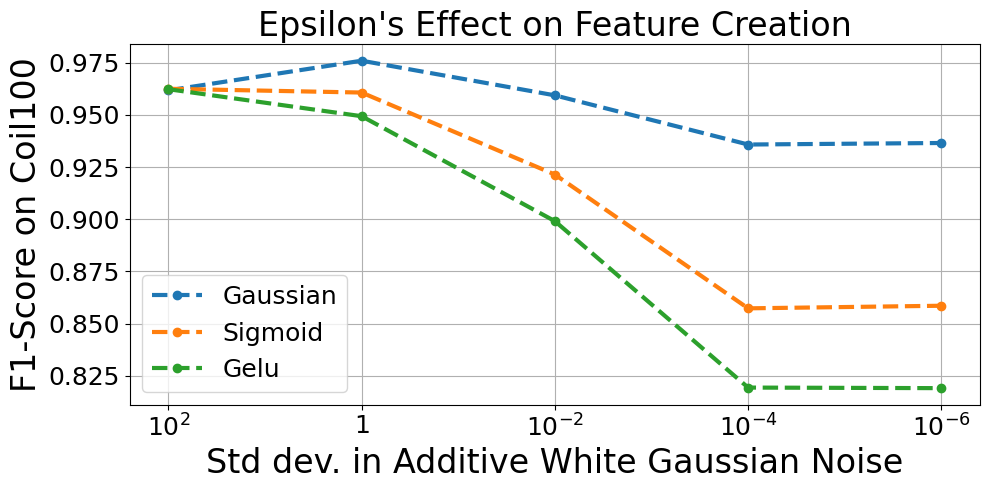

In [128]:
import numpy as np
import matplotlib.pyplot as plt
# Definir los valores de epsilon
epsilons =[0.01,1, 100,10000,1e6]
dataset="coil100"
# Crear una figura
plt.figure(figsize=(10, 5))

n_methods=["Gaussian", "Sigmoid", "Gelu", "Random"]
for c,method in enumerate(["gaussian", "sigmoid","gelu"]): 
    dict_results_2= np.load(f'experiments/{method}/{dataset}/epsilon.npy', allow_pickle=True).item()

    means = []
    stds = []

    # Recopilar los valores de media y desviación estándar para cada epsilon
    for epsilon in epsilons:
        [training, testing, training_t, testing_t] = dict_results_2[method+str(epsilon)]
        
        # Calcular la media y la desviación estándar del "F1 Score" en testing
        mean_f1 = np.mean([i[0]["F1 Score"] for i in testing])
        std_f1 = np.std([i[0]["F1 Score"] for i in testing])
        
        # Guardar los valores para graficar
        means.append(mean_f1)
        stds.append(std_f1)

    # Graficar la media con una línea sólida
    plt.plot(epsilons, means, linestyle='--', marker='o',label=f'{n_methods[c]}', linewidth= 3)

    # Graficar la desviación estándar como un área sombreada con transparencia
    #plt.fill_between(epsilons, np.array(means) - np.array(stds), np.array(means) + np.array(stds), 
     #                alpha=0.3)

# Configurar las etiquetas y el título del gráfico
plt.xscale('log')  # Escala logarítmica en el eje x
plt.xticks(epsilons, labels=["$10^{2}$", "$1$","$10^{-2}$","$10^{-4}$","$10^{-6}$"],fontsize=18)  # Asegurar que solo se muestren los valores de epsilon en la lista
plt.xlabel('Std dev. in Additive White Gaussian Noise',fontsize=24)
plt.ylabel('F1-Score on Coil100',fontsize=24)
plt.title("Epsilon's Effect on Feature Creation",fontsize=24)
plt.tick_params(axis='y', labelsize=18)
plt.legend(loc= "lower left",fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig('epsilon_coil100.png', dpi=400)
plt.show()

### d and c

In [30]:
dataset= "mnist"
regularizations= [1E-14,1E-12,1E-10, 1E-8, 1E-6, 1E-4]
ds= [5, 10, 15, 20,25]

for method in ["gaussian", "sigmoid","gelu","random"]:
    for reg in regularizations:
        for d in ds:
            model= BLS( reg , d, 10, 100,sampling=method,task= "classification")
            (train_acc,train_time)=model.train(train_x,train_y)
            (test_acc,test_time)=model.inference(test_x,test_y)
            outputs= np.array({"train":[train_acc,train_time], "test": [test_acc,test_time] })
            np.save(f'experiments/{method}/{dataset}/output_{reg}_{d}.npy', outputs)
            del outputs
            del model

dim: Z: 50  and H:  500
Training classic accurate is {'Accuracy': 0.90408, 'F1 Score': 0.90357}
Testing classic accurate is {'Accuracy': 0.9088, 'F1 Score': 0.9083}
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.9315, 'F1 Score': 0.93143}
Testing classic accurate is {'Accuracy': 0.9324, 'F1 Score': 0.93221}
dim: Z: 150  and H:  1500
Training classic accurate is {'Accuracy': 0.93907, 'F1 Score': 0.93899}
Testing classic accurate is {'Accuracy': 0.9353, 'F1 Score': 0.93517}
dim: Z: 200  and H:  2000
Training classic accurate is {'Accuracy': 0.9506, 'F1 Score': 0.95058}
Testing classic accurate is {'Accuracy': 0.946, 'F1 Score': 0.94591}
dim: Z: 250  and H:  2500
Training classic accurate is {'Accuracy': 0.95847, 'F1 Score': 0.95845}
Testing classic accurate is {'Accuracy': 0.9522, 'F1 Score': 0.95215}
dim: Z: 50  and H:  500
Training classic accurate is {'Accuracy': 0.90413, 'F1 Score': 0.90363}
Testing classic accurate is {'Accuracy': 0.9085, 'F1 Score': 0.90797}


Training classic accurate is {'Accuracy': 0.95995, 'F1 Score': 0.95994}
Testing classic accurate is {'Accuracy': 0.9518, 'F1 Score': 0.95176}
dim: Z: 50  and H:  500
Training classic accurate is {'Accuracy': 0.88892, 'F1 Score': 0.88838}
Testing classic accurate is {'Accuracy': 0.8944, 'F1 Score': 0.89376}
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.92955, 'F1 Score': 0.92944}
Testing classic accurate is {'Accuracy': 0.9315, 'F1 Score': 0.93135}
dim: Z: 150  and H:  1500
Training classic accurate is {'Accuracy': 0.93872, 'F1 Score': 0.93867}
Testing classic accurate is {'Accuracy': 0.9374, 'F1 Score': 0.93729}
dim: Z: 200  and H:  2000
Training classic accurate is {'Accuracy': 0.94907, 'F1 Score': 0.94903}
Testing classic accurate is {'Accuracy': 0.9444, 'F1 Score': 0.9443}
dim: Z: 250  and H:  2500
Training classic accurate is {'Accuracy': 0.95293, 'F1 Score': 0.95291}
Testing classic accurate is {'Accuracy': 0.9482, 'F1 Score': 0.94814}
dim: Z: 50  and H:  5

Training classic accurate is {'Accuracy': 0.9561, 'F1 Score': 0.95602}
Testing classic accurate is {'Accuracy': 0.9469, 'F1 Score': 0.94679}
dim: Z: 250  and H:  2500
Training classic accurate is {'Accuracy': 0.9643, 'F1 Score': 0.96426}
Testing classic accurate is {'Accuracy': 0.9528, 'F1 Score': 0.95273}
dim: Z: 50  and H:  500
Training classic accurate is {'Accuracy': 0.87362, 'F1 Score': 0.8726}
Testing classic accurate is {'Accuracy': 0.8753, 'F1 Score': 0.87429}
dim: Z: 100  and H:  1000
Training classic accurate is {'Accuracy': 0.92873, 'F1 Score': 0.92849}
Testing classic accurate is {'Accuracy': 0.925, 'F1 Score': 0.92474}
dim: Z: 150  and H:  1500
Training classic accurate is {'Accuracy': 0.9469, 'F1 Score': 0.94677}
Testing classic accurate is {'Accuracy': 0.9392, 'F1 Score': 0.93908}
dim: Z: 200  and H:  2000
Training classic accurate is {'Accuracy': 0.9571, 'F1 Score': 0.95704}
Testing classic accurate is {'Accuracy': 0.9495, 'F1 Score': 0.94941}
dim: Z: 250  and H:  2500


In [33]:
dataset= "mnist"
regularizations= [1E-14,1E-12] #,1E-10, 1E-8, 1E-6, 1E-4]
ds= [10] #[5, 10, 15, 20,25]
max_methods={}
for d in ds:
    for method in ["gaussian", "sigmoid","gelu","random"]:
        print(method)
        max_acc=0
        for reg in regularizations:
            outputs= np.load(f'experiments/{method}/{dataset}/output_{reg}_{d}.npy', allow_pickle=True)
            test_acc= outputs.item()["train"][0][0][0]['F1 Score'] #np.abs(outputs.item()["train"][0][0][0]['F1 Score']- outputs.item()["test"][0][0]['F1 Score'])
            if test_acc> max_acc:
                max_acc= test_acc
                lecture_max= f'experiments/{method}/{dataset}/output_{reg}_{d}.npy'
    max_methods[method]=lecture_max
    print(max_acc)
print(max_methods)

gaussian
sigmoid
gelu
random
0.92752
{'random': 'experiments/random/mnist/output_1e-14_10.npy'}


In [34]:
for d in ds:
    print(d)
    dict_r={}
    #outputs= np.load(f'experiments/{method}/{dataset}/output_{1e-9}_{d}.npy', allow_pickle=True)
    #test_acc= outputs.item()["test"][0][0]['F1 Score']
    #dict_r["random"]= test_acc
    for method in ["gaussian", "sigmoid","gelu", "random"]:
        max_=0
        for reg in regularizations:  
            outputs= np.load(f'experiments/{method}/{dataset}/output_{reg}_{d}.npy', allow_pickle=True)
            test_acc= outputs.item()["test"][0][0]['F1 Score']
            if test_acc>max_:
                max_=test_acc
                reg_max= reg
        dict_r[method]= (max_,reg_max)
        """
        outputs= np.load(f'experiments/{method}/{dataset}/output_{1E-8}_{d}.npy', allow_pickle=True)
        test_acc= outputs.item()["test"][0][0]['F1 Score']
        dict_r[method]= (test_acc,1E-8)
            #print(test_acc)
        """
    #if dict_r["random"][0]<dict_r["gaussian"][0] and dict_r["random"][0]<dict_r["gelu"][0] and dict_r["random"][0]<dict_r["sigmoid"][0]:
    print(dict_r)

10
{'gaussian': (0.8874, 1e-14), 'sigmoid': (0.90258, 1e-12), 'gelu': (0.89239, 1e-12), 'random': (0.92345, 1e-14)}


In [35]:
for method in ["gaussian", "sigmoid","gelu", "random"]:
    print(method)
    outputs= np.load(f'experiments/{method}/{dataset}/output_{1E-8}_{10}.npy', allow_pickle=True)
    test_acc= outputs.item()["test"][0][0]['F1 Score']
    print(test_acc)

gaussian
0.88637
sigmoid
0.90001
gelu
0.8892
random
0.9221


In [31]:
import numpy as np
import matplotlib.pyplot as plt

dataset = "mnist"
regularizations= [1E-14,1E-12,1E-10, 1E-8, 1E-6, 1E-4]
ds= [5, 10, 15, 20,25]
matrices=[]
matrices_g=[]


for idx, method in enumerate(["gaussian", "sigmoid", "gelu", "random"]):
    matrix = np.zeros((len(ds), len(regularizations)))  # 5 filas (para ds) y 4 columnas (para regularizations)
    matrix_g = np.zeros((len(ds), len(regularizations)))
    for i, d in enumerate(ds):
        for j, reg in enumerate(regularizations):
            outputs = np.load(f'experiments/{method}/{dataset}/output_{reg}_{d}.npy', allow_pickle=True)
            matrix[i, j] = outputs.item()["test"][0][0]['F1 Score']  # La fila es i (ds) y la columna es j (regularizations
            matrix_g[i, j] = outputs.item()["train"][0][0][0]['F1 Score'] - outputs.item()["test"][0][0]['F1 Score']
    matrices.append(matrix)
    matrices_g.append(matrix_g)


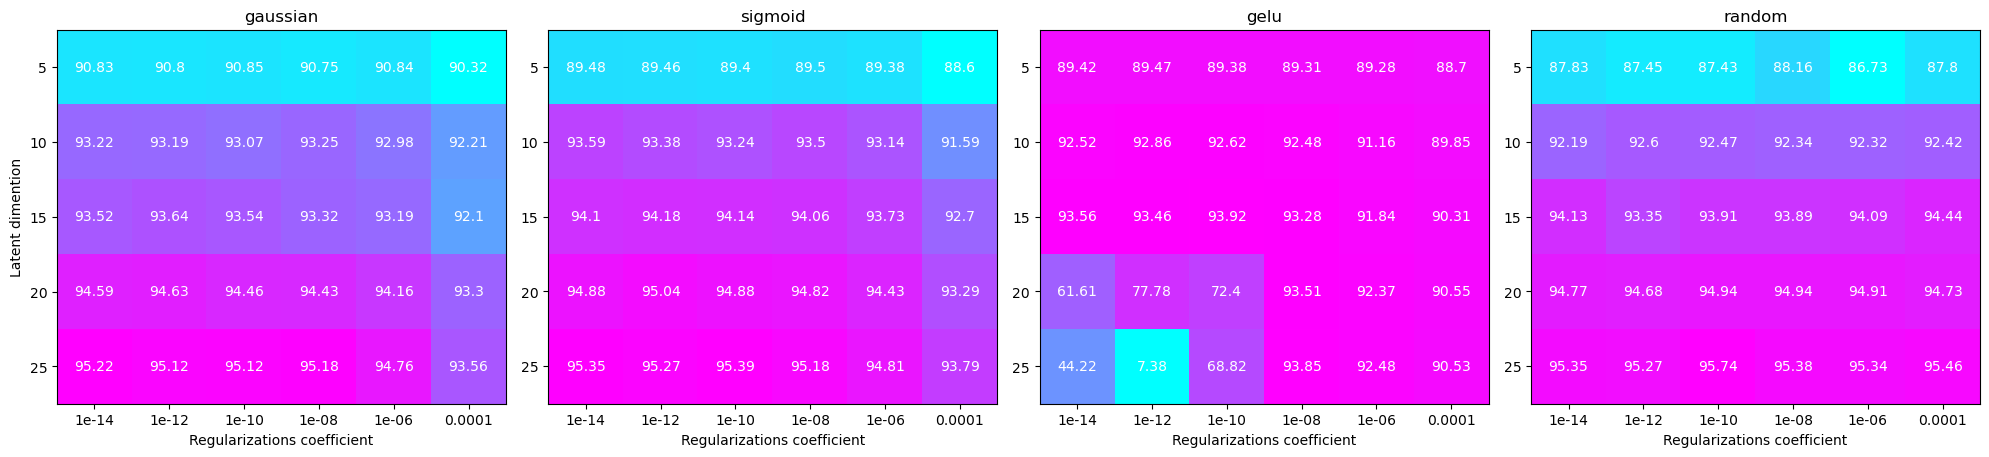

In [32]:
# Crear una figura con una fila y cuatro columnas
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Una fila, cuatro columnas
for idx, method in enumerate(["gaussian", "sigmoid", "gelu", "random"]):
    # Visualización de correlación en el subplot correspondiente
    im = axs[idx].imshow(matrices[idx], cmap='cool', interpolation='nearest')
    axs[idx].set_title(f'{method}')

    # Etiquetas de los ejes
    axs[idx].set_xticks(np.arange(len(regularizations)))
    axs[idx].set_xticklabels(regularizations)
    axs[idx].set_yticks(np.arange(len(ds)))
    axs[idx].set_yticklabels(ds)

    axs[idx].set_xlabel('Regularizations coefficient')
    if idx == 0:
        axs[idx].set_ylabel('Latent dimention')
    # Añadir los valores dentro de cada bloque
    for i in range(matrices[idx].shape[0]):  # Recorrer filas (ds)
        for j in range(matrices[idx].shape[1]):  # Recorrer columnas (regularizations)
            value = round(matrices[idx][i, j]*100, 2)  # Redondear a 2 decimales
            axs[idx].text(j, i, value, ha='center', va='center', color='white')  # Añadir texto en el centro de cada bloque

# Mostrar la figura
plt.tight_layout()
plt.show()


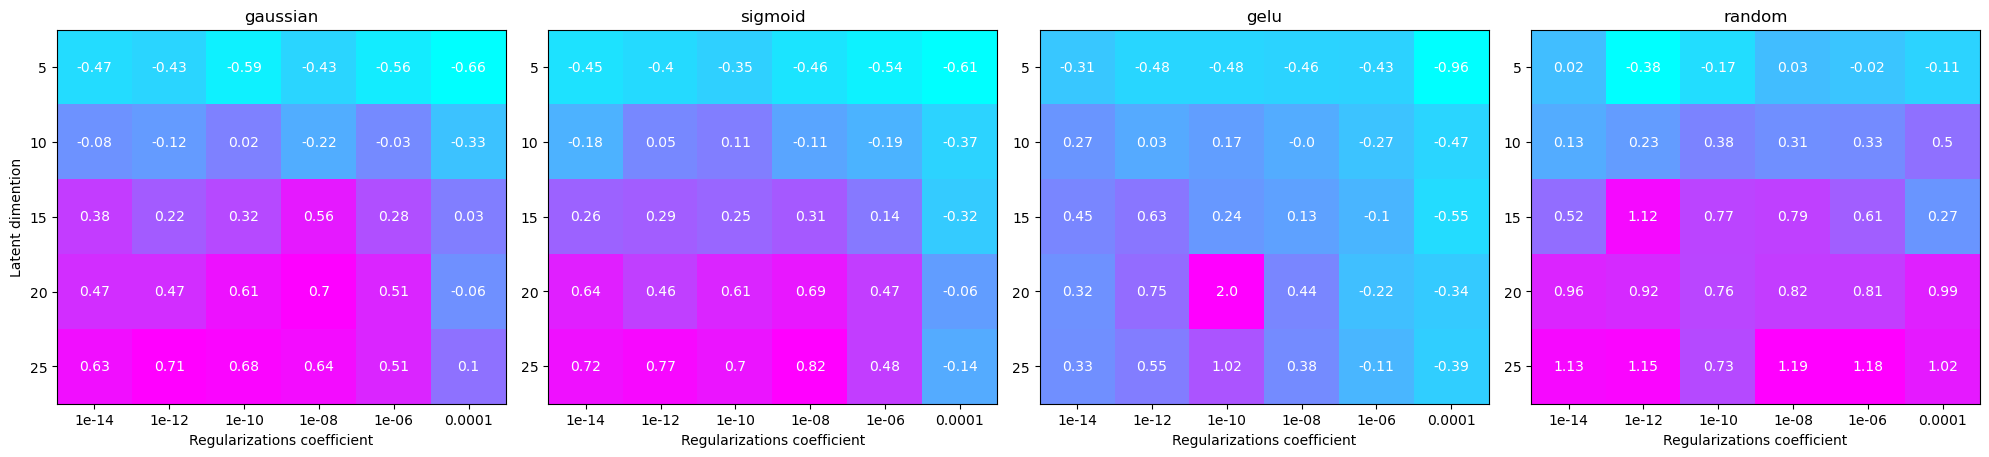

In [33]:
# Crear una figura con una fila y cuatro columnas
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Una fila, cuatro columnas
for idx, method in enumerate(["gaussian", "sigmoid", "gelu", "random"]):
    # Visualización de correlación en el subplot correspondiente
    im = axs[idx].imshow(matrices_g[idx], cmap='cool', interpolation='nearest')
    axs[idx].set_title(f'{method}')

    # Etiquetas de los ejes
    axs[idx].set_xticks(np.arange(len(regularizations)))
    axs[idx].set_xticklabels(regularizations)
    axs[idx].set_yticks(np.arange(len(ds)))
    axs[idx].set_yticklabels(ds)

    axs[idx].set_xlabel('Regularizations coefficient')
    if idx == 0:
        axs[idx].set_ylabel('Latent dimention')
    # Añadir los valores dentro de cada bloque
    for i in range(matrices_g[idx].shape[0]):  # Recorrer filas (ds)
        for j in range(matrices_g[idx].shape[1]):  # Recorrer columnas (regularizations)
            value = round(matrices_g[idx][i, j]*100, 2)  # Redondear a 2 decimales
            axs[idx].text(j, i, value, ha='center', va='center', color='white')  # Añadir texto en el centro de cada bloque

# Mostrar la figura
plt.tight_layout()
plt.show()


take d=15 and c=E-9 because we see in our methods good enough performance, and we take in random the same to be comparable (and very similar to the literature).

### correlation matrix

In [67]:
 model.basisH[:, model.d*i:model.d*(i+1)] 

array([[-11.29466695,  -7.34407436,   8.17877811, ...,  -3.11647027,
          0.15483348,   7.81674717],
       [-15.12589034,  -9.12987513, -18.62104297, ..., -18.13925655,
         -4.56021954,   9.74906179],
       [  3.68452221, -17.21134888, -15.44366474, ..., -16.93577454,
          6.39214322,  24.33860955],
       ...,
       [ 20.52613732,  10.88019639, -14.32674575, ...,  -6.17960112,
          7.69404453, -16.45043148],
       [  0.43577885,   8.31464507, -18.33814117, ...,  15.42714445,
         -4.49482953,  -4.80515364],
       [-14.8938461 ,   0.39769229,   9.0128527 , ...,  -6.78659579,
         -9.3540312 ,  -5.96867051]])

dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000


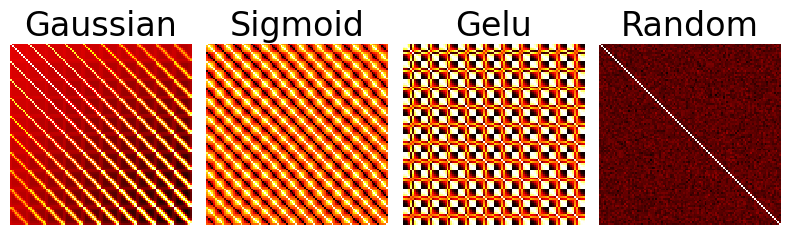

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 16))

for c,method in enumerate(["gaussian", "sigmoid","gelu","random"]):

    model= BLS( 1E-8 , 10, 10, 100,sampling=[method,method],task= "classification")
    (train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
    (test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
    o_test = np.dot(InputOfOutputLayerTest,OutputWeight_A)
    (curve,learned_curve_x,learned_curve,representative_examples)= model.retrieve(0, 134, test_x[0,:])
    # Medir correlación entre nodos de características

    Z = np.zeros([train_x.shape[1], model.n * model.d])
    
    for i in range(model.n):
            Z[:, model.d*i:model.d*(i+1)] = model.basis[:, model.d*i:model.d*(i+1)] #basisH m 

        # Matriz de correlación
    corr_matrix = np.corrcoef(Z.T)
    #plt.colorbar()
    #plt.show()
    # Plot the normalized matrix
    axes[c].imshow(corr_matrix, cmap='hot', interpolation='nearest')
    axes[c].set_title(method.capitalize(), fontsize=24)

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.savefig('correlation_features.png', dpi=400)
#plt.savefig('correlation_enhaced_features.png', dpi=400)
plt.show()



## Experiments

### Incremental

#### abalone

In [149]:
dataset="abalone"
reg,d= 1E-3,6
for method in ["gaussian", "sigmoid", "gelu", "random"]:   #gaussian
    dict_results={}
    global_incremental=[]
    for t in [1]:
        print(method)
        model= BLS( reg , d, 10, 10,sampling=[method,method],task= "regression")    
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)

            # incremental learning 4 xdxm
        (test_acc_incremental,test_time_incremental,train_acc_incremental,train_time_incremental)= model.AddEnhanceNodes(9,10,train_x,train_y, test_x,test_y)
        global_incremental.append((test_acc_incremental,test_time_incremental,train_acc_incremental,train_time_incremental))
        del model
    dict_results["incremental"]= global_incremental
    np.save(f'experiments/{method}/{dataset}/incremental_10_10_{reg}_{d}.npy', dict_results)

gaussian
last dim: (2784, 120)  and new dim:  (2784, 60) so:  (2784, 180)
Incremental Training Accuracy is : {'RMSE': 0.07845, 'MAE': 0.0568}
Incremental Testing Accuracy is :  {'RMSE': 0.07176, 'MAE': 0.05425}
last dim: (2784, 180)  and new dim:  (2784, 60) so:  (2784, 240)
Incremental Training Accuracy is : {'RMSE': 0.07824, 'MAE': 0.05658}
Incremental Testing Accuracy is :  {'RMSE': 0.07155, 'MAE': 0.05403}
last dim: (2784, 240)  and new dim:  (2784, 60) so:  (2784, 300)
Incremental Training Accuracy is : {'RMSE': 0.07794, 'MAE': 0.05642}
Incremental Testing Accuracy is :  {'RMSE': 0.07156, 'MAE': 0.05392}
last dim: (2784, 300)  and new dim:  (2784, 60) so:  (2784, 360)
Incremental Training Accuracy is : {'RMSE': 0.07791, 'MAE': 0.05636}
Incremental Testing Accuracy is :  {'RMSE': 0.07164, 'MAE': 0.05385}
last dim: (2784, 360)  and new dim:  (2784, 60) so:  (2784, 420)
Incremental Training Accuracy is : {'RMSE': 0.07826, 'MAE': 0.05662}
Incremental Testing Accuracy is :  {'RMSE': 0.

#### Housing

In [36]:
dataset="housing"
reg,d= 1E-8,8
for method in ["gaussian", "sigmoid", "gelu", "random"]:   #gaussian
    dict_results={}
    global_incremental=[]
    for t in [1]:
        print(method)
        model= BLS( reg , d, 10, 10,sampling=[method,method],task= "regression", epsilon=100)    
        (train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
        (test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)

            # incremental learning 4 xdxm
        (test_acc_incremental,test_time_incremental,train_acc_incremental,train_time_incremental)= model.AddEnhanceNodes(9,10,train_x,train_y, test_x,test_y)
        global_incremental.append((test_acc_incremental,test_time_incremental,train_acc_incremental,train_time_incremental))
        del model
    dict_results["incremental"]= global_incremental
    np.save(f'experiments/{method}/{dataset}/incremental_10_100_{reg}_{d}.npy', dict_results)

gaussian
last dim: (16512, 160)  and new dim:  (16512, 80) so:  (16512, 240)
Incremental Training Accuracy is : {'RMSE': 0.54031, 'MAE': 0.38496}
Incremental Testing Accuracy is :  {'RMSE': 6.30167, 'MAE': 0.4886}
last dim: (16512, 240)  and new dim:  (16512, 80) so:  (16512, 320)
Incremental Training Accuracy is : {'RMSE': 0.55173, 'MAE': 0.39608}
Incremental Testing Accuracy is :  {'RMSE': 19.62797, 'MAE': 0.70638}
last dim: (16512, 320)  and new dim:  (16512, 80) so:  (16512, 400)
Incremental Training Accuracy is : {'RMSE': 0.59298, 'MAE': 0.42166}
Incremental Testing Accuracy is :  {'RMSE': 30.58062, 'MAE': 0.90187}
last dim: (16512, 400)  and new dim:  (16512, 80) so:  (16512, 480)
Incremental Training Accuracy is : {'RMSE': 0.66014, 'MAE': 0.45873}
Incremental Testing Accuracy is :  {'RMSE': 38.67841, 'MAE': 1.06431}
last dim: (16512, 480)  and new dim:  (16512, 80) so:  (16512, 560)
Incremental Training Accuracy is : {'RMSE': 0.74927, 'MAE': 0.50486}
Incremental Testing Accuracy

In [ ]:
# Example usage:
data = { #initial mean - final mean
    "Gaussian": [0.935024, 0.9740160000000001],
    "Sigmoid": [0.925511 ,  0.971455],
    "Gelu": [0.9274450000000002, 0.972869],
    "Random": [0.9237,0.96926]
}

data["Gaussian"]= [data["Gaussian"][0]] + [i["F1 Score"] for i in dict_results["incremental"][0][0]] +[data["Gaussian"][1]]
data["Sigmoid"]= [data["Sigmoid"][0]] + [i["F1 Score"] for i in dict_results_s["incremental"][0][0]] +[data["Sigmoid"][1]]
data["Gelu"]= [data["Gelu"][0]] + [i["F1 Score"] for i in dict_results_g["incremental"][0][0]] +[data["Gelu"][1]]
data["Random"]= [data["Random"][0]] + [i["F1 Score"] for i in dict_results_r["incremental"][0][0]] +[data["Random"][1]]

latex_code = dict_to_latex_table(data, caption="Sample Table", label="tab:sample")
print(latex_code)

#### MNIST

In [72]:
dataset="mnist"
reg,d= 1E-8,10

In [52]:
for method in ["gelu"]: #["gaussian", "sigmoid", "gelu", "random"]:   #gaussian
    dict_results={}
    global_incremental=[]
    for t in [1]:
        print(method)
        model= BLS( reg , d, 10, 100,sampling=[method,method],task= "classification")    
        (train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
        (test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)

            # incremental learning 4 xdxm
        (test_acc_incremental,test_time_incremental,train_acc_incremental,train_time_incremental)= model.AddEnhanceNodes(9,100,train_x,train_y, test_x,test_y)
        global_incremental.append((test_acc_incremental,test_time_incremental,train_acc_incremental,train_time_incremental))
        del model
    dict_results["incremental"]= global_incremental
    np.save(f'experiments/{method}/{dataset}/incremental_10_100_{reg}_{d}.npy', dict_results)

gelu
dim: Z: 100  and H:  1000
last dim: (60000, 1100)  and new dim:  (60000, 1000) so:  (60000, 2100)
Incremental Training Accuracy is : {'Accuracy': 0.95637, 'F1 Score': 0.95633}
Incremental Testing Accuracy is :  {'Accuracy': 0.9472, 'F1 Score': 0.94711}
last dim: (60000, 2100)  and new dim:  (60000, 1000) so:  (60000, 3100)
Incremental Training Accuracy is : {'Accuracy': 0.96665, 'F1 Score': 0.96663}
Incremental Testing Accuracy is :  {'Accuracy': 0.9567, 'F1 Score': 0.95665}
last dim: (60000, 3100)  and new dim:  (60000, 1000) so:  (60000, 4100)
Incremental Training Accuracy is : {'Accuracy': 0.97312, 'F1 Score': 0.97311}
Incremental Testing Accuracy is :  {'Accuracy': 0.9601, 'F1 Score': 0.96007}
last dim: (60000, 4100)  and new dim:  (60000, 1000) so:  (60000, 5100)
Incremental Training Accuracy is : {'Accuracy': 0.97713, 'F1 Score': 0.97712}
Incremental Testing Accuracy is :  {'Accuracy': 0.9611, 'F1 Score': 0.96106}
last dim: (60000, 5100)  and new dim:  (60000, 1000) so:  (60

In [73]:
dict_results= np.load(f'experiments/gaussian/{dataset}/incremental_10_100_{reg}_{d}.npy', allow_pickle=True).item()
dict_results_s= np.load(f'experiments/sigmoid/{dataset}/incremental_10_100_{reg}_{d}.npy', allow_pickle=True).item()
dict_results_g= np.load(f'experiments/gelu/{dataset}/incremental_10_100_{reg}_{d}.npy', allow_pickle=True).item()
dict_results_r= np.load(f'experiments/random/{dataset}/incremental_10_100_{reg}_{d}.npy', allow_pickle=True).item()


In [29]:
dict_results_r["incremental"][0][3]

[10.474215030670166,
 14.285443305969238,
 18.021664142608643,
 22.181052923202515,
 31.762879848480225,
 39.36090016365051,
 45.936503410339355,
 78.71274924278259,
 200.23807764053345]

In [28]:
dict_results["incremental"][0][3]

[11.280143022537231,
 20.645222663879395,
 19.9471652507782,
 25.233324766159058,
 30.041417360305786,
 39.36353945732117,
 52.478503942489624,
 90.27563667297363,
 134.3889365196228]

In [ ]:
[i["F1 Score"] for i in dict_results["incremental"][0][0]]

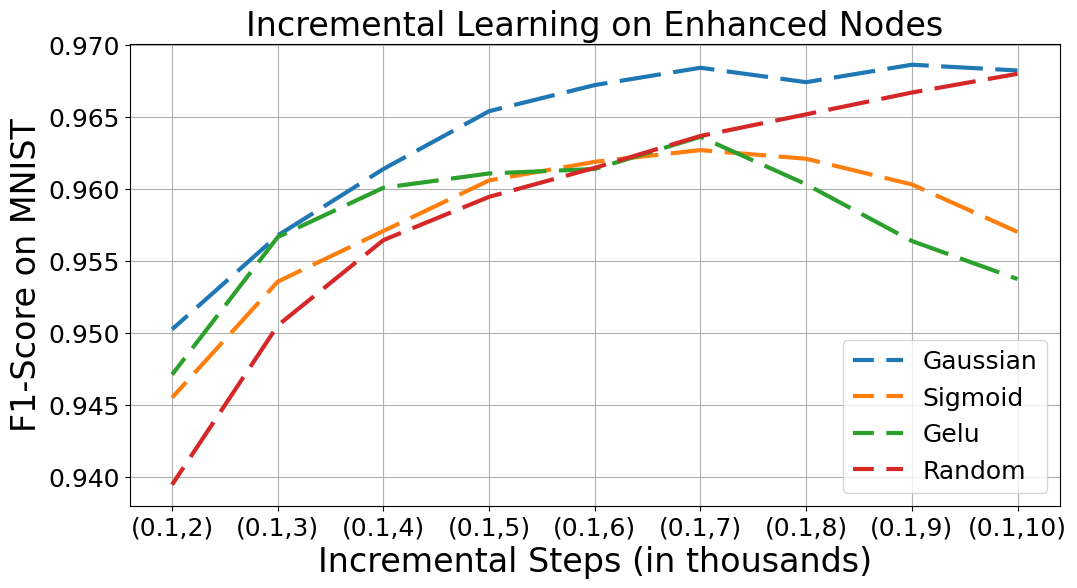

In [82]:
x= list(range(1,10))
# Crear una figura
plt.figure(figsize=(12, 6))

n_methods=["Gaussian", "Sigmoid", "Gelu", "Random"]


# Graficar la media con una línea sólida
plt.plot(x, [i["F1 Score"] for i in dict_results["incremental"][0][0]], linestyle=(5, (10, 3)), label="Gaussian",color='C0',linewidth=3)
plt.plot(x, [i["F1 Score"] for i in dict_results_s["incremental"][0][0]], linestyle=(5, (10, 3)), label="Sigmoid",color='C1',linewidth=3)
plt.plot(x, [i["F1 Score"] for i in dict_results_g["incremental"][0][0]], linestyle=(5, (10, 3)), label="Gelu",color='C2',linewidth=3)
plt.plot(x, [i["F1 Score"] for i in dict_results_r["incremental"][0][0]], linestyle=(5, (10, 3)), label="Random",color='C3',linewidth=3)

"""

plt.plot(x, [i["F1 Score"] for i in dict_results["incremental"][0][2]],label="Gaussian", color='C0')
plt.plot(x, [i["F1 Score"] for i in dict_results_s["incremental"][0][2]],label="Sigmoid", color='C1')
plt.plot(x, [i["F1 Score"] for i in dict_results_g["incremental"][0][2]],label="Gelu", color='C2')
plt.plot(x, [i["F1 Score"] for i in dict_results_r["incremental"][0][2]],label="Random", color='C3')

"""
# Configurar las etiquetas y el título del gráfico
plt.xticks(x ,labels=[f"(0.1,{1 + i*1})" for i in x], fontsize=18)  # Asegurar que solo se muestren los valores de epsilon en la lista
plt.xlabel('Incremental Steps (in thousands)',fontsize=24)
plt.ylabel('F1-Score on MNIST',fontsize=24)
plt.title('Incremental Learning on Enhanced Nodes',fontsize=24)
plt.tick_params(axis='y', labelsize=18)
plt.legend(loc="lower right", fontsize=18)
plt.grid(True)
plt.savefig('incremental_mnist.png', dpi=400)
plt.show()

In [39]:
# Example usage:
data = { #initial mean - final mean
    "Gaussian": [0.935024, 0.9740160000000001],
    "Sigmoid": [0.925511 ,  0.971455],
    "Gelu": [0.9274450000000002, 0.972869],
    "Random": [0.9237,0.96926]
}
data={}

data["Gaussian"]= [[ np.round(i["F1 Score"]*100,2) for i in dict_results["incremental"][0][0] ]]
data["Sigmoid"]= [ [np.round(i["F1 Score"]*100,2) for i in dict_results_s["incremental"][0][0] ]]
data["Gelu"]= [ [np.round(i["F1 Score"]*100,2) for i in dict_results_g["incremental"][0][0] ]]
data["Random"]= [[np.round(i["F1 Score"]*100,2) for i in dict_results_r["incremental"][0][0] ]] 
labels=[f"(100,{1000 + i*1000})" for i in range(1,10)]

for j in ["Gaussian","Sigmoid","Gelu","Random"]:
    print(j)
    for c,i in enumerate(labels):
        print("step: ",i, ": ",data[j][0][c])
    print("--"*10)

Gaussian
step:  (100,2000) :  95.02
step:  (100,3000) :  95.68
step:  (100,4000) :  96.14
step:  (100,5000) :  96.54
step:  (100,6000) :  96.72
step:  (100,7000) :  96.84
step:  (100,8000) :  96.74
step:  (100,9000) :  96.86
step:  (100,10000) :  96.82
--------------------
Sigmoid
step:  (100,2000) :  94.55
step:  (100,3000) :  95.36
step:  (100,4000) :  95.71
step:  (100,5000) :  96.06
step:  (100,6000) :  96.19
step:  (100,7000) :  96.27
step:  (100,8000) :  96.21
step:  (100,9000) :  96.03
step:  (100,10000) :  95.7
--------------------
Gelu
step:  (100,2000) :  94.72
step:  (100,3000) :  95.3
step:  (100,4000) :  95.45
step:  (100,5000) :  95.05
step:  (100,6000) :  93.94
step:  (100,7000) :  92.56
step:  (100,8000) :  90.98
step:  (100,9000) :  89.14
step:  (100,10000) :  87.14
--------------------
Random
step:  (100,2000) :  93.95
step:  (100,3000) :  95.05
step:  (100,4000) :  95.64
step:  (100,5000) :  95.94
step:  (100,6000) :  96.14
step:  (100,7000) :  96.37
step:  (100,8000

### classic interpretability view

(10100, 10)
18983.369789787128 -21639.326898886007


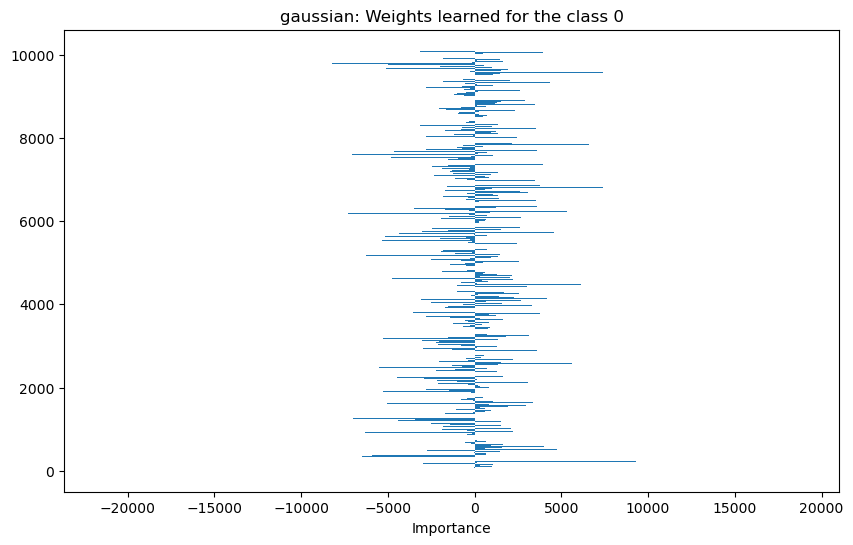

In [62]:
import numpy as np
import matplotlib.pyplot as plt
"""

for method in ["gaussian", "sigmoid","gelu","random"]:
    model= BLS( 1E-9 , 10, 10, 1000,sampling=method,task= "classification")
    dict_results= np.load(f'experiments/{methodthod}/{dataset}/one_ejecution_10_1000_{reg}_{d}.npy', allow_pickle=True)
    [training,testing,training_t,testing_t,OutputWeight_A, InputOfOutputLayerTest,model]= dict_results

    (train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
    (test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
    o_test = np.dot(InputOfOutputLayerTest,OutputWeight_A)
    (curve,learned_curve_x,learned_curve,representative_examples)= model.retrieve(0, 134, test_x[0,:])
"""
clase= 0
weights_class =OutputWeight_A[:,clase]
print(OutputWeight_A.shape)
print(np.max(weights_class), np.min(weights_class))


# 4. Graficar la importancia de los pesos; 
plt.figure(figsize=(10, 6))
plt.barh(np.arange(OutputWeight_A.shape[0]), [i[0] for i in np.array(weights_class[:,0]) ])
plt.xlabel('Importance')
plt.title(f'{method}: Weights learned for the class {clase}')
#plt.xlim(-10, 10)
plt.show()


In [74]:
import numpy as np
from itertools import combinations

def find_class_pair_features(W, epsilon):
    """
    Encuentra dos características para cada par de clases según los criterios especificados.
    
    Parámetros:
    W: np.array -> Matriz de características (d x C)
    epsilon: float -> Umbral de diferencia mínima para la primera característica relevante
    
    Retorna:
    results: dict -> Diccionario con las parejas de clases y sus dos características seleccionadas
    """
    d, C = W.shape  # d = número de características, C = número de clases
    results = {}
    
    for (class1, class2) in combinations(range(C), 2):
        # 1. Primera característica: Diferencia de valor de importancia < epsilon
        relevant_features = []
        for i in range(d):
            if abs(W[i, class1] - W[i, class2]) < epsilon:
                relevant_features.append(i)
        
        if len(relevant_features) == 0:
            first_feature = None
        else:
            # Seleccionar la característica más relevante de las que cumplen la condición
            # Escoger la que tenga el mayor valor promedio entre las dos clases
            first_feature = max(relevant_features, key=lambda x: (W[x, class1] + W[x, class2]) / 2)
        
        # 2. Segunda característica: Positiva para una clase y negativa para la otra
        diff_features = []
        for i in range(d):
            if (W[i, class1] > 0 and W[i, class2] < 0) or (W[i, class1] < 0 and W[i, class2] > 0):
                diff_features.append(i)
        
        if len(diff_features) == 0:
            second_feature = None
        else:
            # Escoger la característica donde la diferencia de valor absoluto sea mayor
            second_feature = max(diff_features, key=lambda x: abs(W[x, class1] - W[x, class2]))
        
        results[(class1, class2)] = {
            "primera_caracteristica": first_feature,
            "segunda_caracteristica": second_feature
        }
    
    return results

# Ejemplo de uso
# W es una matriz de características (d x C), por ejemplo:
#W = np.random.rand(10, 5) * 2 - 1  # Valores entre -1 y 1 (10 características, 5 clases)
epsilon = 10  # Umbral para la diferencia de la primera característica

resultados = find_class_pair_features(OutputWeight_A, epsilon)

In [ ]:
from skimage.segmentation import find_boundaries

def plot_difference_between_two(clases, caracteristicas,OutputWeight_A, model,method,top):
     # Graficar
    x= range(traindata.shape[1])
    digits=[clases[0], clases[1]]
    lines,legend= [],  []
    probabilidades_1 = MinMaxScaler(feature_range=(0, 1)).fit_transform(traindata[trainlabel[:, clases[0]]==1,:][0,:].reshape(-1,1))
    probabilidades_2 =MinMaxScaler(feature_range=(0, 1)).fit_transform(traindata[trainlabel[:, clases[1]]==1,:][0,:].reshape(-1,1))
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
    for digit_position,digit in enumerate(digits):
        if top:
            recorrer=np.argpartition(np.array(OutputWeight_A[:,digit]).reshape(-1,), -2)[-2:]
        else:
            recorrer= [caracteristicas['primera_caracteristica'],caracteristicas['segunda_caracteristica']]
        scaler_curve= np.zeros((784*4))
        for c,top_ in enumerate(recorrer):
            one_example=traindata_o[trainlabel[:, digit]==1,:][0,:]
            one_example_input=traindata[trainlabel[:, digit]==1,:][0,:]
            #mean= np.mean(traindata_o[trainlabel[:, digit]==1,:],axis=0)
            (curve,learned_curve_x,learned_curve,representative_examples)= model.retrieve(digit, top_, one_example_input)
            #if digit_position ==0 and c==0:
            scaler= MinMaxScaler(feature_range=(0, 1)).fit(learned_curve_x.reshape(-1,1))
            probabilidades = scaler.transform(learned_curve_x.reshape(-1,1))
            lines.append(probabilidades)
            """
                # Generamos una lista de 784 valores aleatorios entre 0 y 1
                random_values = probabilidades>0.8
                # Convertimos la lista en una matriz de 28x28
                matrix = random_values.reshape((28, 28))
                # Creamos el heatmap en escala de grises
                plt.imshow(matrix, cmap='gray', interpolation='nearest')
                plt.colorbar()
                plt.title(f'Masked heatmap, digit: {digit}; top: {top_}')
                plt.show()
            """
            contour_original = find_boundaries(one_example.reshape(28,28), mode='thick')
            prob_masked = probabilidades.reshape((28, 28)) #zero_columns_below_top_n(probabilidades.reshape((28, 28)), top_n=10)
            # Mostrar el dígito
            #plt.imshow(mean.reshape(28,28) , cmap='gray', interpolation='none')
            # Superponer la máscara de atención en color con transparencia (alpha)
            # Creamos el heatmap en escala de grises
            axes[digit_position,c].imshow( prob_masked, cmap='jet', alpha=0.5,interpolation='nearest') #autumn
            axes[digit_position,c].contour(contour_original, colors='black')
            legend.append(f'Digit: {digit}; feature: {top_}; weight: {np.round(OutputWeight_A[top_,digit],2)}')
            axes[digit_position,c].set_title(legend[-1])
                # Ajustar la visualización
    for ax in axes.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    """
            #representative of the concept:
            for i in representative_examples[:3]:
                        # Creamos el heatmap en escala de grises
                        plt.imshow(testdata_o[i,:].reshape((28, 28)), cmap='gray', interpolation='nearest')
                        plt.colorbar()
                        plt.title(f'Representative example ({i}) for the feature: {top_}')
                        plt.show()
    """

        
        #plot activation of each basis
    fig, ax = plt.subplots(figsize=(8, 6)) 
    #ax.plot(x, lines[0],  linestyle='-', linewidth=0.5, label=f'Similar', color='red')
    
    ax.plot(x, lines[0],  ".", markersize=1, label=legend[0], color='red')
    ax.plot(x, lines[1],  ".", markersize=1, label=legend[1], color='blue')
    ax.plot(x, probabilidades_1, 'o' , markersize=5,label=f' digit {clases[0]}',color='palegreen', alpha= 0.5)
    plt.xlabel('Input features')
    plt.ylabel('Activation value')
    plt.title('Learned curves: '+ method)
            #plt.xticks(x)
    plt.ylim(0, 1)
    plt.grid(True)
        # Create the legend
    plt.legend(title='Basis', loc='upper right')  # Place legend in upper left corner
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8, 6)) 
    ax.plot(x, lines[2],  ".",  markersize=1, label=legend[2], color='red') 
    ax.plot(x, lines[3],   ".", markersize=1, label=legend[3],color='blue') 
    ax.plot(x, probabilidades_2, 'o' , markersize=5,label=f' digit {clases[1]}', color='palegreen',  alpha= 0.5)
    plt.xlabel('Input features')
    plt.ylabel('Activation value')
    plt.title('Learned curves: '+ method)
            #plt.xticks(x)
    plt.ylim(0, 1)
    plt.grid(True)
        # Create the legend
    plt.legend(title='Basis', loc='upper right')  # Place legend in upper left corner
    plt.show()
    
    #ax.plot(x, np.mean(traindata_o[trainlabel[:, clases[0]]==1,:],axis=0), 'o' , markersize=5,label=f'mean digit {clases[0]}',color='blue', alpha= 0.1)
    #ax.plot(x, np.mean(traindata_o[trainlabel[:, clases[1]]==1,:],axis=0), 'o' , markersize=5,label=f'mean digit {clases[1]}', color='green',  alpha= 0.1)
    """
    
    from matplotlib.cbook import get_sample_data
    img = plt.imread(get_sample_data('logo2.png'))
    # Definir la posición donde se colocará la imagen (en coordenadas de datos)
    x_pos, y_pos = 100, 0.5
    # Crear una instancia de la imagen
    imagebox = OffsetImage(img, zoom=0.2)  # Puedes ajustar el 'zoom' para cambiar el tamaño de la imagen
    ab = AnnotationBbox(imagebox, (x_pos, y_pos), frameon=False)
    # Añadir la imagen a la gráfica
    ax.add_artist(ab)
    """

dim: Z: 100  and H:  100
Training classic accurate is 84.30199999999999 %
Testing classic accurate is 84.72 %


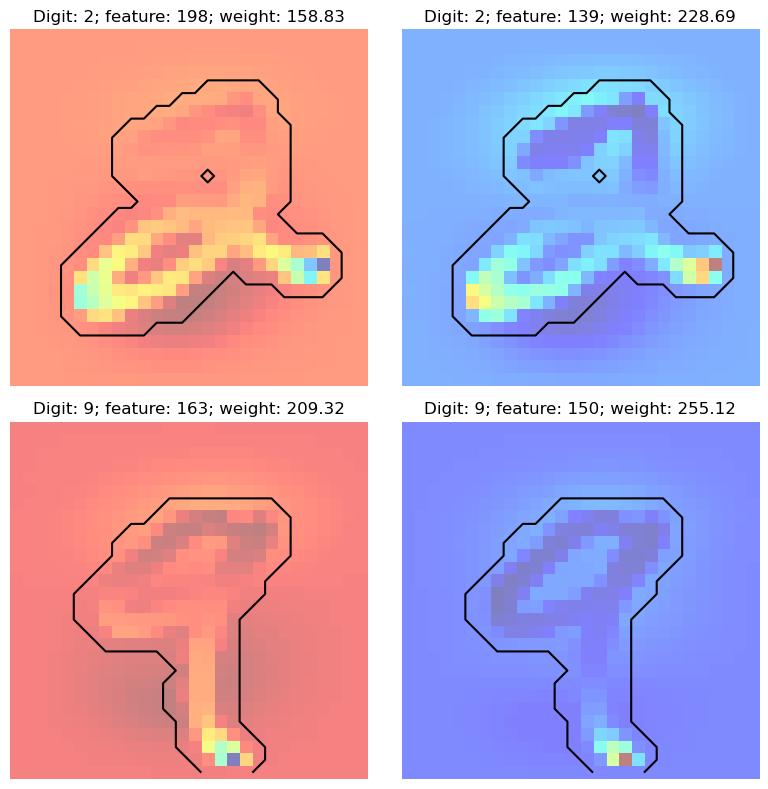

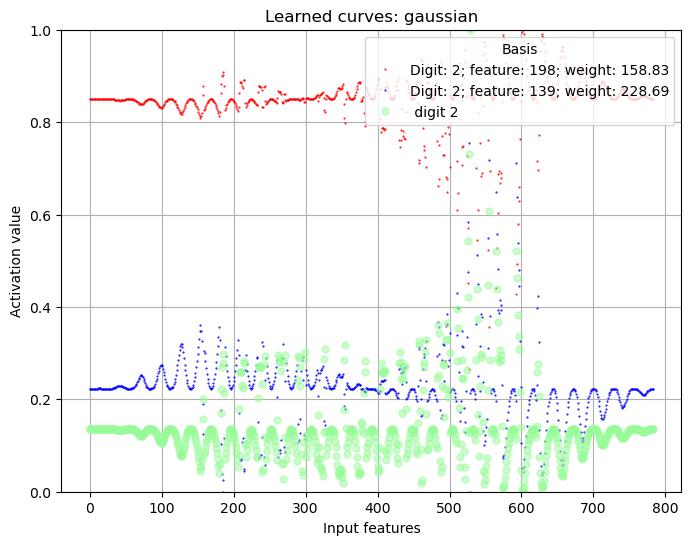

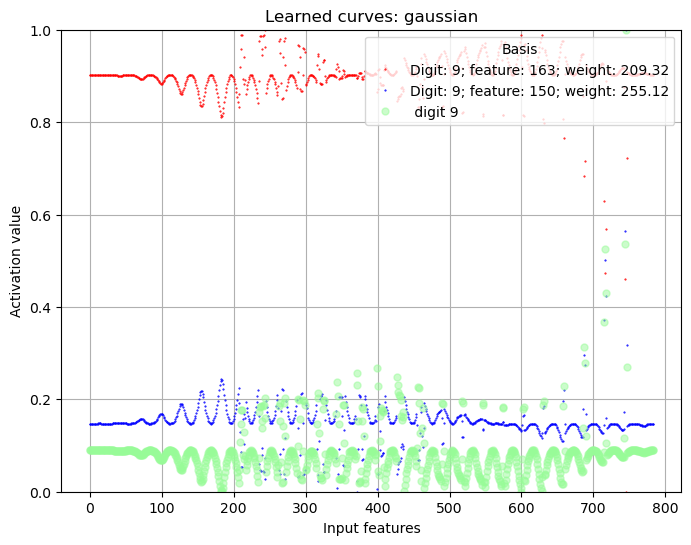

In [110]:

method="gaussian"    

model= BLS( 1E-9 , 10, 10, 10,sampling=method,task= "classification")

(train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
(test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
o_test = np.dot(InputOfOutputLayerTest,OutputWeight_A)
(curve,learned_curve_x,learned_curve,representative_examples)= model.retrieve(0, 134, test_x[0,:])

epsilon = 10  # Umbral para la diferencia de la primera característica

resultados = find_class_pair_features(OutputWeight_A, epsilon)

plot_difference_between_two(clases, caracteristicas,OutputWeight_A, model ,method, top=True)    

dim: Z: 100  and H:  100
Training classic accurate is 84.327 %
Testing classic accurate is 85.07000000000001 %


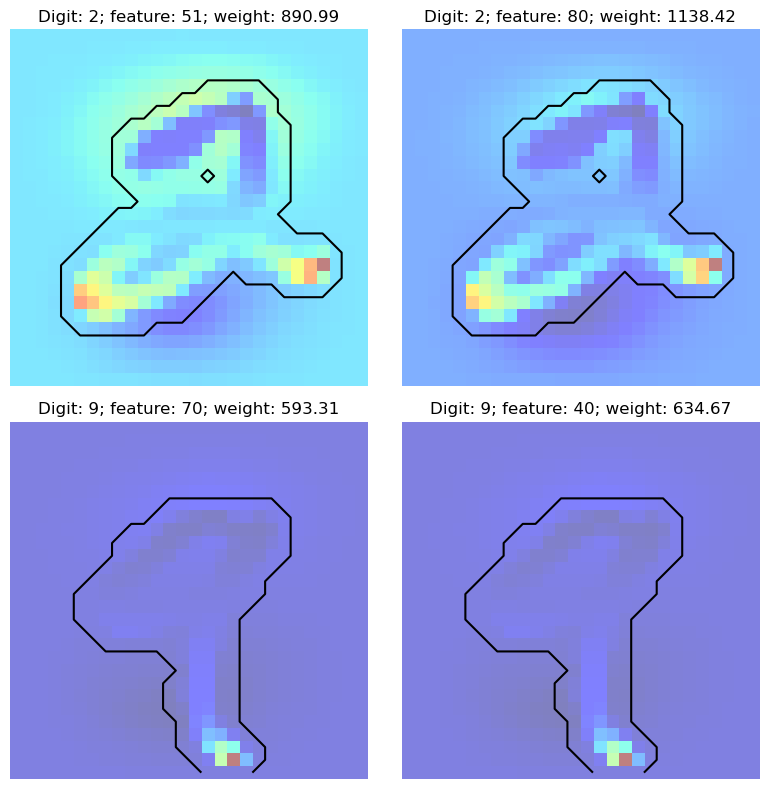

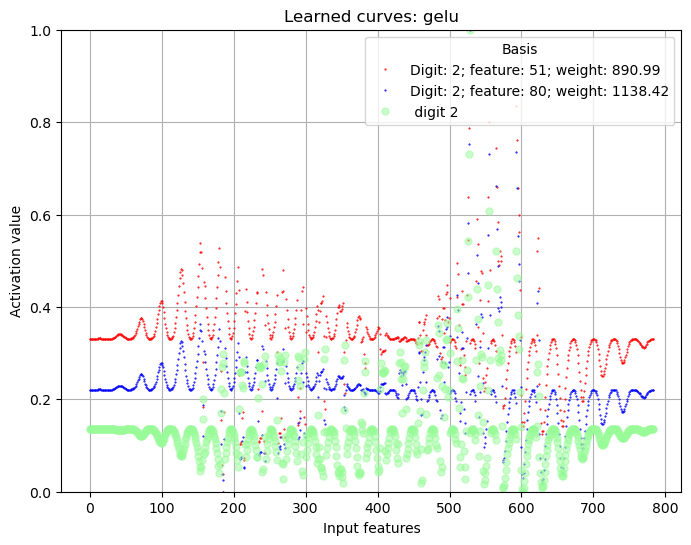

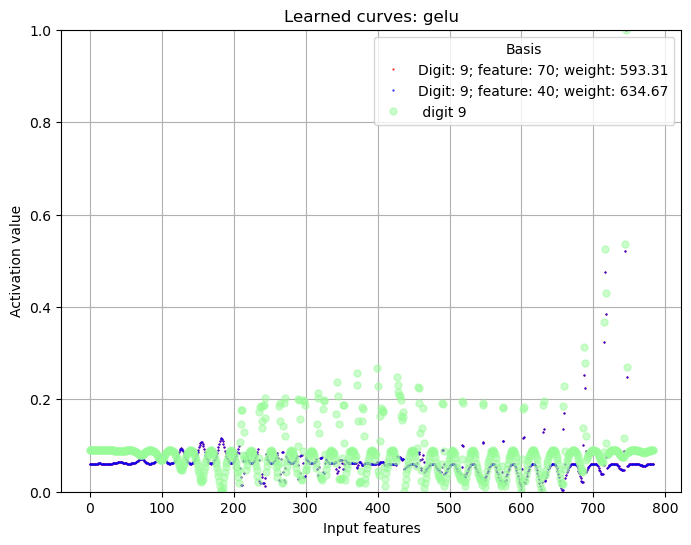

In [155]:

method="gelu"    

model= BLS( 1E-9 , 10, 10, 10,sampling=method,task= "classification")

(train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
(test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
o_test = np.dot(InputOfOutputLayerTest,OutputWeight_A)
(curve,learned_curve_x,learned_curve,representative_examples)= model.retrieve(0, 134, test_x[0,:])

epsilon = 10  # Umbral para la diferencia de la primera característica

resultados = find_class_pair_features(OutputWeight_A, epsilon)

plot_difference_between_two(clases, caracteristicas,OutputWeight_A, model ,method, top=True) 

dim: Z: 100  and H:  100
Training classic accurate is 85.45 %
Testing classic accurate is 86.31 %


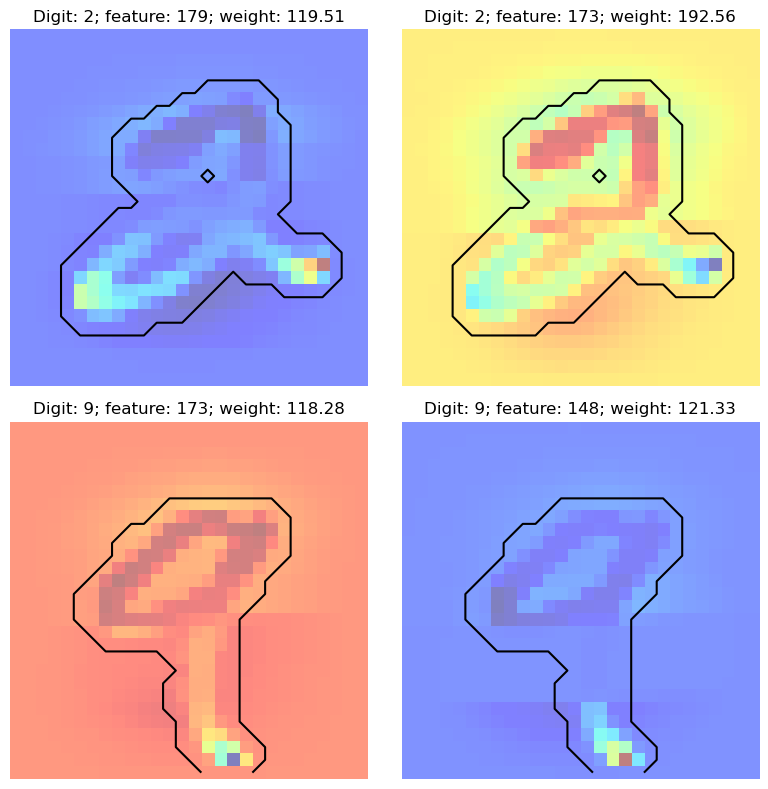

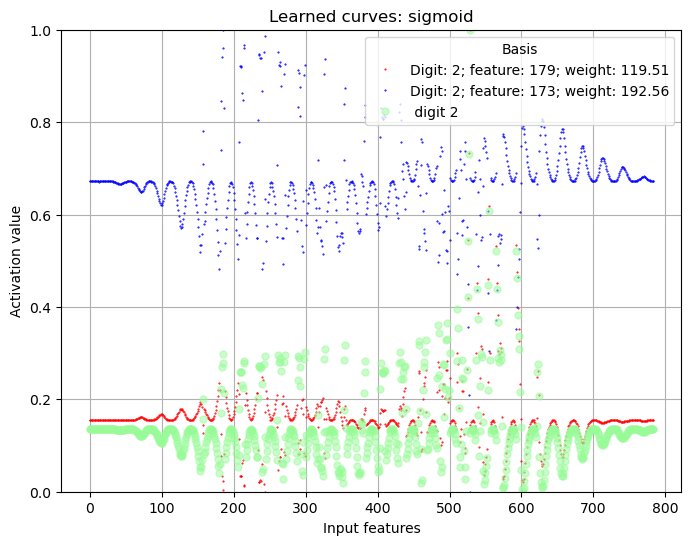

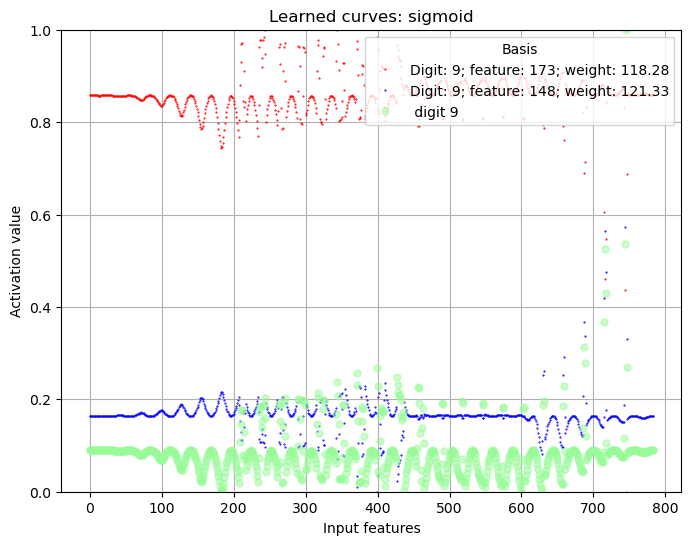

In [156]:

method="sigmoid"    

model= BLS( 1E-9 , 10, 10, 10,sampling=method,task= "classification")

(train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
(test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
o_test = np.dot(InputOfOutputLayerTest,OutputWeight_A)
(curve,learned_curve_x,learned_curve,representative_examples)= model.retrieve(0, 134, test_x[0,:])

epsilon = 10  # Umbral para la diferencia de la primera característica

resultados = find_class_pair_features(OutputWeight_A, epsilon)

plot_difference_between_two(clases, caracteristicas,OutputWeight_A, model ,method, top=True) 

dim: Z: 100  and H:  100
Training classic accurate is 81.113 %
Testing classic accurate is 81.85 %


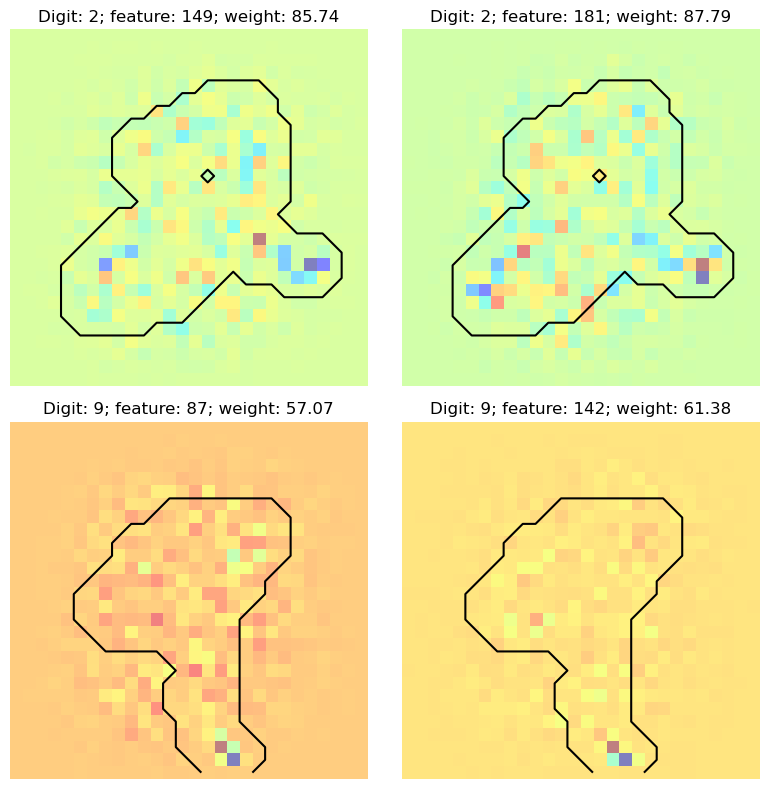

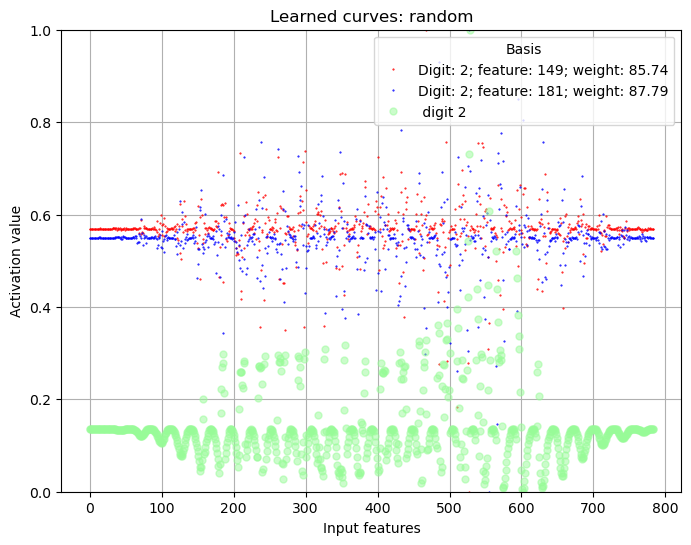

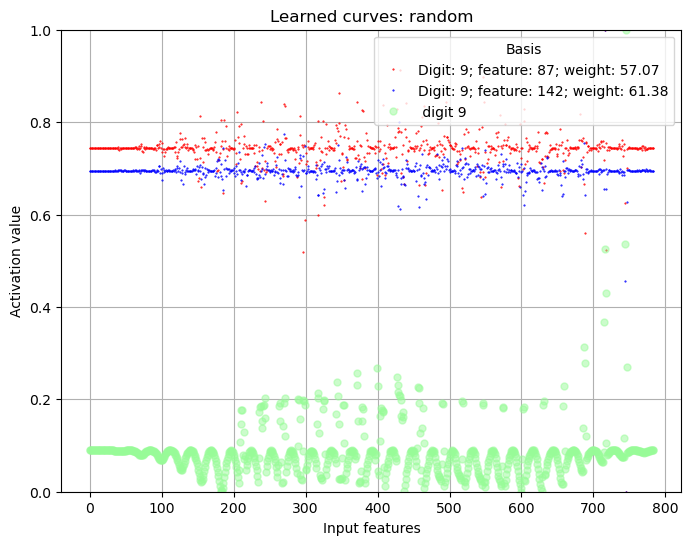

In [111]:

method="random"    

model= BLS( 1E-9 , 10, 10, 10,sampling=method,task= "classification")

(train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
(test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
o_test = np.dot(InputOfOutputLayerTest,OutputWeight_A)
(curve,learned_curve_x,learned_curve,representative_examples)= model.retrieve(0, 134, test_x[0,:])

epsilon = 10  # Umbral para la diferencia de la primera característica

resultados = find_class_pair_features(OutputWeight_A, epsilon)

plot_difference_between_two(clases, caracteristicas,OutputWeight_A, model,method, top=True)   

### image visualization

In [117]:
def save_plot_most_important(clases,OutputWeight_A, model):
    # Graficar
    output=[]
    for digit in clases:
        top_=np.argmax(np.array(OutputWeight_A[:,digit]).reshape(-1,))
        one_example=traindata_o[trainlabel[:, digit]==1,:][0,:]
        one_example_input=traindata_o[trainlabel[:, digit]==1,:][0,:]
            #mean= np.mean(traindata_o[trainlabel[:, digit]==1,:],axis=0)
        (curve,learned_curve_x,learned_curve,representative_examples)= model.retrieve(digit, top_, one_example_input)
        output.append((curve,learned_curve_x,learned_curve,representative_examples))
    return output

In [61]:
dataset = "mnist"
reg,d= 1E-8,10
dict_results={}
for method in ["gaussian","sigmoid","gelu"]:
    model= BLS( reg , d, 10, 100,sampling=[method,method],task= "classification")    
    (train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
    (test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
    dict_results["importance"]=save_plot_most_important(list(range(10)),OutputWeight_A, model)
    np.save(f'experiments/{method}/{dataset}/one_ejecution_importance_10_100_{reg}_{d}.npy', dict_results)

dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000
dim: Z: 100  and H:  1000


In [118]:
dataset = "mnist"
reg, d = 1E-8, 10
probabilidades=[]
dict_results = np.load(f'experiments/gaussian/{dataset}/one_ejecution_importance_10_100_{reg}_{d}.npy', allow_pickle=True).item()
probabilidades.append(dict_results["importance"])
dict_results = np.load(f'experiments/sigmoid/{dataset}/one_ejecution_importance_10_100_{reg}_{d}.npy', allow_pickle=True).item()
probabilidades.append(dict_results["importance"])
dict_results = np.load(f'experiments/gelu/{dataset}/one_ejecution_importance_10_100_{reg}_{d}.npy', allow_pickle=True).item()
probabilidades.append(dict_results["importance"])
dict_results = np.load(f'experiments/random/{dataset}/one_ejecution_importance_10_100_{reg}_{d}.npy', allow_pickle=True).item()
probabilidades.append(dict_results["importance"])

In [83]:
reg,d= 1E-6,10
probabilidades=[]
model= BLS( reg , d, 10, 10,sampling="gaussian",task= "classification")    
(train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
(test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
probabilidades.append(save_plot_most_important(list(range(10)),OutputWeight_A, model))
model= BLS( reg , d, 10, 10,sampling="sigmoid",task= "classification")    
(train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
(test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
probabilidades.append(save_plot_most_important(list(range(10)),OutputWeight_A, model))
model= BLS( reg , d, 10, 10,sampling="gelu",task= "classification")    
(train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
(test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
probabilidades.append(save_plot_most_important(list(range(10)),OutputWeight_A, model))
model= BLS( reg , d, 10, 10,sampling="random",task= "classification")    
(train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
(test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
probabilidades.append(save_plot_most_important(list(range(10)),OutputWeight_A, model))

dim: Z: 100  and H:  100
Training classic accurate is {'Accuracy': 0.85635, 'F1 Score': 0.85464}
Testing classic accurate is {'Accuracy': 0.8628, 'F1 Score': 0.86125}
dim: Z: 100  and H:  100
Training classic accurate is {'Accuracy': 0.85427, 'F1 Score': 0.85252}
Testing classic accurate is {'Accuracy': 0.8612, 'F1 Score': 0.85952}
dim: Z: 100  and H:  100
Training classic accurate is {'Accuracy': 0.85095, 'F1 Score': 0.84904}
Testing classic accurate is {'Accuracy': 0.8579, 'F1 Score': 0.85615}
dim: Z: 100  and H:  100
Training classic accurate is {'Accuracy': 0.85187, 'F1 Score': 0.85035}
Testing classic accurate is {'Accuracy': 0.8594, 'F1 Score': 0.85795}


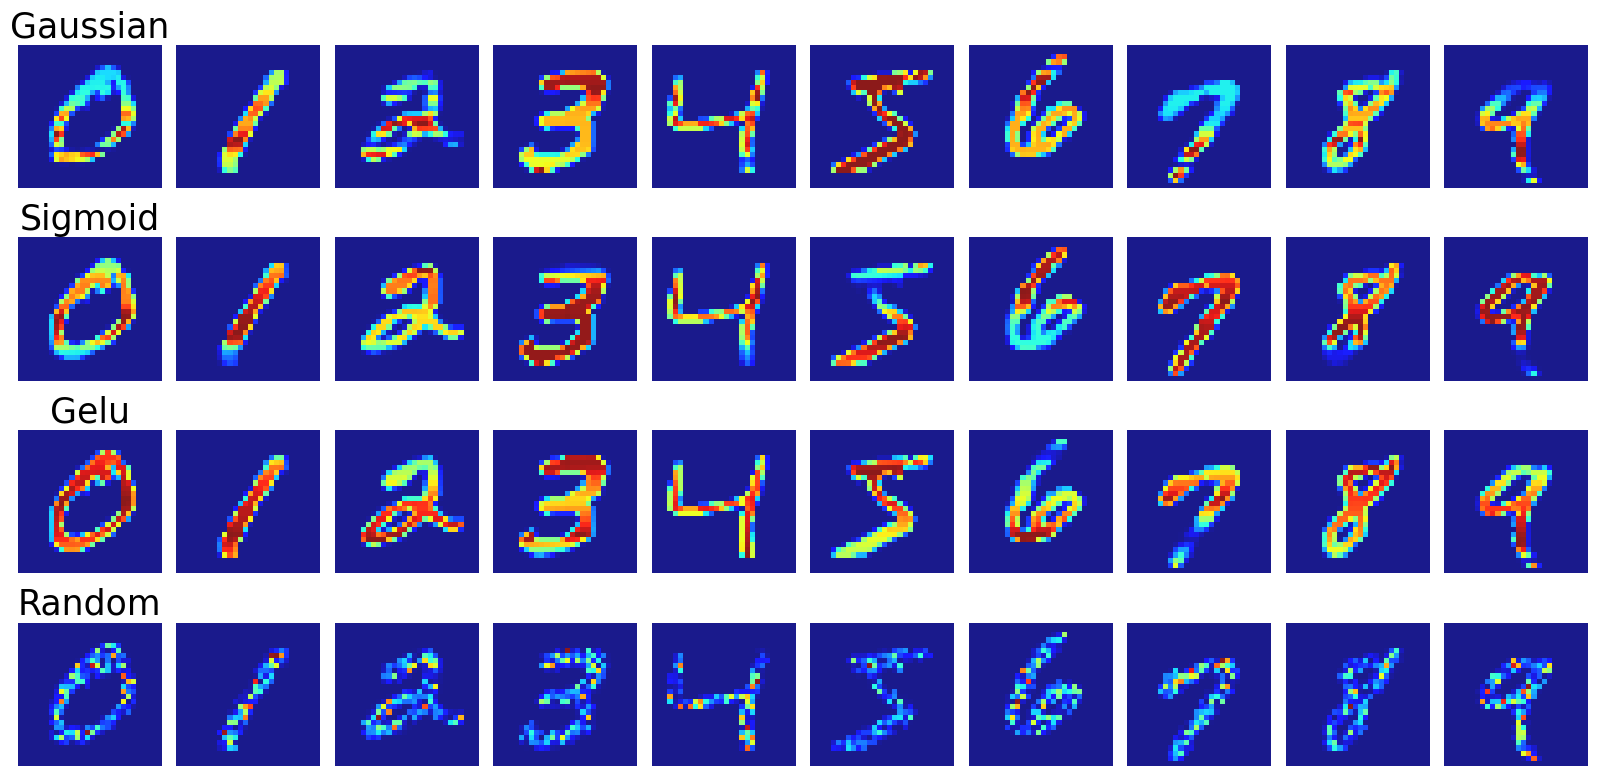

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries



fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(16, 8))


for digit in range(10):
    one_example = traindata_o[trainlabel[:, digit] == 1, :][0, :]
    one_example_input = traindata_o[trainlabel[:, digit] == 1, :][0, :]
    contour_original = find_boundaries(one_example.reshape(28, 28), mode='thick')
    l_min=[]
    l_max=[]
    for c, method in enumerate(["gaussian", "sigmoid", "gelu", "random"]): 

        probabilidades_= np.abs(probabilidades[c][digit][1])
        #probabilidades_= probabilidades[c][digit][1]

        # Normalize probabilidades between 0 and 1
        probabilidades_min = np.min(probabilidades_)
        probabilidades_max = np.max(probabilidades_)
        l_min.append(probabilidades_min)
        l_max.append(probabilidades_max)
        #probabilidades_norm = (probabilidades_ - probabilidades_min) / (probabilidades_max - probabilidades_min)
    probabilidades_min=np.min(l_min)
    probabilidades_max=np.max(l_max)
    for c, method in enumerate(["gaussian", "sigmoid", "gelu", "random"]): 
        probabilidades_= np.abs(probabilidades[c][digit][1])
        #probabilidades_= probabilidades[c][digit][1]
        probabilidades_norm = (probabilidades_ - probabilidades_min) / (probabilidades_max - probabilidades_min)
        #probabilidades_norm[probabilidades_norm < 0.01] = 0
        # Plot the normalized matrix
        axes[c,digit].imshow(probabilidades_norm.reshape((28, 28)), cmap='jet', alpha=0.9, interpolation='none')
        #axes[digit, c].contour(contour_original, colors='black')
                # Set titles in the first row
        if digit == 0:
            axes[c,digit].set_title(method.capitalize(), fontsize=25)

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.savefig('mnist_interpretability.png', dpi=400)
plt.show()


### norm plot

In [6]:
def divisores(numero):
  """
  Esta función calcula los divisores de un número entero.

  Args:
    numero: Un número entero positivo.

  Returns:
    Una lista con todos los divisores del número.
  """

  divisores_lista = []
  for i in range(1, numero + 1):
    if numero % i == 0:
      divisores_lista.append(i)
  return divisores_lista

# Ejemplo de uso:
numero = 24
resultado = divisores(numero)
print(f"Los divisores de {numero} son: {resultado}")

Los divisores de 24 son: [1, 2, 3, 4, 6, 8, 12, 24]


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Función que representa f(i) con las nuevas definiciones de sigma y mu
def f(i, N, a, b): #gaussian curve
    mu = N / b
    sigma = N * a
    return ((1 /(sigma*np.sqrt(2 * np.pi ))) * np.exp(-((i - mu) ** 2) / (2 * sigma**2)) )

# Aproximación de la norma
def approx_norm(N, a, b):
    norm_squared = 0
    for i in range(N):
        f_i = f(i, N, a, b)**2
        norm_squared += f_i
    return np.sqrt(norm_squared)

def approx_norm_sigmoid(N, a, b):
    norm_squared = 0
    for i in range(N):
        f_i = 1 / (1 + np.exp(- a*(i - int(N/b) ) ))
        norm_squared += f_i**2
    return np.sqrt(norm_squared)

def approx_norm_gelu(N, a, b):
    norm_squared = 0
    for i in range(N):
        x_scaled = a * (i - int(N/b))
        f_i= gelu(x_scaled)
        norm_squared += f_i**2
    return np.sqrt(norm_squared)

# Calculate norms for different combinations of a and b
def calculate_norms(N, a_range, b_range):
    norms = []
    for i, a in enumerate(a_range):
        for j, b in enumerate(b_range):
            norms.append(approx_norm(N, a, b))
    return norms

def calculate_norms_sigmoid(N, a_range, b_range):
    norms = []
    for i, a in enumerate(a_range):
        for j, b in enumerate(b_range):
            norms.append(approx_norm_sigmoid(N, a, b))
    return norms

def calculate_norms_gelu(N, a_range, b_range):
    norms = []
    for i, a in enumerate(a_range):
        for j, b in enumerate(b_range):
            norms.append(approx_norm_gelu(N, a, b))
    return norms

N_values = np.arange(5, 101)
#central line
norm_values = np.array([approx_norm(N, 0.3, 2) for N in N_values])
norm_values_sigmoid = np.array([approx_norm_sigmoid(N, 0.3, 2) for N in N_values])
norm_values_gelu = np.array([approx_norm_sigmoid(N, 0.05, 2) for N in N_values])

# Define ranges for a and b
a_range = np.linspace(0.1, 0.9, 10)
a_range_gelu = np.linspace(0.01, 0.1, 10)

# Calculate norms for each N
all_norms = np.array([calculate_norms(N, a_range, divisores(N) ) for N in N_values ])

all_norms_sigmoid = np.array([calculate_norms_sigmoid(N, a_range, divisores(N) ) for N in N_values ])

all_norms_gelu = np.array([calculate_norms_gelu(N, a_range_gelu, divisores(N) ) for N in N_values ])

# Find minimum and maximum norms for each N
min_norms = [np.min(i) for i in all_norms]
max_norms = [np.max(i) for i in all_norms]

min_norms_sigmoid = [np.min(i) for i in all_norms]
max_norms_sigmoid = [np.max(i) for i in all_norms_sigmoid]

min_norms_gelu = [np.min(i) for i in all_norms_gelu]
max_norms_gelu = [np.max(i) for i in all_norms_gelu]


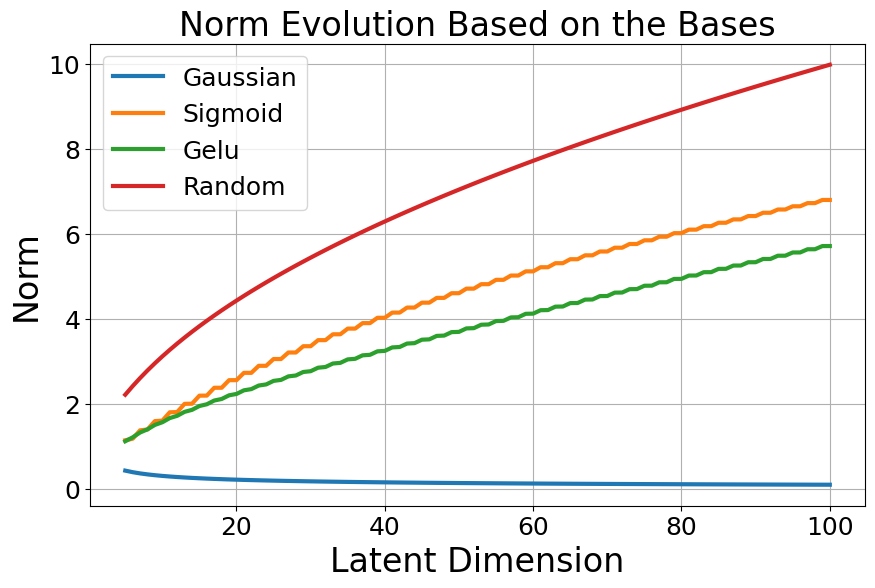

In [9]:


fig, ax1 = plt.subplots(figsize=(10, 6))


# Plot the first curve

ax1.plot(N_values, norm_values, label='Gaussian', color='C0', linewidth=3)
#ax1.fill_between(N_values, min_norms, max_norms, alpha=0.2, label='Variation respect to ' +'$\mu$'+' and ' +'$\sigma$')

ax1.plot(N_values, norm_values_sigmoid, label='Sigmoid', color='C1', linewidth=3)
#ax1.fill_between(N_values, min_norms_sigmoid, max_norms_sigmoid, alpha=0.2, label='Variation respect to ' +'$\mu$'+' and ' +'$\sigma$')

ax1.plot(N_values, norm_values_gelu, label='Gelu', color='C2', linewidth=3)
#ax1.fill_between(N_values, min_norms_gelu, max_norms_sigmoid,alpha=0.2, label='Variation respect to ' +'$\mu$'+' and ' +'$\sigma$')

ax1.set_xlabel('Latent Dimension',fontsize=24)
ax1.set_ylabel('Norm',fontsize=24)
#ax1.set_ylabel('Gaussian basis '+'$\|G\|_2$'+' scale')
ax1.tick_params(axis='y', labelcolor='black')

norm_random= np.sqrt(N_values)*(1-1/(4*N_values) + 1/(N_values)**2)
ax1.plot(N_values,norm_random , label='Random', color='C3', linewidth=3)

ax1.legend(loc="upper left", fontsize=18)
# Create a second axis for the second curve
#ax2 = ax1.twinx()

# Plot the second curve
#ax2.plot(N_values,norm_random , label='$\|R\|_2$', color='black', linestyle='--')
#ax2.set_ylabel('Random weights '+ '$\|R\|_2$' +' scale')
#ax2.tick_params(axis='y', labelcolor='black')
#ax2.legend(loc="upper right")
# Set title and legend
plt.title('Norm Evolution Based on the Bases',fontsize=24)
plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)
#plt.title('Norm evolution for classic random weights and proposal Gaussian basis')
plt.grid(True)
plt.savefig('norm_methods.png', dpi=400)
plt.show()



### compute metric of robustness

In [261]:
dataset= "housing_b"
reg, d,n,m= 1E-5,6,10,10
task_="regression"
epsilon=100

In [393]:
dataset= "housing"
reg, d,n,m= 1E-3,6,10,10
task_="regression"
epsilon=100

In [180]:
dataset= "izmir"
reg, d,n,m= 1E-4,4,3,22
task_="regression"
epsilon=1

In [108]:
dataset= "isolet"
task_="clasification"
reg, d,n,m= 1E-2,16,14,25 #as classic paper
epsilon=1

In [185]:
dataset= "abalone"
reg, d= 1E-4,6
n,m= 5,7
epsilon=1
task_="regression"

In [95]:
dataset="mnist"
reg, d= 1E-6,10
n,m= 10,10
epsilon=1
task_="classification"

In [96]:
times=10
grid= np.linspace(0.01, 0.6, 10) #0.3

In [12]:
dict_results={}
global_testing_data_noise=[]
global_norm_l2_den_noise=[]
for t in range(times):
    testing_data_noise=[]
    norm_l2_den_noise=[]
    for std in grid: #0.001 casi igual performance
        if dataset=="mnist":
            ruido_blanco = np.random.normal(0, std, testdata_o.shape)
            muestras_con_ruido = testdata_o + ruido_blanco
            test_ruido_x=np.asarray(muestras_con_ruido)
        else: #if dataset=="housing" or dataset=="abalone" :
            ruido_blanco = np.random.normal(0, std, test_x.shape)
            muestras_con_ruido = test_x + ruido_blanco
            test_ruido_x=np.asarray(muestras_con_ruido)
            
        norma_L2_den = np.linalg.norm(np.abs(test_x - test_ruido_x))
        norm_l2_den_noise.append(norma_L2_den)
        testing_data_noise.append(test_ruido_x)
    global_testing_data_noise.append(testing_data_noise)
    global_norm_l2_den_noise.append(norm_l2_den_noise)
    
dict_results["testing_data_noise"]= global_testing_data_noise
dict_results["norm_l2_den_noise"]= global_norm_l2_den_noise


for method in ["gaussian", "sigmoid","gelu","random"]: 
    print(method)
    model= BLS( reg , d, n, m,sampling=[method,method],task= task_, epsilon=epsilon)
    (train_acc,train_time,OutputWeight_A)=model.train(train_x,train_y)
    (test_acc,test_time, InputOfOutputLayerTest)=model.inference(test_x,test_y)
    dict_results["train"]=(train_acc,train_time,OutputWeight_A)
    dict_results["test"]=(test_acc,test_time, InputOfOutputLayerTest)
    o_test_R = np.dot(InputOfOutputLayerTest,OutputWeight_A)
    
    global_results_noise_aux=[]
    global_norms_L2_num=[]
    for t in range(times):
        results_noise_aux=[]
        norms_L2_num=[]
        for test_ruido_x in global_testing_data_noise[t]:
            (test_acc,test_time, InputOfOutputLayerTest_R_epsilon)=model.inference(test_ruido_x,test_y)
            o_test_R_epsilon = np.dot(InputOfOutputLayerTest_R_epsilon,OutputWeight_A)
            norma_L2_num = np.linalg.norm(np.abs(o_test_R - o_test_R_epsilon))
            norms_L2_num.append(norma_L2_num)
            results_noise_aux.append((test_acc,test_time))
        global_norms_L2_num.append(norms_L2_num)
        global_results_noise_aux.append(results_noise_aux)
        
    dict_results["norma_L2_num"]=global_norms_L2_num
    dict_results["results_noise_aux"]=global_results_noise_aux
    #np.save(f'experiments/{method}/{dataset}/one_ejecution_{n}_{m}_{reg}_{d}.npy', dict_results)
    np.save(f'experiments/{method}/{dataset}/extended_{n}_{m}_{reg}_{d}.npy', dict_results)

gaussian
dim: Z: 100  and H:  100
sigmoid
dim: Z: 100  and H:  100
gelu
dim: Z: 100  and H:  100
random
dim: Z: 100  and H:  100


In [97]:
dict_results = np.load(f'experiments/gaussian/{dataset}/one_ejecution_{n}_{m}_{reg}_{d}.npy', allow_pickle=True).item()
dict_results_s = np.load(f'experiments/sigmoid/{dataset}/one_ejecution_{n}_{m}_{reg}_{d}.npy', allow_pickle=True).item()
dict_results_g = np.load(f'experiments/gelu/{dataset}/one_ejecution_{n}_{m}_{reg}_{d}.npy', allow_pickle=True).item()
dict_results_r = np.load(f'experiments/random/{dataset}/one_ejecution_{n}_{m}_{reg}_{d}.npy', allow_pickle=True).item()

In [14]:
dict_results = np.load(f'experiments/gaussian/{dataset}/extended_{n}_{m}_{reg}_{d}.npy', allow_pickle=True).item()
#dict_results_s = np.load(f'experiments/sigmoid/{dataset}/extended_{n}_{m}_{reg}_{d}.npy', allow_pickle=True).item()
#dict_results_g = np.load(f'experiments/gelu/{dataset}/extended_{n}_{m}_{reg}_{d}.npy', allow_pickle=True).item()
dict_results_r = np.load(f'experiments/random/{dataset}/extended_{n}_{m}_{reg}_{d}.npy', allow_pickle=True).item()

In [98]:

experiment=[]
for i,std in enumerate(grid): #0.001 casi igual performance
        print(std)
        results, results_s,results_g,results_r=[],[],[],[]
        for t in range(times):
            norma_L2_den= dict_results["norm_l2_den_noise"][t][i] #dict_results["norm_l2_den_noise"][t][i]
            results.append(dict_results["norma_L2_num"][t][i]/norma_L2_den)
            results_s.append(dict_results_s["norma_L2_num"][t][i]/norma_L2_den)
            results_g.append(dict_results_g["norma_L2_num"][t][i]/norma_L2_den)
            results_r.append(dict_results_r["norma_L2_num"][t][i]/norma_L2_den)
        experiment.append((std,results,results_s,results_g,results_r))
        
if dataset=="mnist" or dataset=="isolet":
    metric_name= "F1 Score"
if dataset=="abalone" or dataset=="izmir" or dataset=="housing" or dataset=="housing_b":
    metric_name= "RMSE"
experiment_f1=[]
for i,std in enumerate(grid): #0.001 casi igual performance
        print(std)
        results, results_s,results_g,results_r=[],[],[],[]
        for t in range(times):
            norma_L2_den= dict_results["norm_l2_den_noise"][t][i] 
            results.append(dict_results["results_noise_aux"][t][i][0][0][metric_name])
            results_s.append(dict_results_s["results_noise_aux"][t][i][0][0][metric_name])
            results_g.append(dict_results_g["results_noise_aux"][t][i][0][0][metric_name])
            results_r.append(dict_results_r["results_noise_aux"][t][i][0][0][metric_name])

        experiment_f1.append((std,results,results_s,results_g,results_r))

0.01
0.07555555555555554
0.1411111111111111
0.20666666666666667
0.2722222222222222
0.33777777777777773
0.4033333333333333
0.46888888888888886
0.5344444444444444
0.6
0.01
0.07555555555555554
0.1411111111111111
0.20666666666666667
0.2722222222222222
0.33777777777777773
0.4033333333333333
0.46888888888888886
0.5344444444444444
0.6


In [198]:
print("Times: G-S-Ge-R: ")

print()dict_results["train"][1][0]
print()dict_results["train"][1][0]
print()dict_results["train"][1][0]
print(dict_results["train"][1][0]

SyntaxError: invalid syntax (1027486960.py, line 3)

#### izmir

In [184]:
for i,std in enumerate(grid): #0.001 casi igual performance
        print("---"*10)
        print(std)
        print("---"*10)
        for c, method in enumerate(["Gaussian", "Sigmoid", "Gelu", "Random"]):
                print(method)
                values=experiment_f1[i][c+1]
                print(metric_name,str(np.round(np.mean(values),4))+"+-"+str(np.round(np.std(values),4)))
                #values=experiment[i][c+1]
                #print("robustness: ",str(np.round(np.mean(values),4))+"+-"+str(np.round(np.std(values),4)))


------------------------------
0.01
------------------------------
Gaussian
RMSE 0.0201+-0.0001
Sigmoid
RMSE 0.0196+-0.0001
Gelu
RMSE 0.0216+-0.0001
Random
RMSE 0.0187+-0.0001
------------------------------
0.042222222222222223
------------------------------
Gaussian
RMSE 0.0214+-0.0004
Sigmoid
RMSE 0.0209+-0.0003
Gelu
RMSE 0.0228+-0.0003
Random
RMSE 0.0201+-0.0004
------------------------------
0.07444444444444444
------------------------------
Gaussian
RMSE 0.0236+-0.0007
Sigmoid
RMSE 0.0233+-0.0005
Gelu
RMSE 0.0249+-0.0006
Random
RMSE 0.0227+-0.0005
------------------------------
0.10666666666666666
------------------------------
Gaussian
RMSE 0.0273+-0.0009
Sigmoid
RMSE 0.027+-0.0008
Gelu
RMSE 0.0284+-0.0009
Random
RMSE 0.0266+-0.0008
------------------------------
0.1388888888888889
------------------------------
Gaussian
RMSE 0.0304+-0.0009
Sigmoid
RMSE 0.0302+-0.0008
Gelu
RMSE 0.0314+-0.0008
Random
RMSE 0.03+-0.0007
------------------------------
0.1711111111111111
-------------

#### abalone

In [188]:
for i,std in enumerate(grid): #0.001 casi igual performance
        print("---"*10)
        print(std)
        print("---"*10)
        for c, method in enumerate(["Gaussian", "Sigmoid", "Gelu", "Random"]):
                print(method)
                values=experiment_f1[i][c+1]
                print(metric_name,str(np.round(np.mean(values),4))+"+-"+str(np.round(np.std(values),4)))
                #values=experiment[i][c+1]
                #print("robustness: ",str(np.round(np.mean(values),4))+"+-"+str(np.round(np.std(values),4)))


------------------------------
0.01
------------------------------
Gaussian
RMSE 0.0809+-0.0008
Sigmoid
RMSE 0.1075+-0.0015
Gelu
RMSE 0.1152+-0.0022
Random
RMSE 0.0919+-0.001
------------------------------
0.042222222222222223
------------------------------
Gaussian
RMSE 0.1759+-0.0023
Sigmoid
RMSE 0.3453+-0.0043
Gelu
RMSE 0.3817+-0.0054
Random
RMSE 0.2509+-0.0032
------------------------------
0.07444444444444444
------------------------------
Gaussian
RMSE 0.293+-0.0056
Sigmoid
RMSE 0.5977+-0.0103
Gelu
RMSE 0.6635+-0.0133
Random
RMSE 0.4247+-0.0077
------------------------------
0.10666666666666666
------------------------------
Gaussian
RMSE 0.4145+-0.0048
Sigmoid
RMSE 0.8576+-0.0113
Gelu
RMSE 0.9565+-0.0139
Random
RMSE 0.5992+-0.0087
------------------------------
0.1388888888888889
------------------------------
Gaussian
RMSE 0.54+-0.0097
Sigmoid
RMSE 1.1103+-0.0203
Gelu
RMSE 1.2331+-0.0185
Random
RMSE 0.7642+-0.0108
------------------------------
0.1711111111111111
--------------

#### housing

In [266]:
for i,std in enumerate(grid): #0.001 casi igual performance
        print("---"*10)
        print(std)
        print("---"*10)
        for c, method in enumerate(["Gaussian", "Sigmoid", "Gelu", "Random"]):
                print(method)
                values=experiment_f1[i][c+1]
                print(metric_name,str(np.round(np.mean(values),4))+"+-"+str(np.round(np.std(values),4)))
                #values=experiment[i][c+1]
                #print("robustness: ",str(np.round(np.mean(values),4))+"+-"+str(np.round(np.std(values),4)))


------------------------------
0.01
------------------------------
Gaussian
RMSE 0.1085+-0.001
Sigmoid
RMSE 0.1009+-0.0011
Gelu
RMSE 0.1076+-0.0008
Random
RMSE 0.118+-0.001
------------------------------
0.042222222222222223
------------------------------
Gaussian
RMSE 0.1187+-0.0046
Sigmoid
RMSE 0.1099+-0.0033
Gelu
RMSE 0.1154+-0.0037
Random
RMSE 0.1278+-0.0055
------------------------------
0.07444444444444444
------------------------------
Gaussian
RMSE 0.1398+-0.007
Sigmoid
RMSE 0.1252+-0.0046
Gelu
RMSE 0.1264+-0.0048
Random
RMSE 0.1529+-0.0075
------------------------------
0.10666666666666666
------------------------------
Gaussian
RMSE 0.1782+-0.0103
Sigmoid
RMSE 0.153+-0.0082
Gelu
RMSE 0.1482+-0.0064
Random
RMSE 0.1916+-0.0107
------------------------------
0.1388888888888889
------------------------------
Gaussian
RMSE 0.2132+-0.0097
Sigmoid
RMSE 0.1857+-0.0117
Gelu
RMSE 0.1703+-0.009
Random
RMSE 0.2306+-0.0171
------------------------------
0.1711111111111111
----------------

#### MNIST

In [16]:
for i,std in enumerate(grid): #0.001 casi igual performance
        print("---"*10)
        print(std)
        print("---"*10)
        for c, method in enumerate(["Gaussian", "Sigmoid", "Gelu", "Random"]):
                print(method)
                #values=experiment_f1[i][c+1]
                #print(metric_name,str(np.round(np.mean(values),4)*100)+"+-"+str(np.round(np.std(values),4)*100))
                values=experiment[i][c+1]
                print("robustness: ",str(np.round(np.mean(values),4))+"+-"+str(np.round(np.std(values),4)))


------------------------------
0.01
------------------------------
Gaussian
robustness:  0.1026+-0.0003
Sigmoid
robustness:  0.0936+-0.0003
Gelu
robustness:  0.0971+-0.0004
Random
robustness:  0.0935+-0.0002
------------------------------
0.07555555555555554
------------------------------
Gaussian
robustness:  0.1027+-0.0002
Sigmoid
robustness:  0.0936+-0.0002
Gelu
robustness:  0.0969+-0.0003
Random
robustness:  0.0947+-0.0002
------------------------------
0.1411111111111111
------------------------------
Gaussian
robustness:  0.1026+-0.0003
Sigmoid
robustness:  0.0935+-0.0002
Gelu
robustness:  0.0967+-0.0002
Random
robustness:  0.0994+-0.0002
------------------------------
0.20666666666666667
------------------------------
Gaussian
robustness:  0.1026+-0.0002
Sigmoid
robustness:  0.0936+-0.0004
Gelu
robustness:  0.0969+-0.0003
Random
robustness:  0.1084+-0.0003
------------------------------
0.2722222222222222
------------------------------
Gaussian
robustness:  0.1027+-0.0002
Sigmoi

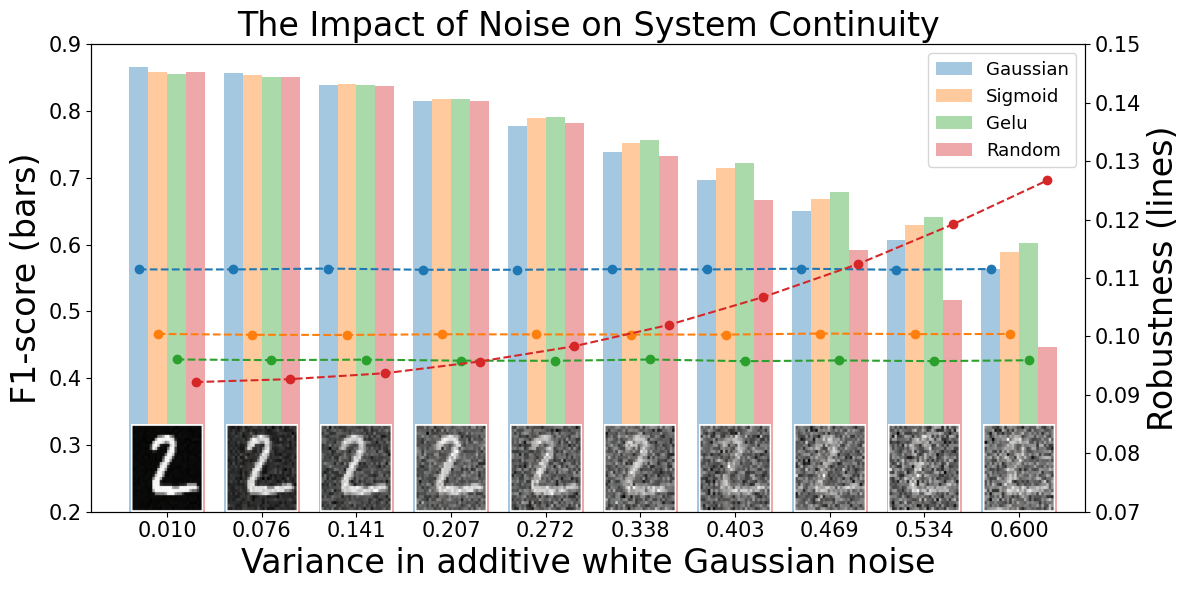

In [116]:
import matplotlib.image as mpimg

# Crear gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras para la robustez en ax1
bar_width = 0.2  # Ajustar el ancho de las barras
x = np.arange(len(grid))  # Posición de los niveles de ruido en el eje X

for c, method in enumerate(["Gaussian", "Sigmoid", "Gelu", "Random"]):
    ax1.bar(x + (c) * bar_width, [np.mean(experiment_f1[i][c+1]) for i in range(10)], 
            width=bar_width, label=f'{method}', alpha=0.4)


# Crear el segundo eje Y para las líneas
ax2 = ax1.twinx()

# Gráfico de líneas en ax2
for c, method in enumerate(["gaussian", "sigmoid", "gelu", "random"]):
    ax2.plot(x + (c) * bar_width , [np.mean(experiment[i][c+1]) for i in range(10)],  
             linestyle='--', marker='o', label=f'{method}', color=f'C{c}')
    #+ c * bar_width
    
# Añadir imágenes sobre el eje x
for i,std in enumerate(grid):
   image_path= f'mnist_noise_{std}.png'
   img = mpimg.imread(image_path)  # Cargar la imagen
   ax2.imshow(img, extent=(x[i] + bar_width * 3 / 2 - 0.38, x[i] + bar_width * (4 - 1) / 2 +0.38, 0.07, 0.085), aspect='auto',alpha=0.99)  # Ajusta el `extent` para la posición

# Etiquetas y leyenda
ax1.set_xlabel('Variance in additive white Gaussian noise',fontsize=24)
ax1.set_ylabel('F1-score (bars)', color='black',fontsize=24)
ax2.set_ylabel('Robustness (lines)', color='black',fontsize=24)

ax1.set_title("The Impact of Noise on System Continuity",fontsize=24)
ax1.set_xticks(x + bar_width * (4 - 1) / 2)

l_x=[]
for c,nl in enumerate(grid):
    l_x.append(f'{nl:.3f}')

ax1.set_xticklabels(l_x)

# Ajustar colores de los ticks del eje y
ax1.tick_params(axis='y', labelcolor='black',labelsize=15)
ax2.tick_params(axis='y', labelcolor='black',labelsize=15)

# Leyendas separadas
ax1.legend(loc='upper right', fontsize=13)

ax1.set_xlim([-0.5, 10])
ax2.set_xlim([-0.5, 10])
ax1.set_ylim([0.2, 0.9])
ax2.set_ylim([0.01,0.74])
ax2.set_ylim([0.07,0.15])
ax1.tick_params(axis='x', labelsize=15)
plt.tight_layout()
plt.savefig('mnist_robustness.png', dpi=400)
plt.show()

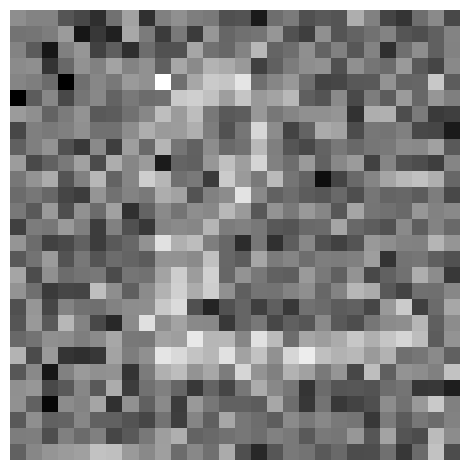

In [18]:
import numpy as np
import matplotlib.pyplot as plt
for i in grid:
    # Generamos una lista de 784 valores aleatorios entre 0 y 1
    random_values= testdata_o[1,:] + np.random.normal(0, i,(784,))
    matrix = random_values.reshape((28, 28))

    # Creamos el heatmap en escala de grises
    plt.imshow(matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'mnist_noise_{i}.png',bbox_inches='tight')

#### isolet

In [117]:
for i,std in enumerate(grid): #0.001 casi igual performance
        print("---"*10)
        print(std)
        print("---"*10)
        for c, method in enumerate(["Gaussian", "Sigmoid", "Gelu", "Random"]):
                print(method)
                values=experiment_f1[i][c+1]
                print(metric_name,str(np.round(np.mean(values),4)*100)+"+-"+str(np.round(np.std(values),4)*100))
                #values=experiment[i][c+1]
                #print("robustness: ",str(np.round(np.mean(values),4))+"+-"+str(np.round(np.std(values),4)))


------------------------------
0.01
------------------------------
Gaussian
F1 Score 94.69+-0.19
Sigmoid
F1 Score 94.28999999999999+-0.11
Gelu
F1 Score 93.2+-0.27999999999999997
Random
F1 Score 93.04+-0.16999999999999998
------------------------------
0.042222222222222223
------------------------------
Gaussian
F1 Score 94.45+-0.44999999999999996
Sigmoid
F1 Score 94.39+-0.43
Gelu
F1 Score 93.27+-0.62
Random
F1 Score 93.01+-0.6
------------------------------
0.07444444444444444
------------------------------
Gaussian
F1 Score 93.7+-0.33
Sigmoid
F1 Score 94.07+-0.5
Gelu
F1 Score 93.08999999999999+-0.33999999999999997
Random
F1 Score 92.0+-0.8099999999999999
------------------------------
0.10666666666666666
------------------------------
Gaussian
F1 Score 93.39+-0.62
Sigmoid
F1 Score 93.19+-0.86
Gelu
F1 Score 92.55+-0.8500000000000001
Random
F1 Score 90.64999999999999+-0.8999999999999999
------------------------------
0.1388888888888889
------------------------------
Gaussian
F1 Score 92

### pior knowledge

21: testing after 1:  0.9767  +-  0.0

14:  0.9774  +-  0.0

7: testing after 1:  0.97589  +-  0.0

In [189]:
times=10 #as classic paper
dataset= "mnist"
reg, d= 1E-8,10 #as classic paper
dict_results={}

for d in [10]: #14
    method= "gaussian"
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 100, 1000,sampling=[method,method],task= "classification") #int((11000-100*d)/d)
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    np.save(f'experiments/{method}/{dataset}/prior_knowledge_100_1000_{reg}_{d}.npy', dict_results) 
 

gaussian
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
dim: Z: 1000  and H:  10000
Tranining after 10:  0.9942540000000001  +-  0.00017327434893831358
testing after 10:  0.9775159999999999  +-  0.0008915290236442138


In [191]:
    print("testing after "+str(times)+": ", np.round(np.mean([i[0]["F1 Score"] for i in testing])*100,2), " +- ", np.round(np.std([i[0]["F1 Score"] for i in testing])*100,2) )

testing after 10:  97.75  +-  0.09


### Individual performance

#### mnist

In [114]:
times=1 #as classic paper
dataset= "mnist"
reg, d= 1E-8,10 #as classic paper
dict_results={}

for method in ["gaussian", "sigmoid","gelu","random"]: 
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 100, 100,sampling=[method, method],task= "classification", individual_experiment=True)
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    np.save(f'experiments/{method}/{dataset}/individual_10_100_{reg}_{d}.npy', dict_results)


gaussian
0 {'Accuracy': 0.43598, 'F1 Score': 0.38437}
1 {'Accuracy': 0.43483, 'F1 Score': 0.38786}
2 {'Accuracy': 0.3858, 'F1 Score': 0.34039}
3 {'Accuracy': 0.45283, 'F1 Score': 0.42936}
4 {'Accuracy': 0.40855, 'F1 Score': 0.36771}
5 {'Accuracy': 0.42493, 'F1 Score': 0.39287}
6 {'Accuracy': 0.4456, 'F1 Score': 0.41629}
7 {'Accuracy': 0.38383, 'F1 Score': 0.34062}
8 {'Accuracy': 0.38243, 'F1 Score': 0.35021}
9 {'Accuracy': 0.38288, 'F1 Score': 0.34056}
10 {'Accuracy': 0.34987, 'F1 Score': 0.30583}
11 {'Accuracy': 0.42007, 'F1 Score': 0.38446}
12 {'Accuracy': 0.40187, 'F1 Score': 0.35523}
13 {'Accuracy': 0.48218, 'F1 Score': 0.44932}
14 {'Accuracy': 0.41135, 'F1 Score': 0.36001}
15 {'Accuracy': 0.37237, 'F1 Score': 0.33093}
16 {'Accuracy': 0.39985, 'F1 Score': 0.36871}
17 {'Accuracy': 0.41435, 'F1 Score': 0.37258}
18 {'Accuracy': 0.41607, 'F1 Score': 0.37295}
19 {'Accuracy': 0.4008, 'F1 Score': 0.35849}
20 {'Accuracy': 0.44805, 'F1 Score': 0.40312}
21 {'Accuracy': 0.38373, 'F1 Score': 0

KeyboardInterrupt: 

gaussian
0.11758000000000002
0.14413000000000004
sigmoid
0.14490000000000003
0.12530999999999998
gelu
0.11129
0.14690999999999999
random
0.15654
0.15992


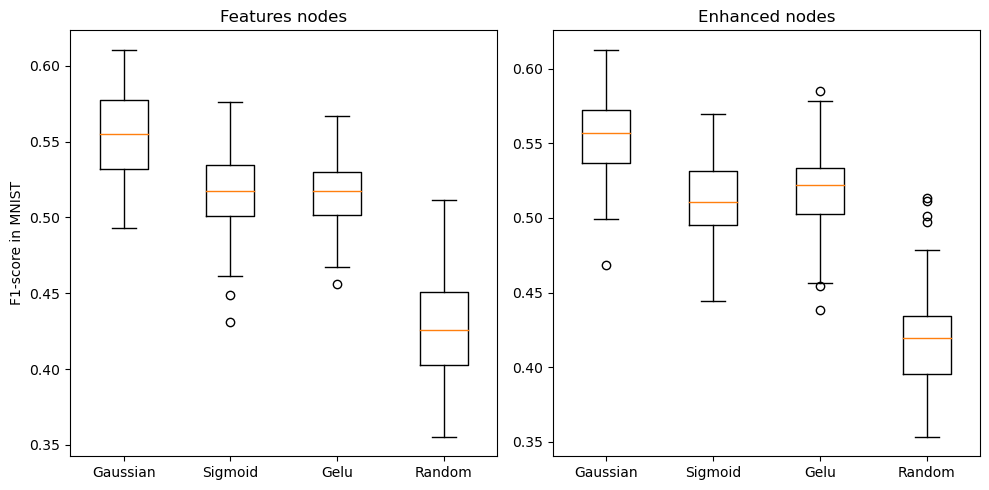

In [28]:
n,m= 100,100

# Create a figure with three subplots in one row
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

result,result_h=[],[]
for method in ["gaussian", "sigmoid","gelu","random"]:
    print(method)
    dict_results= np.load(f'experiments/{method}/{dataset}/individual_10_{m}_{reg}_{d}.npy', allow_pickle=True).item()
    result.append([i["F1 Score"] for i in dict_results[method][0][0][0][1][:n]])
    result_h.append([i["F1 Score"] for i in dict_results[method][0][0][0][1][n:]])
    print(np.max(result[-1])-np.min(result[-1]) )
    print(np.max(result_h[-1])-np.min(result_h[-1]))

# Plotting boxplots on the first subplot
axs[0].boxplot(result)
axs[0].set_ylabel('F1-score in MNIST')
axs[0].set_title('Features nodes')
axs[0].set_xticklabels(["Gaussian", "Sigmoid","Gelu","Random"])

axs[1].boxplot(result_h)
axs[1].set_title('Enhanced nodes')
axs[1].set_xticklabels(["Gaussian", "Sigmoid","Gelu","Random"])

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### Autoencoders

In [9]:
times=1 #as classic paper
dataset= "mnist"
reg, d= 1E-8,10 #as classic paper
dict_results={}

for method in ["gaussian", "sigmoid","gelu","random"]: 
    print(method)
    testing,training=[],[]
    testing_t,training_t=[],[]
    for i in range(times):
        model= BLS( reg , d, 10, 100,sampling=[method, method],task= "classification", autoencoder=True)
        (train_acc,train_time)=model.train(train_x,train_y)
        (test_acc,test_time)=model.inference(test_x,test_y)
        
        testing.append(test_acc)
        training.append(train_acc)
        testing_t.append(test_time)
        training_t.append(train_time)
        del model
    print("Tranining after "+str(times)+": ", np.mean([i[0][0]["F1 Score"] for i in training]), " +- ", np.std([i[0][0]["F1 Score"] for i in training]))
    print("testing after "+str(times)+": ", np.mean([i[0]["F1 Score"] for i in testing]), " +- ", np.std([i[0]["F1 Score"] for i in testing]))
    dict_results[method]= [training,testing,training_t,testing_t]
    
np.save(f'experiments/random/{dataset}/autoencoder_10_100_{reg}_{d}.npy', dict_results)


gaussian
dim: Z: 100  and H:  1000
Tranining after 1:  0.93506  +-  0.0
testing after 1:  0.9345  +-  0.0
sigmoid
dim: Z: 100  and H:  1000
Tranining after 1:  0.92936  +-  0.0
testing after 1:  0.92976  +-  0.0
gelu
dim: Z: 100  and H:  1000
Tranining after 1:  0.93234  +-  0.0
testing after 1:  0.93008  +-  0.0
random
dim: Z: 100  and H:  1000
Tranining after 1:  0.96807  +-  0.0
testing after 1:  0.96507  +-  0.0


In [29]:
dict_results = np.load(f'experiments/random/{dataset}/autoencoder_10_100_{reg}_{d}.npy', allow_pickle=True).item()


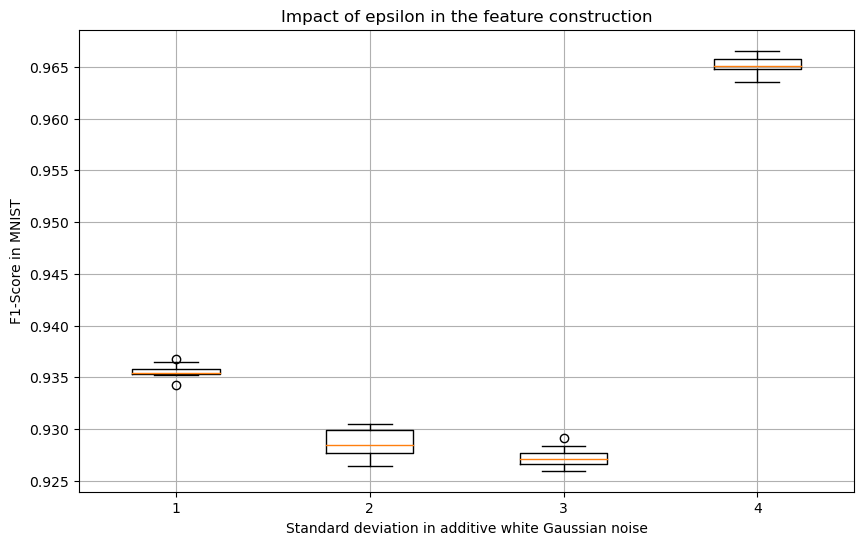

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Crear una figura
plt.figure(figsize=(10, 6))

result=[]
for method in ["gaussian", "sigmoid","gelu","random"]:
    result.append([i[0]["F1 Score"] for i in dict_results[method][1] ])
    
# Plotting boxplots on the third subplot
plt.boxplot(result)


# Configurar las etiquetas y el título del gráfico
plt.xlabel('Standard deviation in additive white Gaussian noise')
plt.ylabel('F1-Score in MNIST')
plt.title('Impact of epsilon in the feature construction')
plt.grid(True)
plt.show()


In [27]:
# Create data
import scipy.stats as stats

# conduct the Wilcoxon-Signed Rank Test
p_value= stats.wilcoxon(result[3] , result[0]).pvalue
if p_value<0.05:
    print("the true mean mpg is not equal between the two groups", p_value)
else:
    print("equal")
 

equal
